# XGBoost Model Building
#### For this week's spin, each team member is working on building a model using an ensemble tree based method. Below is work for XGBoost.

1. [Import Libraries](#import-libraries)
2. [Read split csv files](#read-split-csv-files)
3. [Train XGBoost Model](#train-xgboost-model)
4. [Validation Set Performance and Decision Threshold Tuning](#validation-set-performance-and-decision-threshold-tuning)
5. [Optuna Hypertuning](#optuna-hypertuning)
6. [Risk Stratification](#risk-stratification)

### Import Libraries<a name="import-libraries"></a>

In [1]:
!pip install --upgrade pip

!pip install scikit-learn

!pip install wheel setuptools numpy scipy

!pip install xgboost

!pip install optuna

!pip install graphviz

     |████████████████████████████████| 2.1MB 3.5MB/s eta 0:00:01
  Found existing installation: pip 19.2.2
    Uninstalling pip-19.2.2:
      Successfully uninstalled pip-19.2.2
  Obtaining dependency information for optuna from https://files.pythonhosted.org/packages/a0/8c/f72c6bc61b3c71149af95cd91e16149ea5b5aeae99e6d197f80e79a1035a/optuna-3.2.0-py3-none-any.whl.metadata
  Obtaining dependency information for alembic>=1.5.0 from https://files.pythonhosted.org/packages/11/00/46a4f66ad54c661350a1cd5daae4b4ab2232486c55635ee12ff12958b03f/alembic-1.11.1-py3-none-any.whl.metadata
  Obtaining dependency information for cmaes>=0.9.1 from https://files.pythonhosted.org/packages/f7/46/7d9544d453346f6c0c405916c95fdb653491ea2e9976cabb810ba2fe8cd4/cmaes-0.10.0-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 2.7 MB/s eta 0:00:00
  Obtaining dependency information for importlib-metadata from https://files.pythonhosted.org/packages/ff/94/64287b38c7de4c90683630338

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, precision_recall_curve, recall_score, f1_score, roc_curve
from xgboost import plot_importance
import optuna
from xgboost import DMatrix, plot_tree, XGBClassifier
import seaborn as sns
import graphviz
from sklearn.model_selection import StratifiedKFold, learning_curve
from sklearn.calibration import calibration_curve


### Read split csv files<a name="read-split-csv-files"></a>

In [3]:
file_path = "/dsa/groups/casestudy2023su/team03/Data4/"

merged_df = pd.read_csv(file_path + "mros_merged.csv")

X_train = pd.read_csv(file_path + "X_train.csv")
X_test = pd.read_csv(file_path + "X_test.csv")
X_val = pd.read_csv(file_path + "X_validation.csv")

y_train = pd.read_csv(file_path + "y_train.csv")
y_test = pd.read_csv(file_path + "y_test.csv")
y_val = pd.read_csv(file_path + "y_validation.csv")



In [4]:
#double checking our split counts

print("merged_df shape: ", merged_df.shape)
print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)
print("X_validation shape: ", X_val.shape)
print("y_train shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)
print("y_validation shape: ", y_val.shape)
print("merged_df type: ", type(merged_df))
print("X_train type: ", type(X_train))
print("X_test type: ", type(X_test))
print("X_validation type: ", type(X_val))
print("y_train type: ", type(y_train))
print("y_test type: ", type(y_test))
print("y_validation type: ", type(y_val))



merged_df shape:  (5994, 381)
X_train shape:  (7528, 292)
X_test shape:  (599, 292)
X_validation shape:  (600, 292)
y_train shape:  (7528, 1)
y_test shape:  (599, 1)
y_validation shape:  (600, 1)
merged_df type:  <class 'pandas.core.frame.DataFrame'>
X_train type:  <class 'pandas.core.frame.DataFrame'>
X_test type:  <class 'pandas.core.frame.DataFrame'>
X_validation type:  <class 'pandas.core.frame.DataFrame'>
y_train type:  <class 'pandas.core.frame.DataFrame'>
y_test type:  <class 'pandas.core.frame.DataFrame'>
y_validation type:  <class 'pandas.core.frame.DataFrame'>


# Train XGBoost Model<a name="train-xgboost-model"></a>

In [5]:
#converting to numpy array for XGBoost

y_train = y_train.values.ravel()
y_test = y_test.values.ravel()
y_validation = y_val.values.ravel()

In [6]:
train_data = xgb.DMatrix(data=X_train, label=y_train)
param = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
}
bst = xgb.train(param, train_data)

In [7]:
train_predictions = bst.predict(xgb.DMatrix(data=X_train))
train_predictions_binary = (train_predictions > 0.5).astype(int)
print("Training set classification report:")
print(classification_report(y_train, train_predictions_binary))

Training set classification report:
              precision    recall  f1-score   support

           0       0.82      0.99      0.90      3764
           1       0.99      0.78      0.87      3764

    accuracy                           0.89      7528
   macro avg       0.90      0.89      0.88      7528
weighted avg       0.90      0.89      0.88      7528



In [8]:
#Make predictions on the validation set
val_data = xgb.DMatrix(data=X_val)
val_predictions = bst.predict(val_data)

In [9]:
#calculate some eval metrics for the val set
val_auc_score = roc_auc_score(y_val, val_predictions)
val_accuracy = accuracy_score(y_val, (val_predictions > 0.5).astype(int))
print(f"\nValidation AUC: {val_auc_score}")
print(f"Validation Accuracy: {val_accuracy}")


Validation AUC: 0.6368677171610169
Validation Accuracy: 0.785


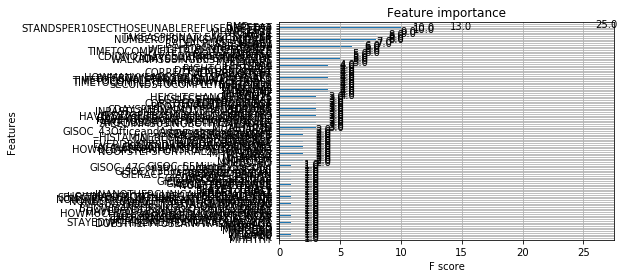

In [10]:
#plot feature importance

plot_importance(bst)
plt.show()

importance = bst.get_score(importance_type='gain')

# Convert into a pandas dataframe
importance_df = pd.DataFrame({
    'Feature': list(importance.keys()),
    'Score': list(importance.values())
})

#### Feature importance plot is unreadable. Lets convert to a dataframe, and limit to the gainers with a score above 20

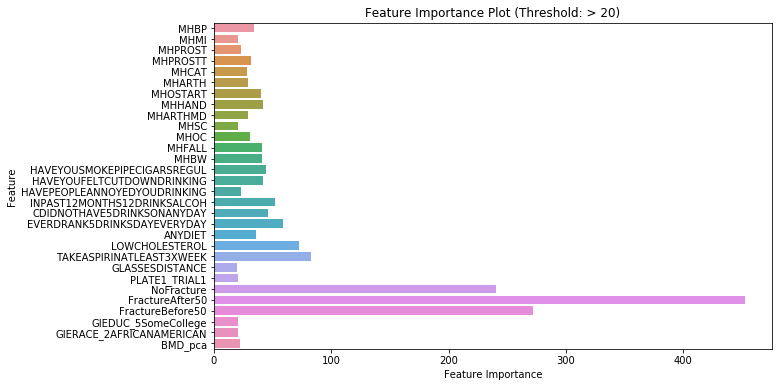

In [11]:
threshold = 20

# Filter the DataFrame based on the score threshold
filtered_df = importance_df[importance_df['Score'] > threshold]

plt.figure(figsize=(10, 6))
sns.barplot(x='Score', y='Feature', data=filtered_df, orient='h')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance Plot (Threshold: > {})'.format(threshold))
plt.show()

In [12]:
# Sort by the score in descending order
importance_df = importance_df.sort_values(by='Score', ascending=False)

# Display the importance_df dataframe
print(importance_df)

# Modify pandas display options to show all rows
pd.set_option('display.max_rows', None)

# Display the importance_df dataframe
print(importance_df)

# Reset pandas display options to default
pd.reset_option('display.max_rows')


                               Feature       Score
109                    FractureAfter50  452.784576
110                   FractureBefore50  271.633209
108                         NoFracture  240.055038
86            TAKEASPIRINATLEAST3XWEEK   82.769066
72                      LOWCHOLESTEROL   72.399971
..                                 ...         ...
40     STAYEDWITHINLINESFORNARROWWALK2    2.892051
36            SECONDSTOCOMPLETE5STANDS    2.741497
77            DIRUETICPOTASSIUMSPARING    1.922306
122  GISOC_47ConstructionandExtraction    1.707411
97                       PLATE1_TRIAL4    1.532604

[125 rows x 2 columns]
                                    Feature       Score
109                         FractureAfter50  452.784576
110                        FractureBefore50  271.633209
108                              NoFracture  240.055038
86                 TAKEASPIRINATLEAST3XWEEK   82.769066
72                           LOWCHOLESTEROL   72.399971
68              EVERDRANK5DR

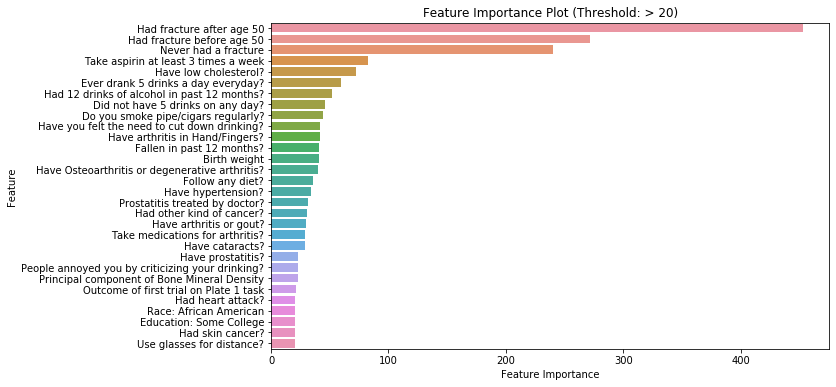

In [27]:
# Variable name - description mapping
variables_dict = {
    'MHHAND': 'Have arthritis in Hand/Fingers?',
    'MHFALL': 'Fallen in past 12 months?',
    'MHBW': 'Birth weight',
    'MHOSTART': 'Have Osteoarthritis or degenerative arthritis?',
    'ANYDIET': 'Follow any diet?',
    'MHBP': 'Have hypertension?',
    'MHPROSTT': 'Prostatitis treated by doctor?',
    'MHOC': 'Had other kind of cancer?',
    'MHARTH': 'Have arthritis or gout?',
    'MHARTHMD': 'Take medications for arthritis?',
    'MHCAT': 'Have cataracts?',
    'MHPROST': 'Have prostatitis?',
    'MHSC': 'Had skin cancer?',
    'MHMI': 'Had heart attack?',
    'GLASSESDISTANCE': 'Use glasses for distance?',
    'BMD_pca': 'Principal component of Bone Mineral Density',
    'HAVEPEOPLEANNOYEDYOUDRINKING': 'People annoyed you by criticizing your drinking?',
    'PLATE1_TRIAL1': 'Outcome of first trial on Plate 1 task',
    'GIEDUC_5SomeCollege': 'Education: Some College',
    'GIERACE_2AFRICANAMERICAN': 'Race: African American',
    'FractureAfter50': 'Had fracture after age 50',
    'FractureBefore50': 'Had fracture before age 50',
    'NoFracture': 'Never had a fracture',
    'TAKEASPIRINATLEAST3XWEEK': 'Take aspirin at least 3 times a week',
    'LOWCHOLESTEROL': 'Have low cholesterol?',
    'EVERDRANK5DRINKSDAYEVERYDAY': 'Ever drank 5 drinks a day everyday?',
    'INPAST12MONTHS12DRINKSALCOH': 'Had 12 drinks of alcohol in past 12 months?',
    'CDIDNOTHAVE5DRINKSONANYDAY': 'Did not have 5 drinks on any day?',
    'HAVEYOUSMOKEPIPECIGARSREGUL': 'Do you smoke pipe/cigars regularly?',
    'HAVEYOUFELTCUTDOWNDRINKING': 'Have you felt the need to cut down drinking?',
}

# Create a new column with the descriptive names
importance_df['FeatureDescription'] = importance_df['Feature'].map(variables_dict)

# Replace NaNs in 'FeatureDescription' with original feature name
importance_df['FeatureDescription'].fillna(importance_df['Feature'], inplace=True)

# Drop the original 'Feature' column and rename 'FeatureDescription' as 'Feature'
importance_df.drop('Feature', axis=1, inplace=True)
importance_df.rename(columns={'FeatureDescription': 'Feature'}, inplace=True)

# Now the plot redux
filtered_df = importance_df[importance_df['Score'] > threshold]

plt.figure(figsize=(10, 6))
sns.barplot(x='Score', y='Feature', data=filtered_df, orient='h')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance Plot (Threshold: > {})'.format(threshold))
plt.show()


# Validation Set Performance and Decision Threshold Tuning<a name="validation-set-performance-and-decision-threshold-tuning"></a>

In [13]:
# Validation set classification report
val_predictions_binary = (val_predictions > 0.5).astype(int)
print("\nValidation set classification report:")
print(classification_report(y_val, val_predictions_binary))


Validation set classification report:
              precision    recall  f1-score   support

           0       0.80      0.98      0.88       472
           1       0.47      0.07      0.12       128

    accuracy                           0.79       600
   macro avg       0.63      0.52      0.50       600
weighted avg       0.73      0.79      0.72       600



### Unsurprisingly, our predictive performance on class 1 dropped substantially on the validation set. Let's see if we can alter the decision threshold to increase recall on class 1. 

In [14]:
# was curious how important the BMD_pca values are
# Search for the feature in the DataFrame
feature_rank = importance_df[importance_df['Feature'] == 'BMD_pca']

# Print the result
print(feature_rank)


     Feature      Score
124  BMD_pca  22.533375


In [15]:
# get probabilities of the prediction
y_val_prob = bst.predict(val_data)

# generate precision-recall curve values: precisions, recalls, thresholds
precisions, recalls, thresholds = precision_recall_curve(y_val, y_val_prob)

# convert to f score
fscore = (2 * precisions * recalls) / (precisions + recalls)

# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], fscore[ix], precisions[ix], recalls[ix]))

# adjust the threshold
adjusted_y_val_pred = [1 if y >= thresholds[ix] else 0 for y in y_val_prob]

print(classification_report(y_val, adjusted_y_val_pred))


Best Threshold=0.168732, F-Score=0.408, Precision=0.262, Recall=0.914
              precision    recall  f1-score   support

           0       0.93      0.30      0.46       472
           1       0.26      0.91      0.41       128

    accuracy                           0.43       600
   macro avg       0.60      0.61      0.43       600
weighted avg       0.79      0.43      0.45       600



# Optuna Hypertuning<a name="optuna-hypertuning"></a>

### Able to get recall pretty high at the drawback of a lot of false positives. May have utility as an early warning system. Below, let's try and use optuna for hyperparameter tuning.

In [16]:
X_train = X_train.values


def objective(trial):
    param = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'booster': trial.suggest_categorical('booster', ['gbtree']),
        'lambda': trial.suggest_float('lambda', 0.01, 10.0, log=True),
        'alpha': trial.suggest_float('alpha', 0.01, 10.0, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'eta': trial.suggest_float('eta', 0.01, 1.0, log=True),
        'gamma': trial.suggest_float('gamma', 0.01, 1.0, log=True),
        'grow_policy': trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide']),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 10)
    }
    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    f1_scores = []

    for train_index, val_index in skf.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        train_data = xgb.DMatrix(data=X_train_fold, label=y_train_fold)
        val_data = xgb.DMatrix(data=X_val_fold, label=y_val_fold)

        bst = xgb.train(param, train_data, evals=[(val_data, 'eval')], early_stopping_rounds=10)
        preds = bst.predict(val_data, ntree_limit=bst.best_ntree_limit)
        pred_labels = np.rint(preds)
        f1 = f1_score(y_val_fold, pred_labels)  
        f1_scores.append(f1)

    return np.mean(f1_scores) 

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

trial = study.best_trial

print('Average F1-score: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))




[I 2023-07-25 12:45:09,202] A new study created in memory with name: no-name-1ffc5eb8-6333-4678-8fcd-3d7abd57f8b7


[0]	eval-logloss:0.66773
[1]	eval-logloss:0.64524
[2]	eval-logloss:0.62441
[3]	eval-logloss:0.60547
[4]	eval-logloss:0.58766
[5]	eval-logloss:0.57266
[6]	eval-logloss:0.55776
[7]	eval-logloss:0.54427
[8]	eval-logloss:0.53292
[9]	eval-logloss:0.52271
[0]	eval-logloss:0.66616
[1]	eval-logloss:0.64219
[2]	eval-logloss:0.62083


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[3]	eval-logloss:0.60166
[4]	eval-logloss:0.58465
[5]	eval-logloss:0.56896
[6]	eval-logloss:0.55372
[7]	eval-logloss:0.53933
[8]	eval-logloss:0.52620
[9]	eval-logloss:0.51357
[0]	eval-logloss:0.66766
[1]	eval-logloss:0.64507
[2]	eval-logloss:0.62374


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[3]	eval-logloss:0.60558
[4]	eval-logloss:0.58810
[5]	eval-logloss:0.57294
[6]	eval-logloss:0.55836
[7]	eval-logloss:0.54567
[8]	eval-logloss:0.53361
[9]	eval-logloss:0.52283
[0]	eval-logloss:0.66751
[1]	eval-logloss:0.64346
[2]	eval-logloss:0.62240


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[3]	eval-logloss:0.60387
[4]	eval-logloss:0.58604
[5]	eval-logloss:0.57052
[6]	eval-logloss:0.55563
[7]	eval-logloss:0.54217
[8]	eval-logloss:0.52981
[9]	eval-logloss:0.51851
[0]	eval-logloss:0.66492
[1]	eval-logloss:0.64037
[2]	eval-logloss:0.61857


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[3]	eval-logloss:0.59846
[4]	eval-logloss:0.57950
[5]	eval-logloss:0.56304
[6]	eval-logloss:0.54744
[7]	eval-logloss:0.53333
[8]	eval-logloss:0.52015
[9]	eval-logloss:0.50821


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
[I 2023-07-25 12:45:11,727] Trial 0 finished with value: 0.8146295946297473 and parameters: {'booster': 'gbtree', 'lambda': 1.871326119428741, 'alpha': 0.9796689057060904, 'max_depth': 10, 'eta': 0.059521489956924856, 'gamma': 0.7798244776863487, 'grow_policy': 'lossguide', 'min_child_weight': 1, 'scale_pos_weight': 1.4397460831377786}. Best is trial 0 with value: 0.8146295946297473.


[0]	eval-logloss:0.66011
[1]	eval-logloss:0.65189
[2]	eval-logloss:0.65407
[3]	eval-logloss:0.65164
[4]	eval-logloss:0.65007
[5]	eval-logloss:0.64246
[6]	eval-logloss:0.63836
[7]	eval-logloss:0.63588
[8]	eval-logloss:0.62560
[9]	eval-logloss:0.61611
[0]	eval-logloss:0.65734
[1]	eval-logloss:0.65328
[2]	eval-logloss:0.66005
[3]	eval-logloss:0.66184
[4]	eval-logloss:0.66344
[5]	eval-logloss:0.65452
[6]	eval-logloss:0.64540


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[7]	eval-logloss:0.64259
[8]	eval-logloss:0.63445
[9]	eval-logloss:0.62298
[0]	eval-logloss:0.65857
[1]	eval-logloss:0.65265
[2]	eval-logloss:0.65323
[3]	eval-logloss:0.65068
[4]	eval-logloss:0.65014
[5]	eval-logloss:0.64355
[6]	eval-logloss:0.63562


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[7]	eval-logloss:0.63065
[8]	eval-logloss:0.62588
[9]	eval-logloss:0.62398
[0]	eval-logloss:0.65934
[1]	eval-logloss:0.65535
[2]	eval-logloss:0.66097
[3]	eval-logloss:0.66619
[4]	eval-logloss:0.66292
[5]	eval-logloss:0.66262


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[6]	eval-logloss:0.65899
[7]	eval-logloss:0.65248
[8]	eval-logloss:0.64206
[9]	eval-logloss:0.63380
[0]	eval-logloss:0.65445
[1]	eval-logloss:0.64418
[2]	eval-logloss:0.64368
[3]	eval-logloss:0.63860
[4]	eval-logloss:0.63823
[5]	eval-logloss:0.63488
[6]	eval-logloss:0.63338


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[7]	eval-logloss:0.63068
[8]	eval-logloss:0.62340
[9]	eval-logloss:0.60823


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
[I 2023-07-25 12:45:13,072] Trial 1 finished with value: 0.7070631611131738 and parameters: {'booster': 'gbtree', 'lambda': 0.028322369227076098, 'alpha': 0.010892755663158988, 'max_depth': 5, 'eta': 0.30502492453134095, 'gamma': 0.3344393481399495, 'grow_policy': 'lossguide', 'min_child_weight': 7, 'scale_pos_weight': 7.722740471841526}. Best is trial 0 with value: 0.8146295946297473.


[0]	eval-logloss:0.67583
[1]	eval-logloss:0.66644
[2]	eval-logloss:0.66456
[3]	eval-logloss:0.66247
[4]	eval-logloss:0.66438
[5]	eval-logloss:0.66686
[6]	eval-logloss:0.67003
[7]	eval-logloss:0.67208
[8]	eval-logloss:0.67233
[9]	eval-logloss:0.67579
[0]	eval-logloss:0.67452
[1]	eval-logloss:0.66706
[2]	eval-logloss:0.66339
[3]	eval-logloss:0.66141
[4]	eval-logloss:0.66345
[5]	eval-logloss:0.66789
[6]	eval-logloss:0.67017


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[7]	eval-logloss:0.67336
[8]	eval-logloss:0.67534
[9]	eval-logloss:0.67911
[0]	eval-logloss:0.67480
[1]	eval-logloss:0.66438
[2]	eval-logloss:0.65814
[3]	eval-logloss:0.65813
[4]	eval-logloss:0.65745
[5]	eval-logloss:0.66228
[6]	eval-logloss:0.66483


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[7]	eval-logloss:0.66739
[8]	eval-logloss:0.66840
[9]	eval-logloss:0.67292
[0]	eval-logloss:0.67727
[1]	eval-logloss:0.66922
[2]	eval-logloss:0.66327
[3]	eval-logloss:0.66315
[4]	eval-logloss:0.66547
[5]	eval-logloss:0.66862
[6]	eval-logloss:0.67461


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[7]	eval-logloss:0.67655
[8]	eval-logloss:0.68025
[9]	eval-logloss:0.68160
[0]	eval-logloss:0.67262
[1]	eval-logloss:0.66295
[2]	eval-logloss:0.66053
[3]	eval-logloss:0.65766
[4]	eval-logloss:0.65837
[5]	eval-logloss:0.66142
[6]	eval-logloss:0.66485


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[7]	eval-logloss:0.66589
[8]	eval-logloss:0.66625
[9]	eval-logloss:0.66914


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
[I 2023-07-25 12:45:14,364] Trial 2 finished with value: 0.6825593012010367 and parameters: {'booster': 'gbtree', 'lambda': 0.16383422689677282, 'alpha': 2.326559061421879, 'max_depth': 5, 'eta': 0.13112371788979463, 'gamma': 0.08022158590238913, 'grow_policy': 'depthwise', 'min_child_weight': 10, 'scale_pos_weight': 9.571883233534823}. Best is trial 0 with value: 0.8146295946297473.


[0]	eval-logloss:0.63495
[1]	eval-logloss:0.60731
[2]	eval-logloss:0.58816
[3]	eval-logloss:0.57027
[4]	eval-logloss:0.55514
[5]	eval-logloss:0.54536
[6]	eval-logloss:0.53649
[7]	eval-logloss:0.52500
[8]	eval-logloss:0.51325
[9]	eval-logloss:0.50271
[0]	eval-logloss:0.64283
[1]	eval-logloss:0.61484
[2]	eval-logloss:0.59738
[3]	eval-logloss:0.58200
[4]	eval-logloss:0.56969


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.56042
[6]	eval-logloss:0.54729
[7]	eval-logloss:0.53867
[8]	eval-logloss:0.53203
[9]	eval-logloss:0.52778
[0]	eval-logloss:0.63893
[1]	eval-logloss:0.60597
[2]	eval-logloss:0.58484
[3]	eval-logloss:0.56750
[4]	eval-logloss:0.55490


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.54463
[6]	eval-logloss:0.53617
[7]	eval-logloss:0.52254
[8]	eval-logloss:0.51327
[9]	eval-logloss:0.50431
[0]	eval-logloss:0.63891
[1]	eval-logloss:0.61539
[2]	eval-logloss:0.59478
[3]	eval-logloss:0.58443
[4]	eval-logloss:0.57212


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.55969
[6]	eval-logloss:0.55196
[7]	eval-logloss:0.54494
[8]	eval-logloss:0.53379
[9]	eval-logloss:0.52576
[0]	eval-logloss:0.63831
[1]	eval-logloss:0.60375
[2]	eval-logloss:0.58640
[3]	eval-logloss:0.56929
[4]	eval-logloss:0.55462


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.54365
[6]	eval-logloss:0.53252
[7]	eval-logloss:0.51753
[8]	eval-logloss:0.50743
[9]	eval-logloss:0.49726


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
[I 2023-07-25 12:45:16,094] Trial 3 finished with value: 0.7484128764441097 and parameters: {'booster': 'gbtree', 'lambda': 0.02625424131855266, 'alpha': 0.4176401514596012, 'max_depth': 7, 'eta': 0.25970008780289966, 'gamma': 0.997026679860834, 'grow_policy': 'lossguide', 'min_child_weight': 6, 'scale_pos_weight': 6.117207444273803}. Best is trial 0 with value: 0.8146295946297473.


[0]	eval-logloss:0.65838
[1]	eval-logloss:0.63502
[2]	eval-logloss:0.61748
[3]	eval-logloss:0.60711
[4]	eval-logloss:0.59867
[5]	eval-logloss:0.59218
[6]	eval-logloss:0.58432
[7]	eval-logloss:0.57709
[8]	eval-logloss:0.57111
[9]	eval-logloss:0.56221
[0]	eval-logloss:0.65614
[1]	eval-logloss:0.63260
[2]	eval-logloss:0.61752
[3]	eval-logloss:0.60595
[4]	eval-logloss:0.59790
[5]	eval-logloss:0.59230
[6]	eval-logloss:0.58699
[7]	eval-logloss:0.57838


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[8]	eval-logloss:0.57329
[9]	eval-logloss:0.56942
[0]	eval-logloss:0.65649
[1]	eval-logloss:0.63278
[2]	eval-logloss:0.61915
[3]	eval-logloss:0.60974
[4]	eval-logloss:0.59947
[5]	eval-logloss:0.59150
[6]	eval-logloss:0.58308
[7]	eval-logloss:0.57747
[8]	eval-logloss:0.57115


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[9]	eval-logloss:0.56552
[0]	eval-logloss:0.65770
[1]	eval-logloss:0.63633
[2]	eval-logloss:0.62338
[3]	eval-logloss:0.61147
[4]	eval-logloss:0.60067
[5]	eval-logloss:0.59598
[6]	eval-logloss:0.59516
[7]	eval-logloss:0.58922
[8]	eval-logloss:0.58657


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[9]	eval-logloss:0.58182
[0]	eval-logloss:0.65819
[1]	eval-logloss:0.63599
[2]	eval-logloss:0.61885
[3]	eval-logloss:0.60491
[4]	eval-logloss:0.59674
[5]	eval-logloss:0.59131
[6]	eval-logloss:0.58376
[7]	eval-logloss:0.57751
[8]	eval-logloss:0.57726


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[9]	eval-logloss:0.57163


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
[I 2023-07-25 12:45:17,220] Trial 4 finished with value: 0.7078673111715214 and parameters: {'booster': 'gbtree', 'lambda': 0.11725388938300232, 'alpha': 0.34074377450615523, 'max_depth': 4, 'eta': 0.1767465423789597, 'gamma': 0.3737864335426532, 'grow_policy': 'lossguide', 'min_child_weight': 8, 'scale_pos_weight': 4.295522359341957}. Best is trial 0 with value: 0.8146295946297473.


[0]	eval-logloss:0.68431
[1]	eval-logloss:0.67661
[2]	eval-logloss:0.66936
[3]	eval-logloss:0.66306
[4]	eval-logloss:0.65711
[5]	eval-logloss:0.65246
[6]	eval-logloss:0.64694
[7]	eval-logloss:0.64228
[8]	eval-logloss:0.63664
[9]	eval-logloss:0.63309
[0]	eval-logloss:0.68318
[1]	eval-logloss:0.67395
[2]	eval-logloss:0.66615
[3]	eval-logloss:0.65955


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[4]	eval-logloss:0.65328
[5]	eval-logloss:0.64777
[6]	eval-logloss:0.64342
[7]	eval-logloss:0.63929
[8]	eval-logloss:0.63582
[9]	eval-logloss:0.63127
[0]	eval-logloss:0.68344
[1]	eval-logloss:0.67474
[2]	eval-logloss:0.66671
[3]	eval-logloss:0.65979


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[4]	eval-logloss:0.65309
[5]	eval-logloss:0.64708
[6]	eval-logloss:0.64134
[7]	eval-logloss:0.63536
[8]	eval-logloss:0.63113
[9]	eval-logloss:0.62690
[0]	eval-logloss:0.68379
[1]	eval-logloss:0.67617
[2]	eval-logloss:0.66893
[3]	eval-logloss:0.66288


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[4]	eval-logloss:0.65761
[5]	eval-logloss:0.65317
[6]	eval-logloss:0.64832
[7]	eval-logloss:0.64457
[8]	eval-logloss:0.64107
[9]	eval-logloss:0.63799
[0]	eval-logloss:0.68239
[1]	eval-logloss:0.67326
[2]	eval-logloss:0.66507
[3]	eval-logloss:0.65732


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[4]	eval-logloss:0.65128
[5]	eval-logloss:0.64618
[6]	eval-logloss:0.64101
[7]	eval-logloss:0.63677
[8]	eval-logloss:0.63327
[9]	eval-logloss:0.62894


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
[I 2023-07-25 12:45:19,157] Trial 5 finished with value: 0.707824100415738 and parameters: {'booster': 'gbtree', 'lambda': 0.025134399615073025, 'alpha': 1.8886411918163988, 'max_depth': 8, 'eta': 0.04064651676971624, 'gamma': 0.13520611088140752, 'grow_policy': 'depthwise', 'min_child_weight': 10, 'scale_pos_weight': 9.102146848839524}. Best is trial 0 with value: 0.8146295946297473.


[0]	eval-logloss:0.68813
[1]	eval-logloss:0.68319
[2]	eval-logloss:0.67860
[3]	eval-logloss:0.67417
[4]	eval-logloss:0.66992
[5]	eval-logloss:0.66566
[6]	eval-logloss:0.66182
[7]	eval-logloss:0.65808
[8]	eval-logloss:0.65452
[9]	eval-logloss:0.65111
[0]	eval-logloss:0.68745
[1]	eval-logloss:0.68250
[2]	eval-logloss:0.67757
[3]	eval-logloss:0.67298


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[4]	eval-logloss:0.66852
[5]	eval-logloss:0.66404
[6]	eval-logloss:0.65964
[7]	eval-logloss:0.65589
[8]	eval-logloss:0.65230
[9]	eval-logloss:0.64953
[0]	eval-logloss:0.68786
[1]	eval-logloss:0.68249
[2]	eval-logloss:0.67753
[3]	eval-logloss:0.67258


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[4]	eval-logloss:0.66821
[5]	eval-logloss:0.66452
[6]	eval-logloss:0.66057
[7]	eval-logloss:0.65682
[8]	eval-logloss:0.65288
[9]	eval-logloss:0.64963
[0]	eval-logloss:0.68834
[1]	eval-logloss:0.68387
[2]	eval-logloss:0.67943
[3]	eval-logloss:0.67490


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[4]	eval-logloss:0.67086
[5]	eval-logloss:0.66668
[6]	eval-logloss:0.66325
[7]	eval-logloss:0.65970
[8]	eval-logloss:0.65671
[9]	eval-logloss:0.65344
[0]	eval-logloss:0.68755
[1]	eval-logloss:0.68228
[2]	eval-logloss:0.67700
[3]	eval-logloss:0.67219


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[4]	eval-logloss:0.66770
[5]	eval-logloss:0.66292
[6]	eval-logloss:0.65885
[7]	eval-logloss:0.65462
[8]	eval-logloss:0.65083
[9]	eval-logloss:0.64725


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
[I 2023-07-25 12:45:21,329] Trial 6 finished with value: 0.7144104696589105 and parameters: {'booster': 'gbtree', 'lambda': 1.8098062748969808, 'alpha': 0.03482840016120625, 'max_depth': 9, 'eta': 0.019317595648471683, 'gamma': 0.4387980894350138, 'grow_policy': 'lossguide', 'min_child_weight': 3, 'scale_pos_weight': 8.680717160090744}. Best is trial 0 with value: 0.8146295946297473.


[0]	eval-logloss:0.66627
[1]	eval-logloss:0.66813
[2]	eval-logloss:0.67878
[3]	eval-logloss:0.68096
[4]	eval-logloss:0.67802
[5]	eval-logloss:0.68139
[6]	eval-logloss:0.67720
[7]	eval-logloss:0.67117
[8]	eval-logloss:0.65673
[9]	eval-logloss:0.63647
[0]	eval-logloss:0.66222
[1]	eval-logloss:0.66726
[2]	eval-logloss:0.68651
[3]	eval-logloss:0.69027
[4]	eval-logloss:0.69485
[5]	eval-logloss:0.67736
[6]	eval-logloss:0.67942


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[7]	eval-logloss:0.67386
[8]	eval-logloss:0.66138
[9]	eval-logloss:0.64440
[0]	eval-logloss:0.66365
[1]	eval-logloss:0.67169
[2]	eval-logloss:0.67486
[3]	eval-logloss:0.67817
[4]	eval-logloss:0.68115
[5]	eval-logloss:0.68308
[6]	eval-logloss:0.67245


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[7]	eval-logloss:0.66715
[8]	eval-logloss:0.65824
[9]	eval-logloss:0.64788
[0]	eval-logloss:0.66873
[1]	eval-logloss:0.67594
[2]	eval-logloss:0.68927
[3]	eval-logloss:0.68653
[4]	eval-logloss:0.69232
[5]	eval-logloss:0.69285
[6]	eval-logloss:0.69356


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[7]	eval-logloss:0.68007
[8]	eval-logloss:0.66927
[9]	eval-logloss:0.65904
[0]	eval-logloss:0.65920
[1]	eval-logloss:0.65656
[2]	eval-logloss:0.66476
[3]	eval-logloss:0.66619
[4]	eval-logloss:0.66551
[5]	eval-logloss:0.66784
[6]	eval-logloss:0.66677


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[7]	eval-logloss:0.66380
[8]	eval-logloss:0.65822
[9]	eval-logloss:0.64865


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
[I 2023-07-25 12:45:22,649] Trial 7 finished with value: 0.7034098394390913 and parameters: {'booster': 'gbtree', 'lambda': 0.26695755280640565, 'alpha': 0.024963175681408576, 'max_depth': 5, 'eta': 0.3427959154256091, 'gamma': 0.010163986742182224, 'grow_policy': 'depthwise', 'min_child_weight': 7, 'scale_pos_weight': 9.03691679032705}. Best is trial 0 with value: 0.8146295946297473.


[0]	eval-logloss:0.67404
[1]	eval-logloss:0.65717
[2]	eval-logloss:0.64343
[3]	eval-logloss:0.63293
[4]	eval-logloss:0.62314
[5]	eval-logloss:0.61388
[6]	eval-logloss:0.60566
[7]	eval-logloss:0.59850
[8]	eval-logloss:0.59206
[9]	eval-logloss:0.58712
[0]	eval-logloss:0.67334
[1]	eval-logloss:0.65798
[2]	eval-logloss:0.64432
[3]	eval-logloss:0.63296
[4]	eval-logloss:0.62350


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.61606
[6]	eval-logloss:0.60908
[7]	eval-logloss:0.60237
[8]	eval-logloss:0.59609
[9]	eval-logloss:0.58967
[0]	eval-logloss:0.67131
[1]	eval-logloss:0.65416
[2]	eval-logloss:0.64031
[3]	eval-logloss:0.62796
[4]	eval-logloss:0.61794


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.61040
[6]	eval-logloss:0.60146
[7]	eval-logloss:0.59415
[8]	eval-logloss:0.58832
[9]	eval-logloss:0.58324
[0]	eval-logloss:0.67331
[1]	eval-logloss:0.65782
[2]	eval-logloss:0.64543
[3]	eval-logloss:0.63584
[4]	eval-logloss:0.62570


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.61799
[6]	eval-logloss:0.61105
[7]	eval-logloss:0.60423
[8]	eval-logloss:0.59889
[9]	eval-logloss:0.59291
[0]	eval-logloss:0.67247
[1]	eval-logloss:0.65525
[2]	eval-logloss:0.64069
[3]	eval-logloss:0.62865
[4]	eval-logloss:0.61934


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.60978
[6]	eval-logloss:0.60236
[7]	eval-logloss:0.59609
[8]	eval-logloss:0.58958
[9]	eval-logloss:0.58387


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
[I 2023-07-25 12:45:24,414] Trial 8 finished with value: 0.7148436265656689 and parameters: {'booster': 'gbtree', 'lambda': 8.3123801449745, 'alpha': 0.07920467941417539, 'max_depth': 7, 'eta': 0.08483368162306364, 'gamma': 0.11169408595948409, 'grow_policy': 'depthwise', 'min_child_weight': 6, 'scale_pos_weight': 5.953114064475754}. Best is trial 0 with value: 0.8146295946297473.


[0]	eval-logloss:0.68600
[1]	eval-logloss:0.67968
[2]	eval-logloss:0.67474
[3]	eval-logloss:0.67128
[4]	eval-logloss:0.66781
[5]	eval-logloss:0.66556
[6]	eval-logloss:0.66450
[7]	eval-logloss:0.66332
[8]	eval-logloss:0.66261
[9]	eval-logloss:0.66275


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[0]	eval-logloss:0.68527
[1]	eval-logloss:0.67823
[2]	eval-logloss:0.67263
[3]	eval-logloss:0.66875
[4]	eval-logloss:0.66545
[5]	eval-logloss:0.66262
[6]	eval-logloss:0.66125
[7]	eval-logloss:0.65965
[8]	eval-logloss:0.65871
[9]	eval-logloss:0.65920


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[0]	eval-logloss:0.68544
[1]	eval-logloss:0.67923
[2]	eval-logloss:0.67342
[3]	eval-logloss:0.66935
[4]	eval-logloss:0.66562
[5]	eval-logloss:0.66279
[6]	eval-logloss:0.66153
[7]	eval-logloss:0.65985
[8]	eval-logloss:0.65921
[9]	eval-logloss:0.65865


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[0]	eval-logloss:0.68588
[1]	eval-logloss:0.68001
[2]	eval-logloss:0.67543
[3]	eval-logloss:0.67200
[4]	eval-logloss:0.66833
[5]	eval-logloss:0.66556
[6]	eval-logloss:0.66372
[7]	eval-logloss:0.66279
[8]	eval-logloss:0.66302
[9]	eval-logloss:0.66250


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[0]	eval-logloss:0.68507
[1]	eval-logloss:0.67860
[2]	eval-logloss:0.67339
[3]	eval-logloss:0.66943
[4]	eval-logloss:0.66629
[5]	eval-logloss:0.66287
[6]	eval-logloss:0.66046
[7]	eval-logloss:0.65979
[8]	eval-logloss:0.65811
[9]	eval-logloss:0.65747


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
[I 2023-07-25 12:45:25,317] Trial 9 finished with value: 0.6718253278877204 and parameters: {'booster': 'gbtree', 'lambda': 0.061875564693766164, 'alpha': 0.015156169713181867, 'max_depth': 3, 'eta': 0.05302235343076402, 'gamma': 0.06569467642245559, 'grow_policy': 'depthwise', 'min_child_weight': 9, 'scale_pos_weight': 6.440549287276092}. Best is trial 0 with value: 0.8146295946297473.


[0]	eval-logloss:0.50520
[1]	eval-logloss:0.45381
[2]	eval-logloss:0.42476
[3]	eval-logloss:0.41394
[4]	eval-logloss:0.41598
[5]	eval-logloss:0.40925
[6]	eval-logloss:0.41174
[7]	eval-logloss:0.40958
[8]	eval-logloss:0.41373
[9]	eval-logloss:0.41365
[0]	eval-logloss:0.51079
[1]	eval-logloss:0.43878
[2]	eval-logloss:0.41837


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[3]	eval-logloss:0.40114
[4]	eval-logloss:0.38805
[5]	eval-logloss:0.38564
[6]	eval-logloss:0.38341
[7]	eval-logloss:0.37074
[8]	eval-logloss:0.36945
[9]	eval-logloss:0.36935
[0]	eval-logloss:0.52029
[1]	eval-logloss:0.45927
[2]	eval-logloss:0.44133


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[3]	eval-logloss:0.43379
[4]	eval-logloss:0.43402
[5]	eval-logloss:0.43338
[6]	eval-logloss:0.42872
[7]	eval-logloss:0.42821
[8]	eval-logloss:0.42491
[9]	eval-logloss:0.41636
[0]	eval-logloss:0.50124
[1]	eval-logloss:0.45052
[2]	eval-logloss:0.43310


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[3]	eval-logloss:0.42433
[4]	eval-logloss:0.41081
[5]	eval-logloss:0.41412
[6]	eval-logloss:0.41512
[7]	eval-logloss:0.41553
[8]	eval-logloss:0.41336
[9]	eval-logloss:0.41024
[0]	eval-logloss:0.49649
[1]	eval-logloss:0.44113
[2]	eval-logloss:0.41524


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[3]	eval-logloss:0.39536
[4]	eval-logloss:0.38574
[5]	eval-logloss:0.38387
[6]	eval-logloss:0.38618
[7]	eval-logloss:0.38824
[8]	eval-logloss:0.38607
[9]	eval-logloss:0.38223


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
[I 2023-07-25 12:45:27,946] Trial 10 finished with value: 0.8139567744695547 and parameters: {'booster': 'gbtree', 'lambda': 0.8703753777303117, 'alpha': 5.795423739649313, 'max_depth': 10, 'eta': 0.7693480610569197, 'gamma': 0.9621466938268615, 'grow_policy': 'lossguide', 'min_child_weight': 1, 'scale_pos_weight': 2.1081358587658094}. Best is trial 0 with value: 0.8146295946297473.


[0]	eval-logloss:0.49336
[1]	eval-logloss:0.43469
[2]	eval-logloss:0.42955
[3]	eval-logloss:0.42049
[4]	eval-logloss:0.41246
[5]	eval-logloss:0.40611
[6]	eval-logloss:0.40400
[7]	eval-logloss:0.41179
[8]	eval-logloss:0.41517
[9]	eval-logloss:0.42276
[0]	eval-logloss:0.47124
[1]	eval-logloss:0.41592
[2]	eval-logloss:0.40256


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[3]	eval-logloss:0.39957
[4]	eval-logloss:0.39350
[5]	eval-logloss:0.38783
[6]	eval-logloss:0.38771
[7]	eval-logloss:0.38783
[8]	eval-logloss:0.38889
[9]	eval-logloss:0.39139
[0]	eval-logloss:0.48958
[1]	eval-logloss:0.43833
[2]	eval-logloss:0.42884


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[3]	eval-logloss:0.41431
[4]	eval-logloss:0.42128
[5]	eval-logloss:0.41564
[6]	eval-logloss:0.42054
[7]	eval-logloss:0.42563
[8]	eval-logloss:0.42680
[9]	eval-logloss:0.42772
[0]	eval-logloss:0.47471
[1]	eval-logloss:0.43962
[2]	eval-logloss:0.41267


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[3]	eval-logloss:0.41200
[4]	eval-logloss:0.41547
[5]	eval-logloss:0.41062
[6]	eval-logloss:0.41145
[7]	eval-logloss:0.41134
[8]	eval-logloss:0.41279
[9]	eval-logloss:0.41729
[0]	eval-logloss:0.46250
[1]	eval-logloss:0.41293
[2]	eval-logloss:0.38223


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[3]	eval-logloss:0.38185
[4]	eval-logloss:0.37282
[5]	eval-logloss:0.36926
[6]	eval-logloss:0.37380
[7]	eval-logloss:0.38137
[8]	eval-logloss:0.37654
[9]	eval-logloss:0.38041


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
[I 2023-07-25 12:45:30,548] Trial 11 finished with value: 0.8160167584239577 and parameters: {'booster': 'gbtree', 'lambda': 0.9782135396966771, 'alpha': 9.674870764477486, 'max_depth': 10, 'eta': 0.9868853475382119, 'gamma': 0.9660434260565358, 'grow_policy': 'lossguide', 'min_child_weight': 1, 'scale_pos_weight': 1.6194748751061905}. Best is trial 11 with value: 0.8160167584239577.


[0]	eval-logloss:0.49828
[1]	eval-logloss:0.43549
[2]	eval-logloss:0.39569
[3]	eval-logloss:0.38474
[4]	eval-logloss:0.37975
[5]	eval-logloss:0.38362
[6]	eval-logloss:0.39365
[7]	eval-logloss:0.39289
[8]	eval-logloss:0.39508
[9]	eval-logloss:0.39694
[0]	eval-logloss:0.47596
[1]	eval-logloss:0.39397
[2]	eval-logloss:0.37382


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[3]	eval-logloss:0.36556
[4]	eval-logloss:0.35633
[5]	eval-logloss:0.35760
[6]	eval-logloss:0.36124
[7]	eval-logloss:0.35926
[8]	eval-logloss:0.36192
[9]	eval-logloss:0.36539
[0]	eval-logloss:0.49263
[1]	eval-logloss:0.42778
[2]	eval-logloss:0.39790


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[3]	eval-logloss:0.38998
[4]	eval-logloss:0.38566
[5]	eval-logloss:0.38350
[6]	eval-logloss:0.38306
[7]	eval-logloss:0.38396
[8]	eval-logloss:0.38448
[9]	eval-logloss:0.38318
[0]	eval-logloss:0.47238
[1]	eval-logloss:0.42782
[2]	eval-logloss:0.40233


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[3]	eval-logloss:0.39247
[4]	eval-logloss:0.38987
[5]	eval-logloss:0.38449
[6]	eval-logloss:0.38629
[7]	eval-logloss:0.38601
[8]	eval-logloss:0.39248
[9]	eval-logloss:0.39002
[0]	eval-logloss:0.47441
[1]	eval-logloss:0.39351
[2]	eval-logloss:0.36442


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[3]	eval-logloss:0.35284
[4]	eval-logloss:0.34740
[5]	eval-logloss:0.34365
[6]	eval-logloss:0.34259
[7]	eval-logloss:0.34154
[8]	eval-logloss:0.34243
[9]	eval-logloss:0.34470


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
[I 2023-07-25 12:45:33,164] Trial 12 finished with value: 0.8259199955926719 and parameters: {'booster': 'gbtree', 'lambda': 0.8396481267503857, 'alpha': 8.094542903563699, 'max_depth': 10, 'eta': 0.8152659217717106, 'gamma': 0.9202939608319634, 'grow_policy': 'lossguide', 'min_child_weight': 1, 'scale_pos_weight': 1.1688028744366248}. Best is trial 12 with value: 0.8259199955926719.


[0]	eval-logloss:0.49479
[1]	eval-logloss:0.43840
[2]	eval-logloss:0.40922
[3]	eval-logloss:0.39378
[4]	eval-logloss:0.38504
[5]	eval-logloss:0.39021
[6]	eval-logloss:0.39596
[7]	eval-logloss:0.39564
[8]	eval-logloss:0.39612
[9]	eval-logloss:0.39917
[0]	eval-logloss:0.47185
[1]	eval-logloss:0.39365
[2]	eval-logloss:0.36821


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[3]	eval-logloss:0.35794
[4]	eval-logloss:0.35585
[5]	eval-logloss:0.35744
[6]	eval-logloss:0.35890
[7]	eval-logloss:0.35881
[8]	eval-logloss:0.35920
[9]	eval-logloss:0.35882
[0]	eval-logloss:0.47737
[1]	eval-logloss:0.42277
[2]	eval-logloss:0.39840


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[3]	eval-logloss:0.38532
[4]	eval-logloss:0.37887
[5]	eval-logloss:0.38031
[6]	eval-logloss:0.38512
[7]	eval-logloss:0.38781
[8]	eval-logloss:0.38711
[9]	eval-logloss:0.38677
[0]	eval-logloss:0.46390
[1]	eval-logloss:0.41701
[2]	eval-logloss:0.39107


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[3]	eval-logloss:0.38119
[4]	eval-logloss:0.37416
[5]	eval-logloss:0.37981
[6]	eval-logloss:0.38089
[7]	eval-logloss:0.37825
[8]	eval-logloss:0.38247
[9]	eval-logloss:0.38226
[0]	eval-logloss:0.47490
[1]	eval-logloss:0.39817
[2]	eval-logloss:0.37057
[3]	eval-logloss:0.36342


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[4]	eval-logloss:0.35754
[5]	eval-logloss:0.34880
[6]	eval-logloss:0.34940
[7]	eval-logloss:0.34720
[8]	eval-logloss:0.34795
[9]	eval-logloss:0.35004


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
[I 2023-07-25 12:45:35,501] Trial 13 finished with value: 0.8223600142467433 and parameters: {'booster': 'gbtree', 'lambda': 0.5893339327921796, 'alpha': 9.228940759100967, 'max_depth': 9, 'eta': 0.8853865206882966, 'gamma': 0.4923819282200736, 'grow_policy': 'lossguide', 'min_child_weight': 3, 'scale_pos_weight': 1.1144642585446016}. Best is trial 12 with value: 0.8259199955926719.


[0]	eval-logloss:0.55556
[1]	eval-logloss:0.49894
[2]	eval-logloss:0.47050
[3]	eval-logloss:0.44352
[4]	eval-logloss:0.42872
[5]	eval-logloss:0.42044
[6]	eval-logloss:0.40797
[7]	eval-logloss:0.40102
[8]	eval-logloss:0.39464
[9]	eval-logloss:0.39412
[0]	eval-logloss:0.56311
[1]	eval-logloss:0.49970
[2]	eval-logloss:0.46006
[3]	eval-logloss:0.44897


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[4]	eval-logloss:0.43093
[5]	eval-logloss:0.41913
[6]	eval-logloss:0.40228
[7]	eval-logloss:0.39201
[8]	eval-logloss:0.38900
[9]	eval-logloss:0.38304
[0]	eval-logloss:0.56582
[1]	eval-logloss:0.50966
[2]	eval-logloss:0.46690
[3]	eval-logloss:0.45334


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[4]	eval-logloss:0.43581
[5]	eval-logloss:0.42422
[6]	eval-logloss:0.41673
[7]	eval-logloss:0.41049
[8]	eval-logloss:0.40892
[9]	eval-logloss:0.40676
[0]	eval-logloss:0.55007
[1]	eval-logloss:0.49046
[2]	eval-logloss:0.46128
[3]	eval-logloss:0.44091


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[4]	eval-logloss:0.42307
[5]	eval-logloss:0.41284
[6]	eval-logloss:0.40912
[7]	eval-logloss:0.40487
[8]	eval-logloss:0.40181
[9]	eval-logloss:0.39964
[0]	eval-logloss:0.55162
[1]	eval-logloss:0.49548
[2]	eval-logloss:0.45453
[3]	eval-logloss:0.42640


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[4]	eval-logloss:0.40892
[5]	eval-logloss:0.39366
[6]	eval-logloss:0.38962
[7]	eval-logloss:0.38828
[8]	eval-logloss:0.38070
[9]	eval-logloss:0.37598


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
[I 2023-07-25 12:45:37,599] Trial 14 finished with value: 0.8074749217902445 and parameters: {'booster': 'gbtree', 'lambda': 0.4376278917677154, 'alpha': 4.674328584541167, 'max_depth': 8, 'eta': 0.5411489590243187, 'gamma': 0.23552813471587425, 'grow_policy': 'lossguide', 'min_child_weight': 3, 'scale_pos_weight': 2.7505024452730593}. Best is trial 12 with value: 0.8259199955926719.


[0]	eval-logloss:0.54531
[1]	eval-logloss:0.50663
[2]	eval-logloss:0.48555
[3]	eval-logloss:0.45917
[4]	eval-logloss:0.44459
[5]	eval-logloss:0.42971
[6]	eval-logloss:0.41969
[7]	eval-logloss:0.41237
[8]	eval-logloss:0.40672
[9]	eval-logloss:0.40642
[0]	eval-logloss:0.55748
[1]	eval-logloss:0.50192
[2]	eval-logloss:0.46184


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[3]	eval-logloss:0.43600
[4]	eval-logloss:0.41987
[5]	eval-logloss:0.40375
[6]	eval-logloss:0.39013
[7]	eval-logloss:0.37897
[8]	eval-logloss:0.38344
[9]	eval-logloss:0.37750
[0]	eval-logloss:0.56630
[1]	eval-logloss:0.51566
[2]	eval-logloss:0.48456


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[3]	eval-logloss:0.46721
[4]	eval-logloss:0.45359
[5]	eval-logloss:0.43605
[6]	eval-logloss:0.43378
[7]	eval-logloss:0.42452
[8]	eval-logloss:0.42439
[9]	eval-logloss:0.42103
[0]	eval-logloss:0.56229
[1]	eval-logloss:0.50774
[2]	eval-logloss:0.48518


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[3]	eval-logloss:0.46364
[4]	eval-logloss:0.45159
[5]	eval-logloss:0.44565
[6]	eval-logloss:0.44562
[7]	eval-logloss:0.43884
[8]	eval-logloss:0.43347
[9]	eval-logloss:0.42666
[0]	eval-logloss:0.55036
[1]	eval-logloss:0.48758
[2]	eval-logloss:0.45475


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[3]	eval-logloss:0.42809
[4]	eval-logloss:0.41649
[5]	eval-logloss:0.41037
[6]	eval-logloss:0.40133
[7]	eval-logloss:0.39127
[8]	eval-logloss:0.39368
[9]	eval-logloss:0.38920


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
[I 2023-07-25 12:45:39,947] Trial 15 finished with value: 0.8021916219051963 and parameters: {'booster': 'gbtree', 'lambda': 0.45026563518124, 'alpha': 8.465946616997403, 'max_depth': 9, 'eta': 0.6050997614429408, 'gamma': 0.5668580397190142, 'grow_policy': 'lossguide', 'min_child_weight': 3, 'scale_pos_weight': 3.1482615797087563}. Best is trial 12 with value: 0.8259199955926719.


[0]	eval-logloss:0.48151
[1]	eval-logloss:0.42759
[2]	eval-logloss:0.40787
[3]	eval-logloss:0.40161
[4]	eval-logloss:0.39499
[5]	eval-logloss:0.39068
[6]	eval-logloss:0.39053
[7]	eval-logloss:0.38807
[8]	eval-logloss:0.39283
[9]	eval-logloss:0.39478
[0]	eval-logloss:0.46980
[1]	eval-logloss:0.38791
[2]	eval-logloss:0.36508


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[3]	eval-logloss:0.35162
[4]	eval-logloss:0.35678
[5]	eval-logloss:0.35621
[6]	eval-logloss:0.34883
[7]	eval-logloss:0.35089
[8]	eval-logloss:0.35665
[9]	eval-logloss:0.35965
[0]	eval-logloss:0.48486
[1]	eval-logloss:0.43552
[2]	eval-logloss:0.40843
[3]	eval-logloss:0.39466


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[4]	eval-logloss:0.39138
[5]	eval-logloss:0.39068
[6]	eval-logloss:0.39767
[7]	eval-logloss:0.39772
[8]	eval-logloss:0.39827
[9]	eval-logloss:0.39940
[0]	eval-logloss:0.46284
[1]	eval-logloss:0.40834
[2]	eval-logloss:0.38285


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[3]	eval-logloss:0.37835
[4]	eval-logloss:0.37733
[5]	eval-logloss:0.37711
[6]	eval-logloss:0.37501
[7]	eval-logloss:0.37596
[8]	eval-logloss:0.38105
[9]	eval-logloss:0.38082
[0]	eval-logloss:0.46321
[1]	eval-logloss:0.39127
[2]	eval-logloss:0.36862
[3]	eval-logloss:0.35845


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[4]	eval-logloss:0.35337
[5]	eval-logloss:0.35795
[6]	eval-logloss:0.35676
[7]	eval-logloss:0.35865
[8]	eval-logloss:0.36003
[9]	eval-logloss:0.36328


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
[I 2023-07-25 12:45:42,235] Trial 16 finished with value: 0.8273030207770914 and parameters: {'booster': 'gbtree', 'lambda': 5.542606540411751, 'alpha': 3.034935567000695, 'max_depth': 9, 'eta': 0.9400978899294584, 'gamma': 0.24865652859245532, 'grow_policy': 'lossguide', 'min_child_weight': 4, 'scale_pos_weight': 1.024847735829706}. Best is trial 16 with value: 0.8273030207770914.


[0]	eval-logloss:0.58947
[1]	eval-logloss:0.54666
[2]	eval-logloss:0.51778
[3]	eval-logloss:0.49325
[4]	eval-logloss:0.47570
[5]	eval-logloss:0.45841
[6]	eval-logloss:0.44126
[7]	eval-logloss:0.42931
[8]	eval-logloss:0.42086
[9]	eval-logloss:0.41623
[0]	eval-logloss:0.59239
[1]	eval-logloss:0.54978
[2]	eval-logloss:0.51968
[3]	eval-logloss:0.49559


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[4]	eval-logloss:0.47058
[5]	eval-logloss:0.45409
[6]	eval-logloss:0.44262
[7]	eval-logloss:0.43364
[8]	eval-logloss:0.42638
[9]	eval-logloss:0.41833
[0]	eval-logloss:0.59156
[1]	eval-logloss:0.53506
[2]	eval-logloss:0.50641
[3]	eval-logloss:0.48821


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[4]	eval-logloss:0.46778
[5]	eval-logloss:0.44949
[6]	eval-logloss:0.43998
[7]	eval-logloss:0.43084
[8]	eval-logloss:0.42276
[9]	eval-logloss:0.41880
[0]	eval-logloss:0.58591
[1]	eval-logloss:0.54282
[2]	eval-logloss:0.51281
[3]	eval-logloss:0.49409


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[4]	eval-logloss:0.47852
[5]	eval-logloss:0.46790
[6]	eval-logloss:0.45810
[7]	eval-logloss:0.45129
[8]	eval-logloss:0.44248
[9]	eval-logloss:0.43795
[0]	eval-logloss:0.57906
[1]	eval-logloss:0.53021
[2]	eval-logloss:0.50203
[3]	eval-logloss:0.47224


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[4]	eval-logloss:0.45602
[5]	eval-logloss:0.43801
[6]	eval-logloss:0.42151
[7]	eval-logloss:0.41663
[8]	eval-logloss:0.40984
[9]	eval-logloss:0.40429


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
[I 2023-07-25 12:45:44,318] Trial 17 finished with value: 0.7908762700348456 and parameters: {'booster': 'gbtree', 'lambda': 7.352590437480805, 'alpha': 2.93764437198831, 'max_depth': 8, 'eta': 0.4969931605643421, 'gamma': 0.20392917608604325, 'grow_policy': 'lossguide', 'min_child_weight': 4, 'scale_pos_weight': 3.8192420314496567}. Best is trial 16 with value: 0.8273030207770914.


[0]	eval-logloss:0.56342
[1]	eval-logloss:0.50484
[2]	eval-logloss:0.46674
[3]	eval-logloss:0.43307
[4]	eval-logloss:0.41631
[5]	eval-logloss:0.40606
[6]	eval-logloss:0.39311
[7]	eval-logloss:0.38747
[8]	eval-logloss:0.38235
[9]	eval-logloss:0.38024
[0]	eval-logloss:0.54950
[1]	eval-logloss:0.47241
[2]	eval-logloss:0.43837
[3]	eval-logloss:0.40260
[4]	eval-logloss:0.38801


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.37069
[6]	eval-logloss:0.36167
[7]	eval-logloss:0.35245
[8]	eval-logloss:0.34524
[9]	eval-logloss:0.33889
[0]	eval-logloss:0.56095
[1]	eval-logloss:0.49034
[2]	eval-logloss:0.45119
[3]	eval-logloss:0.41846
[4]	eval-logloss:0.40085
[5]	eval-logloss:0.38718


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[6]	eval-logloss:0.37990
[7]	eval-logloss:0.37118
[8]	eval-logloss:0.36483
[9]	eval-logloss:0.35953
[0]	eval-logloss:0.54953
[1]	eval-logloss:0.47879
[2]	eval-logloss:0.42993
[3]	eval-logloss:0.40356
[4]	eval-logloss:0.38648
[5]	eval-logloss:0.37439


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[6]	eval-logloss:0.36757
[7]	eval-logloss:0.36335
[8]	eval-logloss:0.36070
[9]	eval-logloss:0.36024
[0]	eval-logloss:0.54491
[1]	eval-logloss:0.46660
[2]	eval-logloss:0.42325
[3]	eval-logloss:0.38960
[4]	eval-logloss:0.37166
[5]	eval-logloss:0.36249


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[6]	eval-logloss:0.34762
[7]	eval-logloss:0.34258
[8]	eval-logloss:0.33406
[9]	eval-logloss:0.33058


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
[I 2023-07-25 12:45:45,903] Trial 18 finished with value: 0.836590541750283 and parameters: {'booster': 'gbtree', 'lambda': 4.123776409269136, 'alpha': 1.0330237532058395, 'max_depth': 6, 'eta': 0.4239651650421416, 'gamma': 0.24603806192791097, 'grow_policy': 'lossguide', 'min_child_weight': 5, 'scale_pos_weight': 1.0510461692310542}. Best is trial 18 with value: 0.836590541750283.


[0]	eval-logloss:0.58016
[1]	eval-logloss:0.52685
[2]	eval-logloss:0.50306
[3]	eval-logloss:0.47057
[4]	eval-logloss:0.45337
[5]	eval-logloss:0.43193
[6]	eval-logloss:0.41919
[7]	eval-logloss:0.41075
[8]	eval-logloss:0.40486
[9]	eval-logloss:0.40250
[0]	eval-logloss:0.57900
[1]	eval-logloss:0.51606
[2]	eval-logloss:0.48014
[3]	eval-logloss:0.45055
[4]	eval-logloss:0.43234


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.42050
[6]	eval-logloss:0.41105
[7]	eval-logloss:0.40612
[8]	eval-logloss:0.39503
[9]	eval-logloss:0.38939
[0]	eval-logloss:0.58512
[1]	eval-logloss:0.53046
[2]	eval-logloss:0.49525
[3]	eval-logloss:0.46933
[4]	eval-logloss:0.44753
[5]	eval-logloss:0.44170


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[6]	eval-logloss:0.42883
[7]	eval-logloss:0.41677
[8]	eval-logloss:0.40987
[9]	eval-logloss:0.40191
[0]	eval-logloss:0.57268
[1]	eval-logloss:0.51691
[2]	eval-logloss:0.49152
[3]	eval-logloss:0.46340
[4]	eval-logloss:0.44801
[5]	eval-logloss:0.43163


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[6]	eval-logloss:0.41908
[7]	eval-logloss:0.41084
[8]	eval-logloss:0.40746
[9]	eval-logloss:0.40087
[0]	eval-logloss:0.57444
[1]	eval-logloss:0.51537
[2]	eval-logloss:0.48578
[3]	eval-logloss:0.45618
[4]	eval-logloss:0.43559


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.41635
[6]	eval-logloss:0.40503
[7]	eval-logloss:0.39208
[8]	eval-logloss:0.38875
[9]	eval-logloss:0.38643


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
[I 2023-07-25 12:45:47,503] Trial 19 finished with value: 0.8005432442243574 and parameters: {'booster': 'gbtree', 'lambda': 4.15848553311727, 'alpha': 1.1199372245871602, 'max_depth': 6, 'eta': 0.4250301883118807, 'gamma': 0.17592510381155882, 'grow_policy': 'lossguide', 'min_child_weight': 4, 'scale_pos_weight': 2.425349368328675}. Best is trial 18 with value: 0.836590541750283.


[0]	eval-logloss:0.63796
[1]	eval-logloss:0.60444
[2]	eval-logloss:0.58094
[3]	eval-logloss:0.56440
[4]	eval-logloss:0.55408
[5]	eval-logloss:0.54005
[6]	eval-logloss:0.52942
[7]	eval-logloss:0.51920
[8]	eval-logloss:0.51287
[9]	eval-logloss:0.50357
[0]	eval-logloss:0.64035
[1]	eval-logloss:0.60861
[2]	eval-logloss:0.58832
[3]	eval-logloss:0.57241
[4]	eval-logloss:0.55813
[5]	eval-logloss:0.54689


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[6]	eval-logloss:0.53647
[7]	eval-logloss:0.52513
[8]	eval-logloss:0.51541
[9]	eval-logloss:0.50530
[0]	eval-logloss:0.64090
[1]	eval-logloss:0.61007
[2]	eval-logloss:0.58603
[3]	eval-logloss:0.57046
[4]	eval-logloss:0.55834


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.54228
[6]	eval-logloss:0.52903
[7]	eval-logloss:0.51887
[8]	eval-logloss:0.51228
[9]	eval-logloss:0.50177
[0]	eval-logloss:0.63941
[1]	eval-logloss:0.61113
[2]	eval-logloss:0.58942
[3]	eval-logloss:0.57262
[4]	eval-logloss:0.56234


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.55360
[6]	eval-logloss:0.54257
[7]	eval-logloss:0.53195
[8]	eval-logloss:0.52652
[9]	eval-logloss:0.51869
[0]	eval-logloss:0.63791
[1]	eval-logloss:0.60695
[2]	eval-logloss:0.58333
[3]	eval-logloss:0.56535
[4]	eval-logloss:0.55021


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.53416
[6]	eval-logloss:0.52723
[7]	eval-logloss:0.51446
[8]	eval-logloss:0.50261
[9]	eval-logloss:0.49754


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
[I 2023-07-25 12:45:49,138] Trial 20 finished with value: 0.7424823386292394 and parameters: {'booster': 'gbtree', 'lambda': 3.649327462140004, 'alpha': 0.6830686376679478, 'max_depth': 6, 'eta': 0.22834108539360728, 'gamma': 0.2883150969161743, 'grow_policy': 'lossguide', 'min_child_weight': 5, 'scale_pos_weight': 4.507538724430824}. Best is trial 18 with value: 0.836590541750283.


[0]	eval-logloss:0.48963
[1]	eval-logloss:0.43271
[2]	eval-logloss:0.41225
[3]	eval-logloss:0.41084
[4]	eval-logloss:0.40791
[5]	eval-logloss:0.40927
[6]	eval-logloss:0.41429
[7]	eval-logloss:0.41615
[8]	eval-logloss:0.42258
[9]	eval-logloss:0.42063
[0]	eval-logloss:0.47031
[1]	eval-logloss:0.40616
[2]	eval-logloss:0.39394


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[3]	eval-logloss:0.38191
[4]	eval-logloss:0.37959
[5]	eval-logloss:0.36795
[6]	eval-logloss:0.36621
[7]	eval-logloss:0.36448
[8]	eval-logloss:0.36165
[9]	eval-logloss:0.36743
[0]	eval-logloss:0.48753
[1]	eval-logloss:0.43192
[2]	eval-logloss:0.42233
[3]	eval-logloss:0.42033


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[4]	eval-logloss:0.42020
[5]	eval-logloss:0.42039
[6]	eval-logloss:0.41936
[7]	eval-logloss:0.42106
[8]	eval-logloss:0.42025
[9]	eval-logloss:0.42149
[0]	eval-logloss:0.47819
[1]	eval-logloss:0.44013
[2]	eval-logloss:0.42534


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[3]	eval-logloss:0.41560
[4]	eval-logloss:0.42074
[5]	eval-logloss:0.41957
[6]	eval-logloss:0.41911
[7]	eval-logloss:0.41776
[8]	eval-logloss:0.41841
[9]	eval-logloss:0.41877
[0]	eval-logloss:0.46102
[1]	eval-logloss:0.40985
[2]	eval-logloss:0.39778
[3]	eval-logloss:0.38941


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[4]	eval-logloss:0.37946
[5]	eval-logloss:0.37711
[6]	eval-logloss:0.37653
[7]	eval-logloss:0.37801
[8]	eval-logloss:0.38056
[9]	eval-logloss:0.38098


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
[I 2023-07-25 12:45:51,465] Trial 21 finished with value: 0.8108582011839977 and parameters: {'booster': 'gbtree', 'lambda': 2.574630759516999, 'alpha': 3.660483326171457, 'max_depth': 9, 'eta': 0.943952495681486, 'gamma': 0.5801269607881966, 'grow_policy': 'lossguide', 'min_child_weight': 5, 'scale_pos_weight': 1.4704784251004415}. Best is trial 18 with value: 0.836590541750283.


[0]	eval-logloss:0.52676
[1]	eval-logloss:0.47095
[2]	eval-logloss:0.42230
[3]	eval-logloss:0.40003
[4]	eval-logloss:0.38391
[5]	eval-logloss:0.38053
[6]	eval-logloss:0.37764
[7]	eval-logloss:0.37872
[8]	eval-logloss:0.37980
[9]	eval-logloss:0.37754
[0]	eval-logloss:0.51129
[1]	eval-logloss:0.43882
[2]	eval-logloss:0.38925
[3]	eval-logloss:0.37667
[4]	eval-logloss:0.35827


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.34792
[6]	eval-logloss:0.34171
[7]	eval-logloss:0.34015
[8]	eval-logloss:0.33827
[9]	eval-logloss:0.33936
[0]	eval-logloss:0.52726
[1]	eval-logloss:0.45919
[2]	eval-logloss:0.42226
[3]	eval-logloss:0.40073
[4]	eval-logloss:0.38710


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.37627
[6]	eval-logloss:0.36815
[7]	eval-logloss:0.36538
[8]	eval-logloss:0.36598
[9]	eval-logloss:0.36433
[0]	eval-logloss:0.51320
[1]	eval-logloss:0.45284
[2]	eval-logloss:0.40488
[3]	eval-logloss:0.38454
[4]	eval-logloss:0.37503


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.36709
[6]	eval-logloss:0.36409
[7]	eval-logloss:0.35660
[8]	eval-logloss:0.35810
[9]	eval-logloss:0.35758
[0]	eval-logloss:0.51449
[1]	eval-logloss:0.43968
[2]	eval-logloss:0.40096
[3]	eval-logloss:0.36995
[4]	eval-logloss:0.35913


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.35650
[6]	eval-logloss:0.34646
[7]	eval-logloss:0.34274
[8]	eval-logloss:0.34073
[9]	eval-logloss:0.33939


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
[I 2023-07-25 12:45:53,297] Trial 22 finished with value: 0.8301945210420832 and parameters: {'booster': 'gbtree', 'lambda': 9.102764380811072, 'alpha': 1.7397874486570886, 'max_depth': 7, 'eta': 0.5918076099347276, 'gamma': 0.2868479579858885, 'grow_policy': 'lossguide', 'min_child_weight': 2, 'scale_pos_weight': 1.0242555914212643}. Best is trial 18 with value: 0.836590541750283.


[0]	eval-logloss:0.58541
[1]	eval-logloss:0.52622
[2]	eval-logloss:0.49234
[3]	eval-logloss:0.46745
[4]	eval-logloss:0.44662
[5]	eval-logloss:0.43076
[6]	eval-logloss:0.41693
[7]	eval-logloss:0.40653
[8]	eval-logloss:0.39666
[9]	eval-logloss:0.39511
[0]	eval-logloss:0.58590
[1]	eval-logloss:0.51921
[2]	eval-logloss:0.48173
[3]	eval-logloss:0.45868


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[4]	eval-logloss:0.43812
[5]	eval-logloss:0.42138
[6]	eval-logloss:0.40913
[7]	eval-logloss:0.40198
[8]	eval-logloss:0.39434
[9]	eval-logloss:0.38535
[0]	eval-logloss:0.58844
[1]	eval-logloss:0.52772
[2]	eval-logloss:0.49166
[3]	eval-logloss:0.46571
[4]	eval-logloss:0.44520


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.43606
[6]	eval-logloss:0.42004
[7]	eval-logloss:0.41291
[8]	eval-logloss:0.40474
[9]	eval-logloss:0.39851
[0]	eval-logloss:0.58121
[1]	eval-logloss:0.52538
[2]	eval-logloss:0.48936
[3]	eval-logloss:0.46002
[4]	eval-logloss:0.44046


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.42642
[6]	eval-logloss:0.41537
[7]	eval-logloss:0.40483
[8]	eval-logloss:0.39271
[9]	eval-logloss:0.38603
[0]	eval-logloss:0.57588
[1]	eval-logloss:0.51184
[2]	eval-logloss:0.46849
[3]	eval-logloss:0.43597
[4]	eval-logloss:0.41681


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.40336
[6]	eval-logloss:0.39033
[7]	eval-logloss:0.37834
[8]	eval-logloss:0.37372
[9]	eval-logloss:0.37318


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
[I 2023-07-25 12:45:55,140] Trial 23 finished with value: 0.8103929530613201 and parameters: {'booster': 'gbtree', 'lambda': 7.971892861696217, 'alpha': 1.6077888156641933, 'max_depth': 7, 'eta': 0.380046372526687, 'gamma': 0.2719599848663099, 'grow_policy': 'lossguide', 'min_child_weight': 2, 'scale_pos_weight': 2.2276495756793313}. Best is trial 18 with value: 0.836590541750283.


[0]	eval-logloss:0.57121
[1]	eval-logloss:0.52855
[2]	eval-logloss:0.49376
[3]	eval-logloss:0.47359
[4]	eval-logloss:0.45836
[5]	eval-logloss:0.45382
[6]	eval-logloss:0.43387
[7]	eval-logloss:0.42797
[8]	eval-logloss:0.42591
[9]	eval-logloss:0.42443
[0]	eval-logloss:0.57326
[1]	eval-logloss:0.52131
[2]	eval-logloss:0.48365
[3]	eval-logloss:0.45924
[4]	eval-logloss:0.44430
[5]	eval-logloss:0.43736


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[6]	eval-logloss:0.43457
[7]	eval-logloss:0.42906
[8]	eval-logloss:0.42828
[9]	eval-logloss:0.42030
[0]	eval-logloss:0.57962
[1]	eval-logloss:0.53278
[2]	eval-logloss:0.50301
[3]	eval-logloss:0.48127
[4]	eval-logloss:0.46911
[5]	eval-logloss:0.45806


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[6]	eval-logloss:0.45392
[7]	eval-logloss:0.45072
[8]	eval-logloss:0.44609
[9]	eval-logloss:0.44051
[0]	eval-logloss:0.57363
[1]	eval-logloss:0.51184
[2]	eval-logloss:0.50460
[3]	eval-logloss:0.47497
[4]	eval-logloss:0.45930
[5]	eval-logloss:0.45404


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[6]	eval-logloss:0.44951
[7]	eval-logloss:0.44667
[8]	eval-logloss:0.44001
[9]	eval-logloss:0.43863
[0]	eval-logloss:0.56050
[1]	eval-logloss:0.51336
[2]	eval-logloss:0.49859
[3]	eval-logloss:0.46899
[4]	eval-logloss:0.44336


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.43492
[6]	eval-logloss:0.42408
[7]	eval-logloss:0.41925
[8]	eval-logloss:0.41702
[9]	eval-logloss:0.41772


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
[I 2023-07-25 12:45:56,727] Trial 24 finished with value: 0.7858258355306563 and parameters: {'booster': 'gbtree', 'lambda': 4.538704942389228, 'alpha': 1.4540970988704218, 'max_depth': 6, 'eta': 0.604592284139205, 'gamma': 0.15323320791655598, 'grow_policy': 'lossguide', 'min_child_weight': 4, 'scale_pos_weight': 3.3330141469933023}. Best is trial 18 with value: 0.836590541750283.


[0]	eval-logloss:0.55293
[1]	eval-logloss:0.49206
[2]	eval-logloss:0.45385
[3]	eval-logloss:0.42258
[4]	eval-logloss:0.40713
[5]	eval-logloss:0.39817
[6]	eval-logloss:0.39003
[7]	eval-logloss:0.38386
[8]	eval-logloss:0.37828
[9]	eval-logloss:0.37290
[0]	eval-logloss:0.53957
[1]	eval-logloss:0.46176
[2]	eval-logloss:0.42704
[3]	eval-logloss:0.39790


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[4]	eval-logloss:0.37768
[5]	eval-logloss:0.36581
[6]	eval-logloss:0.35492
[7]	eval-logloss:0.34801
[8]	eval-logloss:0.34762
[9]	eval-logloss:0.34371
[0]	eval-logloss:0.54910
[1]	eval-logloss:0.47675
[2]	eval-logloss:0.43857
[3]	eval-logloss:0.41843


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[4]	eval-logloss:0.39415
[5]	eval-logloss:0.38155
[6]	eval-logloss:0.37218
[7]	eval-logloss:0.36462
[8]	eval-logloss:0.35999
[9]	eval-logloss:0.35644
[0]	eval-logloss:0.54115
[1]	eval-logloss:0.47324
[2]	eval-logloss:0.43992
[3]	eval-logloss:0.40957


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[4]	eval-logloss:0.39098
[5]	eval-logloss:0.37993
[6]	eval-logloss:0.36997
[7]	eval-logloss:0.36205
[8]	eval-logloss:0.35953
[9]	eval-logloss:0.35695
[0]	eval-logloss:0.53905
[1]	eval-logloss:0.46373
[2]	eval-logloss:0.41158
[3]	eval-logloss:0.38539


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[4]	eval-logloss:0.36812
[5]	eval-logloss:0.35668
[6]	eval-logloss:0.34788
[7]	eval-logloss:0.34268
[8]	eval-logloss:0.33670
[9]	eval-logloss:0.33350


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
[I 2023-07-25 12:45:58,787] Trial 25 finished with value: 0.8354733882937646 and parameters: {'booster': 'gbtree', 'lambda': 9.943829812402033, 'alpha': 0.6273583442858472, 'max_depth': 8, 'eta': 0.4604193507980334, 'gamma': 0.22853076984320644, 'grow_policy': 'lossguide', 'min_child_weight': 2, 'scale_pos_weight': 1.0024464051302513}. Best is trial 18 with value: 0.836590541750283.


[0]	eval-logloss:0.62851
[1]	eval-logloss:0.58119
[2]	eval-logloss:0.54564
[3]	eval-logloss:0.51804
[4]	eval-logloss:0.49677
[5]	eval-logloss:0.47887
[6]	eval-logloss:0.46595
[7]	eval-logloss:0.45057
[8]	eval-logloss:0.43818
[9]	eval-logloss:0.42628
[0]	eval-logloss:0.62465
[1]	eval-logloss:0.57506
[2]	eval-logloss:0.53543
[3]	eval-logloss:0.50588


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[4]	eval-logloss:0.48114
[5]	eval-logloss:0.46067
[6]	eval-logloss:0.44646
[7]	eval-logloss:0.43052
[8]	eval-logloss:0.41961
[9]	eval-logloss:0.40727
[0]	eval-logloss:0.62711
[1]	eval-logloss:0.57929
[2]	eval-logloss:0.54692
[3]	eval-logloss:0.51693
[4]	eval-logloss:0.49407


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.47507
[6]	eval-logloss:0.45934
[7]	eval-logloss:0.44903
[8]	eval-logloss:0.43762
[9]	eval-logloss:0.42519
[0]	eval-logloss:0.62595
[1]	eval-logloss:0.58176
[2]	eval-logloss:0.54399
[3]	eval-logloss:0.51648
[4]	eval-logloss:0.49487


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.47793
[6]	eval-logloss:0.46329
[7]	eval-logloss:0.44894
[8]	eval-logloss:0.43686
[9]	eval-logloss:0.42837
[0]	eval-logloss:0.62226
[1]	eval-logloss:0.57354
[2]	eval-logloss:0.53234
[3]	eval-logloss:0.50264


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[4]	eval-logloss:0.47833
[5]	eval-logloss:0.45631
[6]	eval-logloss:0.43590
[7]	eval-logloss:0.42332
[8]	eval-logloss:0.41328
[9]	eval-logloss:0.40508


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
[I 2023-07-25 12:46:00,624] Trial 26 finished with value: 0.8159355633534762 and parameters: {'booster': 'gbtree', 'lambda': 9.308514681074985, 'alpha': 0.18589419989831016, 'max_depth': 7, 'eta': 0.20300552388377488, 'gamma': 0.17551665034030234, 'grow_policy': 'depthwise', 'min_child_weight': 2, 'scale_pos_weight': 2.014974829329518}. Best is trial 18 with value: 0.836590541750283.


[0]	eval-logloss:0.59044
[1]	eval-logloss:0.53379
[2]	eval-logloss:0.50879
[3]	eval-logloss:0.47064
[4]	eval-logloss:0.45306
[5]	eval-logloss:0.43769
[6]	eval-logloss:0.43065
[7]	eval-logloss:0.41964
[8]	eval-logloss:0.41090
[9]	eval-logloss:0.40357
[0]	eval-logloss:0.59060
[1]	eval-logloss:0.53385
[2]	eval-logloss:0.49796
[3]	eval-logloss:0.46732


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[4]	eval-logloss:0.44528
[5]	eval-logloss:0.42842
[6]	eval-logloss:0.41173
[7]	eval-logloss:0.40329
[8]	eval-logloss:0.39521
[9]	eval-logloss:0.38815
[0]	eval-logloss:0.59387
[1]	eval-logloss:0.53629
[2]	eval-logloss:0.49794
[3]	eval-logloss:0.47472


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[4]	eval-logloss:0.45557
[5]	eval-logloss:0.43663
[6]	eval-logloss:0.42462
[7]	eval-logloss:0.41764
[8]	eval-logloss:0.40808
[9]	eval-logloss:0.40230
[0]	eval-logloss:0.58405
[1]	eval-logloss:0.53136
[2]	eval-logloss:0.49529
[3]	eval-logloss:0.47025


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[4]	eval-logloss:0.45511
[5]	eval-logloss:0.44049
[6]	eval-logloss:0.42957
[7]	eval-logloss:0.41937
[8]	eval-logloss:0.40661
[9]	eval-logloss:0.39766
[0]	eval-logloss:0.58331
[1]	eval-logloss:0.52158
[2]	eval-logloss:0.48094
[3]	eval-logloss:0.45660


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[4]	eval-logloss:0.43290
[5]	eval-logloss:0.41142
[6]	eval-logloss:0.39652
[7]	eval-logloss:0.38837
[8]	eval-logloss:0.37667
[9]	eval-logloss:0.36950


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
[I 2023-07-25 12:46:02,722] Trial 27 finished with value: 0.8118406027874154 and parameters: {'booster': 'gbtree', 'lambda': 2.9306747509451894, 'alpha': 0.6402294318093619, 'max_depth': 8, 'eta': 0.34958484576229387, 'gamma': 0.33355247034291446, 'grow_policy': 'lossguide', 'min_child_weight': 2, 'scale_pos_weight': 2.784578191483152}. Best is trial 18 with value: 0.836590541750283.


[0]	eval-logloss:0.56531
[1]	eval-logloss:0.50283
[2]	eval-logloss:0.46167
[3]	eval-logloss:0.44362
[4]	eval-logloss:0.42238
[5]	eval-logloss:0.41124
[6]	eval-logloss:0.40031
[7]	eval-logloss:0.39243
[8]	eval-logloss:0.38928
[9]	eval-logloss:0.38937
[0]	eval-logloss:0.55589
[1]	eval-logloss:0.49088
[2]	eval-logloss:0.45959
[3]	eval-logloss:0.42845
[4]	eval-logloss:0.40958


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.39473
[6]	eval-logloss:0.38382
[7]	eval-logloss:0.37258
[8]	eval-logloss:0.36910
[9]	eval-logloss:0.36283
[0]	eval-logloss:0.56135
[1]	eval-logloss:0.50153
[2]	eval-logloss:0.46482
[3]	eval-logloss:0.43219
[4]	eval-logloss:0.40969


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.39873
[6]	eval-logloss:0.38845
[7]	eval-logloss:0.38576
[8]	eval-logloss:0.37788
[9]	eval-logloss:0.37261
[0]	eval-logloss:0.56422
[1]	eval-logloss:0.50499
[2]	eval-logloss:0.46237
[3]	eval-logloss:0.43718
[4]	eval-logloss:0.42077


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.40767
[6]	eval-logloss:0.39651
[7]	eval-logloss:0.38739
[8]	eval-logloss:0.38051
[9]	eval-logloss:0.38399
[0]	eval-logloss:0.55973
[1]	eval-logloss:0.49154
[2]	eval-logloss:0.44591
[3]	eval-logloss:0.41838
[4]	eval-logloss:0.39948


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.38770
[6]	eval-logloss:0.37376
[7]	eval-logloss:0.36936
[8]	eval-logloss:0.36721
[9]	eval-logloss:0.36169


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
[I 2023-07-25 12:46:04,343] Trial 28 finished with value: 0.8210753229992698 and parameters: {'booster': 'gbtree', 'lambda': 9.954334882125698, 'alpha': 0.21557257794462112, 'max_depth': 6, 'eta': 0.46297482887488517, 'gamma': 0.09854574305817143, 'grow_policy': 'lossguide', 'min_child_weight': 2, 'scale_pos_weight': 1.8199808895825609}. Best is trial 18 with value: 0.836590541750283.


[0]	eval-logloss:0.61413
[1]	eval-logloss:0.56162
[2]	eval-logloss:0.52969
[3]	eval-logloss:0.50250
[4]	eval-logloss:0.47824
[5]	eval-logloss:0.45916
[6]	eval-logloss:0.43992
[7]	eval-logloss:0.43191
[8]	eval-logloss:0.42440
[9]	eval-logloss:0.41429
[0]	eval-logloss:0.60827
[1]	eval-logloss:0.55845
[2]	eval-logloss:0.52307
[3]	eval-logloss:0.49282
[4]	eval-logloss:0.47240
[5]	eval-logloss:0.44997
[6]	eval-logloss:0.43481
[7]	eval-logloss:0.42374


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[8]	eval-logloss:0.41376
[9]	eval-logloss:0.40154
[0]	eval-logloss:0.61443
[1]	eval-logloss:0.56635
[2]	eval-logloss:0.52974
[3]	eval-logloss:0.49987
[4]	eval-logloss:0.48334
[5]	eval-logloss:0.46217
[6]	eval-logloss:0.44502
[7]	eval-logloss:0.43053


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[8]	eval-logloss:0.42377
[9]	eval-logloss:0.41733
[0]	eval-logloss:0.61108
[1]	eval-logloss:0.56013
[2]	eval-logloss:0.52110
[3]	eval-logloss:0.49335
[4]	eval-logloss:0.47522
[5]	eval-logloss:0.45800
[6]	eval-logloss:0.44673
[7]	eval-logloss:0.44213


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[8]	eval-logloss:0.43061
[9]	eval-logloss:0.41573
[0]	eval-logloss:0.60966
[1]	eval-logloss:0.55732
[2]	eval-logloss:0.51471
[3]	eval-logloss:0.48486
[4]	eval-logloss:0.46838
[5]	eval-logloss:0.45464
[6]	eval-logloss:0.43888
[7]	eval-logloss:0.42730


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[8]	eval-logloss:0.41217
[9]	eval-logloss:0.39857


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
[I 2023-07-25 12:46:05,529] Trial 29 finished with value: 0.8176586800744742 and parameters: {'booster': 'gbtree', 'lambda': 1.799381893284382, 'alpha': 0.9504883735529773, 'max_depth': 4, 'eta': 0.2757776474277918, 'gamma': 0.6003437500019311, 'grow_policy': 'lossguide', 'min_child_weight': 5, 'scale_pos_weight': 1.707898990334853}. Best is trial 18 with value: 0.836590541750283.


[0]	eval-logloss:0.63934
[1]	eval-logloss:0.59829
[2]	eval-logloss:0.56313
[3]	eval-logloss:0.53610
[4]	eval-logloss:0.51396
[5]	eval-logloss:0.49533
[6]	eval-logloss:0.47910
[7]	eval-logloss:0.46430
[8]	eval-logloss:0.45272
[9]	eval-logloss:0.43997
[0]	eval-logloss:0.63617
[1]	eval-logloss:0.59125
[2]	eval-logloss:0.55401
[3]	eval-logloss:0.52477


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[4]	eval-logloss:0.49988
[5]	eval-logloss:0.47903
[6]	eval-logloss:0.46053
[7]	eval-logloss:0.44455
[8]	eval-logloss:0.43200
[9]	eval-logloss:0.41779
[0]	eval-logloss:0.63955
[1]	eval-logloss:0.59545
[2]	eval-logloss:0.56271
[3]	eval-logloss:0.53516


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[4]	eval-logloss:0.51257
[5]	eval-logloss:0.49282
[6]	eval-logloss:0.47648
[7]	eval-logloss:0.46238
[8]	eval-logloss:0.45012
[9]	eval-logloss:0.43838
[0]	eval-logloss:0.63625
[1]	eval-logloss:0.59350
[2]	eval-logloss:0.55834
[3]	eval-logloss:0.52774
[4]	eval-logloss:0.50237


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.48195
[6]	eval-logloss:0.46486
[7]	eval-logloss:0.45151
[8]	eval-logloss:0.43751
[9]	eval-logloss:0.42717
[0]	eval-logloss:0.63731
[1]	eval-logloss:0.59235
[2]	eval-logloss:0.55573
[3]	eval-logloss:0.52439


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[4]	eval-logloss:0.49721
[5]	eval-logloss:0.47699
[6]	eval-logloss:0.45764
[7]	eval-logloss:0.43954
[8]	eval-logloss:0.42296
[9]	eval-logloss:0.41186


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
[I 2023-07-25 12:46:07,413] Trial 30 finished with value: 0.8219209443150198 and parameters: {'booster': 'gbtree', 'lambda': 5.899274780004067, 'alpha': 0.8837017681257234, 'max_depth': 7, 'eta': 0.14130864421664857, 'gamma': 0.3824907451983287, 'grow_policy': 'lossguide', 'min_child_weight': 1, 'scale_pos_weight': 1.1082372252222177}. Best is trial 18 with value: 0.836590541750283.


[0]	eval-logloss:0.51437
[1]	eval-logloss:0.46394
[2]	eval-logloss:0.42606
[3]	eval-logloss:0.40357
[4]	eval-logloss:0.38769
[5]	eval-logloss:0.38492
[6]	eval-logloss:0.37851
[7]	eval-logloss:0.37084
[8]	eval-logloss:0.37209
[9]	eval-logloss:0.36960
[0]	eval-logloss:0.49901
[1]	eval-logloss:0.42875
[2]	eval-logloss:0.39287
[3]	eval-logloss:0.36986


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[4]	eval-logloss:0.35993
[5]	eval-logloss:0.35262
[6]	eval-logloss:0.34977
[7]	eval-logloss:0.34984
[8]	eval-logloss:0.34912
[9]	eval-logloss:0.34831
[0]	eval-logloss:0.51144
[1]	eval-logloss:0.44516
[2]	eval-logloss:0.40806
[3]	eval-logloss:0.38974


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[4]	eval-logloss:0.37611
[5]	eval-logloss:0.37368
[6]	eval-logloss:0.37208
[7]	eval-logloss:0.36819
[8]	eval-logloss:0.36453
[9]	eval-logloss:0.36533
[0]	eval-logloss:0.50727
[1]	eval-logloss:0.44622
[2]	eval-logloss:0.42108
[3]	eval-logloss:0.40263


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[4]	eval-logloss:0.39388
[5]	eval-logloss:0.38453
[6]	eval-logloss:0.38523
[7]	eval-logloss:0.38596
[8]	eval-logloss:0.38806
[9]	eval-logloss:0.38664
[0]	eval-logloss:0.50298
[1]	eval-logloss:0.41867
[2]	eval-logloss:0.37506
[3]	eval-logloss:0.35946


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[4]	eval-logloss:0.34464
[5]	eval-logloss:0.34299
[6]	eval-logloss:0.34094
[7]	eval-logloss:0.33439
[8]	eval-logloss:0.33697
[9]	eval-logloss:0.33489


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
[I 2023-07-25 12:46:09,478] Trial 31 finished with value: 0.8264163914525475 and parameters: {'booster': 'gbtree', 'lambda': 5.310688638163703, 'alpha': 2.608929591990993, 'max_depth': 8, 'eta': 0.6679303506875869, 'gamma': 0.20664508052990901, 'grow_policy': 'lossguide', 'min_child_weight': 4, 'scale_pos_weight': 1.2747872538074239}. Best is trial 18 with value: 0.836590541750283.


[0]	eval-logloss:0.54136
[1]	eval-logloss:0.48407
[2]	eval-logloss:0.44558
[3]	eval-logloss:0.42111
[4]	eval-logloss:0.39642
[5]	eval-logloss:0.39492
[6]	eval-logloss:0.38783
[7]	eval-logloss:0.38873
[8]	eval-logloss:0.38646
[9]	eval-logloss:0.38276
[0]	eval-logloss:0.52619
[1]	eval-logloss:0.46975
[2]	eval-logloss:0.44223


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[3]	eval-logloss:0.42540
[4]	eval-logloss:0.40785
[5]	eval-logloss:0.39961
[6]	eval-logloss:0.39393
[7]	eval-logloss:0.38948
[8]	eval-logloss:0.38610
[9]	eval-logloss:0.38858
[0]	eval-logloss:0.54072
[1]	eval-logloss:0.47330
[2]	eval-logloss:0.44703


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[3]	eval-logloss:0.43118
[4]	eval-logloss:0.41632
[5]	eval-logloss:0.40123
[6]	eval-logloss:0.40252
[7]	eval-logloss:0.39938
[8]	eval-logloss:0.39771
[9]	eval-logloss:0.39560
[0]	eval-logloss:0.53581
[1]	eval-logloss:0.47462
[2]	eval-logloss:0.45360


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[3]	eval-logloss:0.42102
[4]	eval-logloss:0.41476
[5]	eval-logloss:0.42120
[6]	eval-logloss:0.41663
[7]	eval-logloss:0.41208
[8]	eval-logloss:0.41583
[9]	eval-logloss:0.41268
[0]	eval-logloss:0.52053
[1]	eval-logloss:0.46379
[2]	eval-logloss:0.43340


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[3]	eval-logloss:0.40643
[4]	eval-logloss:0.39665
[5]	eval-logloss:0.38753
[6]	eval-logloss:0.39050
[7]	eval-logloss:0.38365
[8]	eval-logloss:0.38109
[9]	eval-logloss:0.38209


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
[I 2023-07-25 12:46:11,757] Trial 32 finished with value: 0.806704141435597 and parameters: {'booster': 'gbtree', 'lambda': 4.93845228090543, 'alpha': 1.4614459103511934, 'max_depth': 9, 'eta': 0.6762043806376841, 'gamma': 0.26745372917538784, 'grow_policy': 'lossguide', 'min_child_weight': 6, 'scale_pos_weight': 2.3868484133963337}. Best is trial 18 with value: 0.836590541750283.


[0]	eval-logloss:0.53487
[1]	eval-logloss:0.47561
[2]	eval-logloss:0.43725
[3]	eval-logloss:0.41196
[4]	eval-logloss:0.39564
[5]	eval-logloss:0.38794
[6]	eval-logloss:0.38076
[7]	eval-logloss:0.37390
[8]	eval-logloss:0.37147
[9]	eval-logloss:0.36846
[0]	eval-logloss:0.51640
[1]	eval-logloss:0.43662
[2]	eval-logloss:0.39300
[3]	eval-logloss:0.37751


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[4]	eval-logloss:0.36286
[5]	eval-logloss:0.35016
[6]	eval-logloss:0.34471
[7]	eval-logloss:0.34480
[8]	eval-logloss:0.33906
[9]	eval-logloss:0.33294
[0]	eval-logloss:0.53266
[1]	eval-logloss:0.46009
[2]	eval-logloss:0.42411
[3]	eval-logloss:0.40098


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[4]	eval-logloss:0.38975
[5]	eval-logloss:0.38102
[6]	eval-logloss:0.37420
[7]	eval-logloss:0.37019
[8]	eval-logloss:0.36596
[9]	eval-logloss:0.36434
[0]	eval-logloss:0.52313
[1]	eval-logloss:0.45537
[2]	eval-logloss:0.41414
[3]	eval-logloss:0.39476


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[4]	eval-logloss:0.38065
[5]	eval-logloss:0.37168
[6]	eval-logloss:0.36730
[7]	eval-logloss:0.36297
[8]	eval-logloss:0.36168
[9]	eval-logloss:0.36292
[0]	eval-logloss:0.52023
[1]	eval-logloss:0.44570
[2]	eval-logloss:0.39238
[3]	eval-logloss:0.37160


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[4]	eval-logloss:0.36041
[5]	eval-logloss:0.34652
[6]	eval-logloss:0.34549
[7]	eval-logloss:0.33593
[8]	eval-logloss:0.33232
[9]	eval-logloss:0.33427


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
[I 2023-07-25 12:46:13,832] Trial 33 finished with value: 0.8334164035128879 and parameters: {'booster': 'gbtree', 'lambda': 3.1092006554826814, 'alpha': 2.2749199590670828, 'max_depth': 8, 'eta': 0.5213390157945454, 'gamma': 0.2305808718991415, 'grow_policy': 'lossguide', 'min_child_weight': 3, 'scale_pos_weight': 1.047807446102608}. Best is trial 18 with value: 0.836590541750283.


[0]	eval-logloss:0.60148
[1]	eval-logloss:0.54250
[2]	eval-logloss:0.50603
[3]	eval-logloss:0.48121
[4]	eval-logloss:0.46636
[5]	eval-logloss:0.44394
[6]	eval-logloss:0.42897
[7]	eval-logloss:0.41620
[8]	eval-logloss:0.40696
[9]	eval-logloss:0.39975
[0]	eval-logloss:0.59644
[1]	eval-logloss:0.54135
[2]	eval-logloss:0.49625
[3]	eval-logloss:0.46374
[4]	eval-logloss:0.44621
[5]	eval-logloss:0.42757


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[6]	eval-logloss:0.41242
[7]	eval-logloss:0.39866
[8]	eval-logloss:0.38737
[9]	eval-logloss:0.37731
[0]	eval-logloss:0.60025
[1]	eval-logloss:0.54584
[2]	eval-logloss:0.50777
[3]	eval-logloss:0.47739
[4]	eval-logloss:0.45245
[5]	eval-logloss:0.43349


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[6]	eval-logloss:0.41951
[7]	eval-logloss:0.40662
[8]	eval-logloss:0.39540
[9]	eval-logloss:0.39015
[0]	eval-logloss:0.59782
[1]	eval-logloss:0.53925
[2]	eval-logloss:0.49449
[3]	eval-logloss:0.46459
[4]	eval-logloss:0.45207


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.43611
[6]	eval-logloss:0.42521
[7]	eval-logloss:0.41110
[8]	eval-logloss:0.40163
[9]	eval-logloss:0.39329
[0]	eval-logloss:0.59300
[1]	eval-logloss:0.52752
[2]	eval-logloss:0.48713
[3]	eval-logloss:0.45195
[4]	eval-logloss:0.42641
[5]	eval-logloss:0.40939


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[6]	eval-logloss:0.40188
[7]	eval-logloss:0.39025
[8]	eval-logloss:0.37678
[9]	eval-logloss:0.37476


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
[I 2023-07-25 12:46:15,308] Trial 34 finished with value: 0.8238069740182212 and parameters: {'booster': 'gbtree', 'lambda': 2.586853327955488, 'alpha': 2.2217242489694153, 'max_depth': 5, 'eta': 0.30750384735035935, 'gamma': 0.35560915045425184, 'grow_policy': 'lossguide', 'min_child_weight': 2, 'scale_pos_weight': 1.6960413239558962}. Best is trial 18 with value: 0.836590541750283.


[0]	eval-logloss:0.55499
[1]	eval-logloss:0.49728
[2]	eval-logloss:0.46317
[3]	eval-logloss:0.43140
[4]	eval-logloss:0.41442
[5]	eval-logloss:0.39979
[6]	eval-logloss:0.38816
[7]	eval-logloss:0.38312
[8]	eval-logloss:0.37970
[9]	eval-logloss:0.37697
[0]	eval-logloss:0.54768
[1]	eval-logloss:0.47614
[2]	eval-logloss:0.44793
[3]	eval-logloss:0.41905


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[4]	eval-logloss:0.39877
[5]	eval-logloss:0.39538
[6]	eval-logloss:0.39128
[7]	eval-logloss:0.37956
[8]	eval-logloss:0.37220
[9]	eval-logloss:0.36815
[0]	eval-logloss:0.55791
[1]	eval-logloss:0.49784
[2]	eval-logloss:0.45563
[3]	eval-logloss:0.43823
[4]	eval-logloss:0.41900


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.40214
[6]	eval-logloss:0.39466
[7]	eval-logloss:0.38908
[8]	eval-logloss:0.38881
[9]	eval-logloss:0.38462
[0]	eval-logloss:0.55770
[1]	eval-logloss:0.48718
[2]	eval-logloss:0.44695
[3]	eval-logloss:0.42521
[4]	eval-logloss:0.41156


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.39775
[6]	eval-logloss:0.39046
[7]	eval-logloss:0.39040
[8]	eval-logloss:0.38410
[9]	eval-logloss:0.38389
[0]	eval-logloss:0.54944
[1]	eval-logloss:0.48033
[2]	eval-logloss:0.44124
[3]	eval-logloss:0.41385
[4]	eval-logloss:0.39134


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.37844
[6]	eval-logloss:0.36857
[7]	eval-logloss:0.36429
[8]	eval-logloss:0.36158
[9]	eval-logloss:0.35666


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
[I 2023-07-25 12:46:17,118] Trial 35 finished with value: 0.8157791678856782 and parameters: {'booster': 'gbtree', 'lambda': 3.325137288285743, 'alpha': 0.5356450749425087, 'max_depth': 7, 'eta': 0.47239446301777527, 'gamma': 0.1387117442989058, 'grow_policy': 'lossguide', 'min_child_weight': 3, 'scale_pos_weight': 1.8270391927682954}. Best is trial 18 with value: 0.836590541750283.


[0]	eval-logloss:0.61661
[1]	eval-logloss:0.56467
[2]	eval-logloss:0.52840
[3]	eval-logloss:0.49986
[4]	eval-logloss:0.47722
[5]	eval-logloss:0.46175
[6]	eval-logloss:0.44466
[7]	eval-logloss:0.42884
[8]	eval-logloss:0.41790
[9]	eval-logloss:0.40663
[0]	eval-logloss:0.61829
[1]	eval-logloss:0.56484
[2]	eval-logloss:0.52752
[3]	eval-logloss:0.49690


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[4]	eval-logloss:0.47679
[5]	eval-logloss:0.45559
[6]	eval-logloss:0.44023
[7]	eval-logloss:0.42641
[8]	eval-logloss:0.41566
[9]	eval-logloss:0.40708
[0]	eval-logloss:0.61871
[1]	eval-logloss:0.56848
[2]	eval-logloss:0.52977
[3]	eval-logloss:0.50440


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[4]	eval-logloss:0.48119
[5]	eval-logloss:0.46517
[6]	eval-logloss:0.45191
[7]	eval-logloss:0.44004
[8]	eval-logloss:0.42987
[9]	eval-logloss:0.42069
[0]	eval-logloss:0.61352
[1]	eval-logloss:0.56165
[2]	eval-logloss:0.52630
[3]	eval-logloss:0.49964


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[4]	eval-logloss:0.47959
[5]	eval-logloss:0.46194
[6]	eval-logloss:0.44831
[7]	eval-logloss:0.43651
[8]	eval-logloss:0.42796
[9]	eval-logloss:0.42181
[0]	eval-logloss:0.61027
[1]	eval-logloss:0.55859
[2]	eval-logloss:0.51970
[3]	eval-logloss:0.48859


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[4]	eval-logloss:0.46410
[5]	eval-logloss:0.44291
[6]	eval-logloss:0.42436
[7]	eval-logloss:0.41369
[8]	eval-logloss:0.40365
[9]	eval-logloss:0.39292


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
[I 2023-07-25 12:46:19,173] Trial 36 finished with value: 0.8057116739132614 and parameters: {'booster': 'gbtree', 'lambda': 9.893135736165256, 'alpha': 0.4463824481487185, 'max_depth': 8, 'eta': 0.25601110892832046, 'gamma': 0.308975581782131, 'grow_policy': 'depthwise', 'min_child_weight': 2, 'scale_pos_weight': 2.5447003652573428}. Best is trial 18 with value: 0.836590541750283.


[0]	eval-logloss:0.56268
[1]	eval-logloss:0.49947
[2]	eval-logloss:0.46039
[3]	eval-logloss:0.42636
[4]	eval-logloss:0.41082
[5]	eval-logloss:0.39436
[6]	eval-logloss:0.38588
[7]	eval-logloss:0.37810
[8]	eval-logloss:0.37276
[9]	eval-logloss:0.36787
[0]	eval-logloss:0.54786
[1]	eval-logloss:0.46787
[2]	eval-logloss:0.42940
[3]	eval-logloss:0.39975
[4]	eval-logloss:0.37759
[5]	eval-logloss:0.36283


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[6]	eval-logloss:0.35388
[7]	eval-logloss:0.34739
[8]	eval-logloss:0.34149
[9]	eval-logloss:0.34173
[0]	eval-logloss:0.56199
[1]	eval-logloss:0.48912
[2]	eval-logloss:0.45507
[3]	eval-logloss:0.42789
[4]	eval-logloss:0.40878
[5]	eval-logloss:0.39029


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[6]	eval-logloss:0.38402
[7]	eval-logloss:0.37753
[8]	eval-logloss:0.37028
[9]	eval-logloss:0.36338
[0]	eval-logloss:0.55215
[1]	eval-logloss:0.47874
[2]	eval-logloss:0.43687
[3]	eval-logloss:0.40517
[4]	eval-logloss:0.38629
[5]	eval-logloss:0.37079


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[6]	eval-logloss:0.36491
[7]	eval-logloss:0.35964
[8]	eval-logloss:0.35683
[9]	eval-logloss:0.35433
[0]	eval-logloss:0.55095
[1]	eval-logloss:0.47230
[2]	eval-logloss:0.42067
[3]	eval-logloss:0.38592
[4]	eval-logloss:0.36847


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.35583
[6]	eval-logloss:0.34513
[7]	eval-logloss:0.33781
[8]	eval-logloss:0.33627
[9]	eval-logloss:0.33273


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
[I 2023-07-25 12:46:20,764] Trial 37 finished with value: 0.8380699501582379 and parameters: {'booster': 'gbtree', 'lambda': 1.5301423151873739, 'alpha': 1.092349802931107, 'max_depth': 6, 'eta': 0.40415568623376047, 'gamma': 0.43295391878559036, 'grow_policy': 'lossguide', 'min_child_weight': 3, 'scale_pos_weight': 1.0155185632319368}. Best is trial 37 with value: 0.8380699501582379.


[0]	eval-logloss:0.58977
[1]	eval-logloss:0.53571
[2]	eval-logloss:0.50567
[3]	eval-logloss:0.47257
[4]	eval-logloss:0.45171
[5]	eval-logloss:0.42998
[6]	eval-logloss:0.42392
[7]	eval-logloss:0.41585
[8]	eval-logloss:0.40768
[9]	eval-logloss:0.40021
[0]	eval-logloss:0.58430
[1]	eval-logloss:0.52527
[2]	eval-logloss:0.49110
[3]	eval-logloss:0.46548
[4]	eval-logloss:0.45074
[5]	eval-logloss:0.43143
[6]	eval-logloss:0.42005


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[7]	eval-logloss:0.41410
[8]	eval-logloss:0.40353
[9]	eval-logloss:0.39616
[0]	eval-logloss:0.58841
[1]	eval-logloss:0.52815
[2]	eval-logloss:0.49060
[3]	eval-logloss:0.46180
[4]	eval-logloss:0.44008
[5]	eval-logloss:0.42702
[6]	eval-logloss:0.42345


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[7]	eval-logloss:0.41330
[8]	eval-logloss:0.40416
[9]	eval-logloss:0.39732
[0]	eval-logloss:0.58237
[1]	eval-logloss:0.51623
[2]	eval-logloss:0.48525
[3]	eval-logloss:0.46061
[4]	eval-logloss:0.44207
[5]	eval-logloss:0.43267
[6]	eval-logloss:0.41738


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[7]	eval-logloss:0.40945
[8]	eval-logloss:0.40646
[9]	eval-logloss:0.40416
[0]	eval-logloss:0.58097
[1]	eval-logloss:0.51820
[2]	eval-logloss:0.48202
[3]	eval-logloss:0.45140
[4]	eval-logloss:0.43424
[5]	eval-logloss:0.41516
[6]	eval-logloss:0.40721


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[7]	eval-logloss:0.39393
[8]	eval-logloss:0.38856
[9]	eval-logloss:0.38145


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
[I 2023-07-25 12:46:22,144] Trial 38 finished with value: 0.8059118248125567 and parameters: {'booster': 'gbtree', 'lambda': 1.82446879466058, 'alpha': 1.0407868816138561, 'max_depth': 5, 'eta': 0.3943554658523011, 'gamma': 0.48884931164425716, 'grow_policy': 'lossguide', 'min_child_weight': 7, 'scale_pos_weight': 2.114771673650921}. Best is trial 37 with value: 0.8380699501582379.


[0]	eval-logloss:0.62640
[1]	eval-logloss:0.57739
[2]	eval-logloss:0.54244
[3]	eval-logloss:0.51481
[4]	eval-logloss:0.49400
[5]	eval-logloss:0.47790
[6]	eval-logloss:0.45827
[7]	eval-logloss:0.44662
[8]	eval-logloss:0.43389
[9]	eval-logloss:0.42241
[0]	eval-logloss:0.62215
[1]	eval-logloss:0.57122
[2]	eval-logloss:0.53129
[3]	eval-logloss:0.50150
[4]	eval-logloss:0.47372
[5]	eval-logloss:0.45419


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[6]	eval-logloss:0.43752
[7]	eval-logloss:0.42169
[8]	eval-logloss:0.40714
[9]	eval-logloss:0.39660
[0]	eval-logloss:0.62664
[1]	eval-logloss:0.57524
[2]	eval-logloss:0.54263
[3]	eval-logloss:0.51195
[4]	eval-logloss:0.49181
[5]	eval-logloss:0.47070


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[6]	eval-logloss:0.45444
[7]	eval-logloss:0.43845
[8]	eval-logloss:0.42729
[9]	eval-logloss:0.41503
[0]	eval-logloss:0.62480
[1]	eval-logloss:0.57541
[2]	eval-logloss:0.53604
[3]	eval-logloss:0.50664
[4]	eval-logloss:0.48534
[5]	eval-logloss:0.46613


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[6]	eval-logloss:0.45019
[7]	eval-logloss:0.43787
[8]	eval-logloss:0.42684
[9]	eval-logloss:0.41910
[0]	eval-logloss:0.62116
[1]	eval-logloss:0.56783
[2]	eval-logloss:0.52944
[3]	eval-logloss:0.49439
[4]	eval-logloss:0.46946
[5]	eval-logloss:0.45100


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[6]	eval-logloss:0.43099
[7]	eval-logloss:0.41937
[8]	eval-logloss:0.40690
[9]	eval-logloss:0.39611


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
[I 2023-07-25 12:46:23,724] Trial 39 finished with value: 0.8273967596596332 and parameters: {'booster': 'gbtree', 'lambda': 1.5731176188109461, 'alpha': 0.3259522231436129, 'max_depth': 6, 'eta': 0.19053161158945484, 'gamma': 0.6707539212033264, 'grow_policy': 'depthwise', 'min_child_weight': 5, 'scale_pos_weight': 1.543992278710494}. Best is trial 37 with value: 0.8380699501582379.


[0]	eval-logloss:0.62798
[1]	eval-logloss:0.59436
[2]	eval-logloss:0.57198
[3]	eval-logloss:0.56220
[4]	eval-logloss:0.54326
[5]	eval-logloss:0.53096
[6]	eval-logloss:0.51800
[7]	eval-logloss:0.50832
[8]	eval-logloss:0.49961
[9]	eval-logloss:0.48430
[0]	eval-logloss:0.62451
[1]	eval-logloss:0.59086
[2]	eval-logloss:0.56952
[3]	eval-logloss:0.54867
[4]	eval-logloss:0.53460
[5]	eval-logloss:0.52262
[6]	eval-logloss:0.50509
[7]	eval-logloss:0.49195
[8]	eval-logloss:0.48783


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[9]	eval-logloss:0.47547
[0]	eval-logloss:0.62642
[1]	eval-logloss:0.59162
[2]	eval-logloss:0.56660
[3]	eval-logloss:0.55280
[4]	eval-logloss:0.53598
[5]	eval-logloss:0.52574
[6]	eval-logloss:0.52142
[7]	eval-logloss:0.50607
[8]	eval-logloss:0.49457


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[9]	eval-logloss:0.48282
[0]	eval-logloss:0.62728
[1]	eval-logloss:0.59279
[2]	eval-logloss:0.57053
[3]	eval-logloss:0.55933
[4]	eval-logloss:0.54230
[5]	eval-logloss:0.53157
[6]	eval-logloss:0.51813
[7]	eval-logloss:0.50537


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[8]	eval-logloss:0.49935
[9]	eval-logloss:0.48926
[0]	eval-logloss:0.62697
[1]	eval-logloss:0.58721
[2]	eval-logloss:0.55974
[3]	eval-logloss:0.54164
[4]	eval-logloss:0.52384
[5]	eval-logloss:0.51168
[6]	eval-logloss:0.49381
[7]	eval-logloss:0.48273


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[8]	eval-logloss:0.47347
[9]	eval-logloss:0.46114


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
[I 2023-07-25 12:46:24,885] Trial 40 finished with value: 0.7553668158701742 and parameters: {'booster': 'gbtree', 'lambda': 1.214754237873999, 'alpha': 0.7792503515837261, 'max_depth': 4, 'eta': 0.3179551109017021, 'gamma': 0.3956689493839394, 'grow_policy': 'lossguide', 'min_child_weight': 3, 'scale_pos_weight': 3.3561310834515403}. Best is trial 37 with value: 0.8380699501582379.


[0]	eval-logloss:0.54010
[1]	eval-logloss:0.48214
[2]	eval-logloss:0.43337
[3]	eval-logloss:0.40589
[4]	eval-logloss:0.39100
[5]	eval-logloss:0.38205
[6]	eval-logloss:0.37309
[7]	eval-logloss:0.36896
[8]	eval-logloss:0.36830
[9]	eval-logloss:0.36935
[0]	eval-logloss:0.52330
[1]	eval-logloss:0.44276
[2]	eval-logloss:0.39381
[3]	eval-logloss:0.37954
[4]	eval-logloss:0.36236


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.35053
[6]	eval-logloss:0.34519
[7]	eval-logloss:0.33925
[8]	eval-logloss:0.33478
[9]	eval-logloss:0.33315
[0]	eval-logloss:0.53522
[1]	eval-logloss:0.46607
[2]	eval-logloss:0.43282
[3]	eval-logloss:0.40067
[4]	eval-logloss:0.38630


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.37562
[6]	eval-logloss:0.36881
[7]	eval-logloss:0.36116
[8]	eval-logloss:0.35675
[9]	eval-logloss:0.35402
[0]	eval-logloss:0.52466
[1]	eval-logloss:0.45133
[2]	eval-logloss:0.42189
[3]	eval-logloss:0.39395
[4]	eval-logloss:0.38999


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.38038
[6]	eval-logloss:0.37512
[7]	eval-logloss:0.37399
[8]	eval-logloss:0.36929
[9]	eval-logloss:0.36489
[0]	eval-logloss:0.53278
[1]	eval-logloss:0.44676
[2]	eval-logloss:0.40185
[3]	eval-logloss:0.36681
[4]	eval-logloss:0.35471


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.34482
[6]	eval-logloss:0.34198
[7]	eval-logloss:0.33596
[8]	eval-logloss:0.33239
[9]	eval-logloss:0.32996


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
[I 2023-07-25 12:46:26,659] Trial 41 finished with value: 0.8349722751383644 and parameters: {'booster': 'gbtree', 'lambda': 6.0181852859564255, 'alpha': 1.8039435613829615, 'max_depth': 7, 'eta': 0.5471144244593988, 'gamma': 0.43425411074035225, 'grow_policy': 'lossguide', 'min_child_weight': 8, 'scale_pos_weight': 1.121693369637392}. Best is trial 37 with value: 0.8380699501582379.


[0]	eval-logloss:0.56705
[1]	eval-logloss:0.50295
[2]	eval-logloss:0.46214
[3]	eval-logloss:0.43582
[4]	eval-logloss:0.42091
[5]	eval-logloss:0.40584
[6]	eval-logloss:0.39509
[7]	eval-logloss:0.38599
[8]	eval-logloss:0.38170
[9]	eval-logloss:0.37830
[0]	eval-logloss:0.55786
[1]	eval-logloss:0.48584
[2]	eval-logloss:0.44426
[3]	eval-logloss:0.41437
[4]	eval-logloss:0.39112
[5]	eval-logloss:0.37570


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[6]	eval-logloss:0.36638
[7]	eval-logloss:0.36261
[8]	eval-logloss:0.35751
[9]	eval-logloss:0.34955
[0]	eval-logloss:0.56457
[1]	eval-logloss:0.49444
[2]	eval-logloss:0.45611
[3]	eval-logloss:0.42452
[4]	eval-logloss:0.40150
[5]	eval-logloss:0.38992


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[6]	eval-logloss:0.38094
[7]	eval-logloss:0.37547
[8]	eval-logloss:0.37217
[9]	eval-logloss:0.36992
[0]	eval-logloss:0.56540
[1]	eval-logloss:0.49572
[2]	eval-logloss:0.45416
[3]	eval-logloss:0.42361
[4]	eval-logloss:0.40065
[5]	eval-logloss:0.39002


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[6]	eval-logloss:0.38200
[7]	eval-logloss:0.37373
[8]	eval-logloss:0.36765
[9]	eval-logloss:0.36201
[0]	eval-logloss:0.55448
[1]	eval-logloss:0.48213
[2]	eval-logloss:0.43698
[3]	eval-logloss:0.40063
[4]	eval-logloss:0.38033
[5]	eval-logloss:0.36608


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[6]	eval-logloss:0.35880
[7]	eval-logloss:0.35450
[8]	eval-logloss:0.35164
[9]	eval-logloss:0.34707


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
[I 2023-07-25 12:46:28,219] Trial 42 finished with value: 0.830697495541785 and parameters: {'booster': 'gbtree', 'lambda': 2.5271760977567705, 'alpha': 1.1842090288190288, 'max_depth': 6, 'eta': 0.42113163721302377, 'gamma': 0.4478276652635652, 'grow_policy': 'lossguide', 'min_child_weight': 8, 'scale_pos_weight': 1.4730470838480154}. Best is trial 37 with value: 0.8380699501582379.


[0]	eval-logloss:0.60967
[1]	eval-logloss:0.55541
[2]	eval-logloss:0.51330
[3]	eval-logloss:0.48642
[4]	eval-logloss:0.46795
[5]	eval-logloss:0.45535
[6]	eval-logloss:0.44034
[7]	eval-logloss:0.42706
[8]	eval-logloss:0.41659
[9]	eval-logloss:0.40945
[0]	eval-logloss:0.60377
[1]	eval-logloss:0.54483
[2]	eval-logloss:0.50245
[3]	eval-logloss:0.47434


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[4]	eval-logloss:0.45231
[5]	eval-logloss:0.43087
[6]	eval-logloss:0.42180
[7]	eval-logloss:0.40787
[8]	eval-logloss:0.39776
[9]	eval-logloss:0.38899
[0]	eval-logloss:0.60969
[1]	eval-logloss:0.55530
[2]	eval-logloss:0.51669
[3]	eval-logloss:0.48981


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[4]	eval-logloss:0.46694
[5]	eval-logloss:0.45037
[6]	eval-logloss:0.43300
[7]	eval-logloss:0.42461
[8]	eval-logloss:0.41184
[9]	eval-logloss:0.40413
[0]	eval-logloss:0.60216
[1]	eval-logloss:0.54860
[2]	eval-logloss:0.50857
[3]	eval-logloss:0.48005


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[4]	eval-logloss:0.46067
[5]	eval-logloss:0.44526
[6]	eval-logloss:0.43249
[7]	eval-logloss:0.42163
[8]	eval-logloss:0.41290
[9]	eval-logloss:0.40833
[0]	eval-logloss:0.59919
[1]	eval-logloss:0.54156
[2]	eval-logloss:0.49860
[3]	eval-logloss:0.47039


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[4]	eval-logloss:0.44206
[5]	eval-logloss:0.42348
[6]	eval-logloss:0.40562
[7]	eval-logloss:0.39490
[8]	eval-logloss:0.38231
[9]	eval-logloss:0.37510


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
[I 2023-07-25 12:46:30,202] Trial 43 finished with value: 0.8135747427130446 and parameters: {'booster': 'gbtree', 'lambda': 5.963711422863669, 'alpha': 2.1081920339098694, 'max_depth': 8, 'eta': 0.27882056428269547, 'gamma': 0.7346253777611675, 'grow_policy': 'lossguide', 'min_child_weight': 8, 'scale_pos_weight': 2.0999314432015}. Best is trial 37 with value: 0.8380699501582379.


[0]	eval-logloss:0.50755
[1]	eval-logloss:0.46420
[2]	eval-logloss:0.43105
[3]	eval-logloss:0.40491
[4]	eval-logloss:0.38929
[5]	eval-logloss:0.38302
[6]	eval-logloss:0.37879
[7]	eval-logloss:0.37441
[8]	eval-logloss:0.37538
[9]	eval-logloss:0.37614
[0]	eval-logloss:0.48119
[1]	eval-logloss:0.40425
[2]	eval-logloss:0.37352
[3]	eval-logloss:0.36046
[4]	eval-logloss:0.35085


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.35014
[6]	eval-logloss:0.34853
[7]	eval-logloss:0.34787
[8]	eval-logloss:0.34805
[9]	eval-logloss:0.34001
[0]	eval-logloss:0.51077
[1]	eval-logloss:0.44406
[2]	eval-logloss:0.41104
[3]	eval-logloss:0.39625
[4]	eval-logloss:0.38589


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.37785
[6]	eval-logloss:0.37240
[7]	eval-logloss:0.37727
[8]	eval-logloss:0.37778
[9]	eval-logloss:0.37912
[0]	eval-logloss:0.48571
[1]	eval-logloss:0.41418
[2]	eval-logloss:0.39289
[3]	eval-logloss:0.37780
[4]	eval-logloss:0.36818


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.36605
[6]	eval-logloss:0.37029
[7]	eval-logloss:0.36815
[8]	eval-logloss:0.36893
[9]	eval-logloss:0.36534
[0]	eval-logloss:0.48107
[1]	eval-logloss:0.40660
[2]	eval-logloss:0.37938
[3]	eval-logloss:0.36101


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[4]	eval-logloss:0.34927
[5]	eval-logloss:0.34979
[6]	eval-logloss:0.34772
[7]	eval-logloss:0.34337
[8]	eval-logloss:0.34863
[9]	eval-logloss:0.35178


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
[I 2023-07-25 12:46:32,005] Trial 44 finished with value: 0.8294917541520492 and parameters: {'booster': 'gbtree', 'lambda': 3.937344026639498, 'alpha': 0.5724872556768057, 'max_depth': 7, 'eta': 0.7475988269390118, 'gamma': 0.385842764476063, 'grow_policy': 'lossguide', 'min_child_weight': 9, 'scale_pos_weight': 1.000322460433447}. Best is trial 37 with value: 0.8380699501582379.


[0]	eval-logloss:0.59021
[1]	eval-logloss:0.53860
[2]	eval-logloss:0.49823
[3]	eval-logloss:0.46196
[4]	eval-logloss:0.43974
[5]	eval-logloss:0.41841
[6]	eval-logloss:0.40614
[7]	eval-logloss:0.39655
[8]	eval-logloss:0.38868
[9]	eval-logloss:0.38660
[0]	eval-logloss:0.58133
[1]	eval-logloss:0.52134
[2]	eval-logloss:0.48282
[3]	eval-logloss:0.44827
[4]	eval-logloss:0.42917
[5]	eval-logloss:0.41158


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[6]	eval-logloss:0.39525
[7]	eval-logloss:0.38722
[8]	eval-logloss:0.37916
[9]	eval-logloss:0.36810
[0]	eval-logloss:0.58860
[1]	eval-logloss:0.52296
[2]	eval-logloss:0.48697
[3]	eval-logloss:0.45387
[4]	eval-logloss:0.43769
[5]	eval-logloss:0.42083
[6]	eval-logloss:0.40748


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[7]	eval-logloss:0.39277
[8]	eval-logloss:0.38601
[9]	eval-logloss:0.37941
[0]	eval-logloss:0.58323
[1]	eval-logloss:0.52233
[2]	eval-logloss:0.47665
[3]	eval-logloss:0.44398
[4]	eval-logloss:0.42399
[5]	eval-logloss:0.40843
[6]	eval-logloss:0.39923


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[7]	eval-logloss:0.39022
[8]	eval-logloss:0.38190
[9]	eval-logloss:0.37605
[0]	eval-logloss:0.58447
[1]	eval-logloss:0.51590
[2]	eval-logloss:0.46989
[3]	eval-logloss:0.43372
[4]	eval-logloss:0.40947
[5]	eval-logloss:0.39874
[6]	eval-logloss:0.38758


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[7]	eval-logloss:0.37614
[8]	eval-logloss:0.36807
[9]	eval-logloss:0.36263


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
[I 2023-07-25 12:46:33,408] Trial 45 finished with value: 0.8301588298394321 and parameters: {'booster': 'gbtree', 'lambda': 6.7123148736446785, 'alpha': 1.2414955664691718, 'max_depth': 5, 'eta': 0.36009064282233577, 'gamma': 0.21752516785997214, 'grow_policy': 'depthwise', 'min_child_weight': 10, 'scale_pos_weight': 1.5342209019353223}. Best is trial 37 with value: 0.8380699501582379.


[0]	eval-logloss:0.54749
[1]	eval-logloss:0.49066
[2]	eval-logloss:0.45766
[3]	eval-logloss:0.43154
[4]	eval-logloss:0.41159
[5]	eval-logloss:0.39547
[6]	eval-logloss:0.38891
[7]	eval-logloss:0.38838
[8]	eval-logloss:0.38851
[9]	eval-logloss:0.38788
[0]	eval-logloss:0.53571
[1]	eval-logloss:0.46967
[2]	eval-logloss:0.43296
[3]	eval-logloss:0.39912
[4]	eval-logloss:0.38508


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.37569
[6]	eval-logloss:0.36808
[7]	eval-logloss:0.36392
[8]	eval-logloss:0.36056
[9]	eval-logloss:0.35731
[0]	eval-logloss:0.54505
[1]	eval-logloss:0.47905
[2]	eval-logloss:0.43939
[3]	eval-logloss:0.41781
[4]	eval-logloss:0.40572


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.39878
[6]	eval-logloss:0.39005
[7]	eval-logloss:0.38574
[8]	eval-logloss:0.38211
[9]	eval-logloss:0.38189
[0]	eval-logloss:0.54018
[1]	eval-logloss:0.47728
[2]	eval-logloss:0.44335
[3]	eval-logloss:0.41246
[4]	eval-logloss:0.40108


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.39512
[6]	eval-logloss:0.38957
[7]	eval-logloss:0.38665
[8]	eval-logloss:0.38162
[9]	eval-logloss:0.37903
[0]	eval-logloss:0.54246
[1]	eval-logloss:0.46164
[2]	eval-logloss:0.43275
[3]	eval-logloss:0.39995
[4]	eval-logloss:0.38722
[5]	eval-logloss:0.37538


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[6]	eval-logloss:0.37100
[7]	eval-logloss:0.36620
[8]	eval-logloss:0.36579
[9]	eval-logloss:0.36248


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
[I 2023-07-25 12:46:34,993] Trial 46 finished with value: 0.816783799484518 and parameters: {'booster': 'gbtree', 'lambda': 3.2982467093848395, 'alpha': 1.913601006430487, 'max_depth': 6, 'eta': 0.5663650165311724, 'gamma': 0.4704445223191209, 'grow_policy': 'lossguide', 'min_child_weight': 9, 'scale_pos_weight': 1.915817849340565}. Best is trial 37 with value: 0.8380699501582379.


[0]	eval-logloss:0.54732
[1]	eval-logloss:0.47594
[2]	eval-logloss:0.44454
[3]	eval-logloss:0.42202
[4]	eval-logloss:0.40094
[5]	eval-logloss:0.38950
[6]	eval-logloss:0.38373
[7]	eval-logloss:0.37832
[8]	eval-logloss:0.37348
[9]	eval-logloss:0.37153
[0]	eval-logloss:0.52850
[1]	eval-logloss:0.45293
[2]	eval-logloss:0.41812
[3]	eval-logloss:0.38471


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[4]	eval-logloss:0.36710
[5]	eval-logloss:0.35584
[6]	eval-logloss:0.34898
[7]	eval-logloss:0.34173
[8]	eval-logloss:0.33719
[9]	eval-logloss:0.33724
[0]	eval-logloss:0.54252
[1]	eval-logloss:0.47476
[2]	eval-logloss:0.44098
[3]	eval-logloss:0.41135


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[4]	eval-logloss:0.39955
[5]	eval-logloss:0.39144
[6]	eval-logloss:0.38555
[7]	eval-logloss:0.38666
[8]	eval-logloss:0.38492
[9]	eval-logloss:0.38072
[0]	eval-logloss:0.54049
[1]	eval-logloss:0.47014
[2]	eval-logloss:0.43328
[3]	eval-logloss:0.41103


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[4]	eval-logloss:0.39966
[5]	eval-logloss:0.39146
[6]	eval-logloss:0.38731
[7]	eval-logloss:0.38339
[8]	eval-logloss:0.38356
[9]	eval-logloss:0.38494
[0]	eval-logloss:0.51917
[1]	eval-logloss:0.44593
[2]	eval-logloss:0.40330
[3]	eval-logloss:0.37826


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[4]	eval-logloss:0.35804
[5]	eval-logloss:0.35144
[6]	eval-logloss:0.34235
[7]	eval-logloss:0.33882
[8]	eval-logloss:0.33767
[9]	eval-logloss:0.33765


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
[I 2023-07-25 12:46:36,982] Trial 47 finished with value: 0.8233654977391296 and parameters: {'booster': 'gbtree', 'lambda': 2.188246920652491, 'alpha': 0.7867176776348156, 'max_depth': 8, 'eta': 0.5027189470118909, 'gamma': 0.7565751832619744, 'grow_policy': 'lossguide', 'min_child_weight': 7, 'scale_pos_weight': 1.4488612172026072}. Best is trial 37 with value: 0.8380699501582379.


[0]	eval-logloss:0.55001
[1]	eval-logloss:0.50883
[2]	eval-logloss:0.47504
[3]	eval-logloss:0.45547
[4]	eval-logloss:0.44177
[5]	eval-logloss:0.43003
[6]	eval-logloss:0.42681
[7]	eval-logloss:0.42954
[8]	eval-logloss:0.42527
[9]	eval-logloss:0.42429
[0]	eval-logloss:0.55130
[1]	eval-logloss:0.48258
[2]	eval-logloss:0.45462
[3]	eval-logloss:0.42632
[4]	eval-logloss:0.42184


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.41120
[6]	eval-logloss:0.40423
[7]	eval-logloss:0.39989
[8]	eval-logloss:0.39593
[9]	eval-logloss:0.39195
[0]	eval-logloss:0.55633
[1]	eval-logloss:0.49727
[2]	eval-logloss:0.47624
[3]	eval-logloss:0.45002
[4]	eval-logloss:0.44583


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.43109
[6]	eval-logloss:0.42467
[7]	eval-logloss:0.41284
[8]	eval-logloss:0.41075
[9]	eval-logloss:0.41151
[0]	eval-logloss:0.55038
[1]	eval-logloss:0.48587
[2]	eval-logloss:0.45937
[3]	eval-logloss:0.44760
[4]	eval-logloss:0.44286


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.44405
[6]	eval-logloss:0.43455
[7]	eval-logloss:0.43284
[8]	eval-logloss:0.42337
[9]	eval-logloss:0.42118
[0]	eval-logloss:0.52848
[1]	eval-logloss:0.47305
[2]	eval-logloss:0.44057
[3]	eval-logloss:0.42744
[4]	eval-logloss:0.41541


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.40696
[6]	eval-logloss:0.39684
[7]	eval-logloss:0.39377
[8]	eval-logloss:0.38919
[9]	eval-logloss:0.39017


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
[I 2023-07-25 12:46:38,805] Trial 48 finished with value: 0.7971111417917097 and parameters: {'booster': 'gbtree', 'lambda': 6.623801585117636, 'alpha': 4.400631163571779, 'max_depth': 7, 'eta': 0.7360971403865918, 'gamma': 0.3446219048349643, 'grow_policy': 'lossguide', 'min_child_weight': 6, 'scale_pos_weight': 2.9247224241550995}. Best is trial 37 with value: 0.8380699501582379.


[0]	eval-logloss:0.61856
[1]	eval-logloss:0.56732
[2]	eval-logloss:0.53107
[3]	eval-logloss:0.50376
[4]	eval-logloss:0.48645
[5]	eval-logloss:0.46922
[6]	eval-logloss:0.45413
[7]	eval-logloss:0.44680
[8]	eval-logloss:0.43731
[9]	eval-logloss:0.42670
[0]	eval-logloss:0.61691
[1]	eval-logloss:0.56542
[2]	eval-logloss:0.52546
[3]	eval-logloss:0.49810
[4]	eval-logloss:0.47862


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.46072
[6]	eval-logloss:0.44468
[7]	eval-logloss:0.43359
[8]	eval-logloss:0.42423
[9]	eval-logloss:0.41619
[0]	eval-logloss:0.62269
[1]	eval-logloss:0.57163
[2]	eval-logloss:0.53635
[3]	eval-logloss:0.50921


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[4]	eval-logloss:0.48807
[5]	eval-logloss:0.47161
[6]	eval-logloss:0.45902
[7]	eval-logloss:0.44376
[8]	eval-logloss:0.43191
[9]	eval-logloss:0.42119
[0]	eval-logloss:0.61373
[1]	eval-logloss:0.56685
[2]	eval-logloss:0.52971
[3]	eval-logloss:0.50352
[4]	eval-logloss:0.48390


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.46697
[6]	eval-logloss:0.45184
[7]	eval-logloss:0.44003
[8]	eval-logloss:0.43056
[9]	eval-logloss:0.42358
[0]	eval-logloss:0.61664
[1]	eval-logloss:0.56371
[2]	eval-logloss:0.52173
[3]	eval-logloss:0.49190
[4]	eval-logloss:0.47092


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.45021
[6]	eval-logloss:0.43496
[7]	eval-logloss:0.42055
[8]	eval-logloss:0.41107
[9]	eval-logloss:0.40352


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
[I 2023-07-25 12:46:40,645] Trial 49 finished with value: 0.7958376390947421 and parameters: {'booster': 'gbtree', 'lambda': 1.4049971496965679, 'alpha': 2.358262299252796, 'max_depth': 7, 'eta': 0.23748141111488308, 'gamma': 0.2299893649971974, 'grow_policy': 'lossguide', 'min_child_weight': 3, 'scale_pos_weight': 2.46516489100592}. Best is trial 37 with value: 0.8380699501582379.


[0]	eval-logloss:0.58503
[1]	eval-logloss:0.51970
[2]	eval-logloss:0.48200
[3]	eval-logloss:0.45207
[4]	eval-logloss:0.43540
[5]	eval-logloss:0.41513
[6]	eval-logloss:0.40166
[7]	eval-logloss:0.39162
[8]	eval-logloss:0.38505
[9]	eval-logloss:0.37939
[0]	eval-logloss:0.57602
[1]	eval-logloss:0.50489
[2]	eval-logloss:0.45556
[3]	eval-logloss:0.42576


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[4]	eval-logloss:0.40087
[5]	eval-logloss:0.38298
[6]	eval-logloss:0.37317
[7]	eval-logloss:0.35980
[8]	eval-logloss:0.34989
[9]	eval-logloss:0.34214
[0]	eval-logloss:0.58365
[1]	eval-logloss:0.51691
[2]	eval-logloss:0.47560
[3]	eval-logloss:0.44476


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[4]	eval-logloss:0.42019
[5]	eval-logloss:0.40223
[6]	eval-logloss:0.38929
[7]	eval-logloss:0.37998
[8]	eval-logloss:0.37603
[9]	eval-logloss:0.36986
[0]	eval-logloss:0.57553
[1]	eval-logloss:0.50995
[2]	eval-logloss:0.46672
[3]	eval-logloss:0.43869


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[4]	eval-logloss:0.41706
[5]	eval-logloss:0.40121
[6]	eval-logloss:0.39012
[7]	eval-logloss:0.38148
[8]	eval-logloss:0.37189
[9]	eval-logloss:0.36685
[0]	eval-logloss:0.57415
[1]	eval-logloss:0.50004
[2]	eval-logloss:0.45346
[3]	eval-logloss:0.41884


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[4]	eval-logloss:0.39516
[5]	eval-logloss:0.37926
[6]	eval-logloss:0.36744
[7]	eval-logloss:0.35624
[8]	eval-logloss:0.35298
[9]	eval-logloss:0.34594


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
[I 2023-07-25 12:46:42,657] Trial 50 finished with value: 0.8316326384949349 and parameters: {'booster': 'gbtree', 'lambda': 4.153644700247849, 'alpha': 0.46349451378673623, 'max_depth': 8, 'eta': 0.32902278843464594, 'gamma': 0.5332288241870907, 'grow_policy': 'depthwise', 'min_child_weight': 4, 'scale_pos_weight': 1.3651009658359876}. Best is trial 37 with value: 0.8380699501582379.


[0]	eval-logloss:0.56189
[1]	eval-logloss:0.49833
[2]	eval-logloss:0.45856
[3]	eval-logloss:0.43489
[4]	eval-logloss:0.41359
[5]	eval-logloss:0.39988
[6]	eval-logloss:0.38989
[7]	eval-logloss:0.38235
[8]	eval-logloss:0.37736
[9]	eval-logloss:0.37454
[0]	eval-logloss:0.54989
[1]	eval-logloss:0.47291
[2]	eval-logloss:0.42644
[3]	eval-logloss:0.39269


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[4]	eval-logloss:0.37310
[5]	eval-logloss:0.35938
[6]	eval-logloss:0.35124
[7]	eval-logloss:0.34404
[8]	eval-logloss:0.33741
[9]	eval-logloss:0.33432
[0]	eval-logloss:0.55622
[1]	eval-logloss:0.48950
[2]	eval-logloss:0.45294
[3]	eval-logloss:0.42125


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[4]	eval-logloss:0.40029
[5]	eval-logloss:0.38627
[6]	eval-logloss:0.37854
[7]	eval-logloss:0.37167
[8]	eval-logloss:0.36606
[9]	eval-logloss:0.36425
[0]	eval-logloss:0.55162
[1]	eval-logloss:0.48151
[2]	eval-logloss:0.44282


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[3]	eval-logloss:0.41175
[4]	eval-logloss:0.39360
[5]	eval-logloss:0.38515
[6]	eval-logloss:0.38046
[7]	eval-logloss:0.37637
[8]	eval-logloss:0.37275
[9]	eval-logloss:0.37225
[0]	eval-logloss:0.54762
[1]	eval-logloss:0.47067
[2]	eval-logloss:0.42409
[3]	eval-logloss:0.39480


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[4]	eval-logloss:0.37824
[5]	eval-logloss:0.36108
[6]	eval-logloss:0.35053
[7]	eval-logloss:0.34560
[8]	eval-logloss:0.33858
[9]	eval-logloss:0.33597


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
[I 2023-07-25 12:46:44,748] Trial 51 finished with value: 0.8326592125667638 and parameters: {'booster': 'gbtree', 'lambda': 4.308775803997042, 'alpha': 0.5394976394334734, 'max_depth': 8, 'eta': 0.4203760164052451, 'gamma': 0.538227849769211, 'grow_policy': 'depthwise', 'min_child_weight': 4, 'scale_pos_weight': 1.3221576741801817}. Best is trial 37 with value: 0.8380699501582379.


[0]	eval-logloss:0.55580
[1]	eval-logloss:0.48569
[2]	eval-logloss:0.44830
[3]	eval-logloss:0.42722
[4]	eval-logloss:0.41182
[5]	eval-logloss:0.39770
[6]	eval-logloss:0.39128
[7]	eval-logloss:0.38030
[8]	eval-logloss:0.37549
[9]	eval-logloss:0.37408
[0]	eval-logloss:0.54161
[1]	eval-logloss:0.46252
[2]	eval-logloss:0.42647
[3]	eval-logloss:0.40250


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[4]	eval-logloss:0.38323
[5]	eval-logloss:0.36853
[6]	eval-logloss:0.36405
[7]	eval-logloss:0.35604
[8]	eval-logloss:0.35267
[9]	eval-logloss:0.34575
[0]	eval-logloss:0.55218
[1]	eval-logloss:0.48261
[2]	eval-logloss:0.44097
[3]	eval-logloss:0.41326


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[4]	eval-logloss:0.39983
[5]	eval-logloss:0.38658
[6]	eval-logloss:0.37872
[7]	eval-logloss:0.37053
[8]	eval-logloss:0.36780
[9]	eval-logloss:0.37014
[0]	eval-logloss:0.54422
[1]	eval-logloss:0.47900
[2]	eval-logloss:0.43891
[3]	eval-logloss:0.41714


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[4]	eval-logloss:0.39870
[5]	eval-logloss:0.39092
[6]	eval-logloss:0.38300
[7]	eval-logloss:0.38224
[8]	eval-logloss:0.37918
[9]	eval-logloss:0.37837
[0]	eval-logloss:0.54040
[1]	eval-logloss:0.46134
[2]	eval-logloss:0.42139
[3]	eval-logloss:0.39458


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[4]	eval-logloss:0.37813
[5]	eval-logloss:0.36772
[6]	eval-logloss:0.36253
[7]	eval-logloss:0.35659
[8]	eval-logloss:0.34991
[9]	eval-logloss:0.34500


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
[I 2023-07-25 12:46:46,778] Trial 52 finished with value: 0.8284078392101989 and parameters: {'booster': 'gbtree', 'lambda': 2.0750725458713433, 'alpha': 1.2832564722210136, 'max_depth': 8, 'eta': 0.44197540961410475, 'gamma': 0.4513337869636276, 'grow_policy': 'depthwise', 'min_child_weight': 5, 'scale_pos_weight': 1.3197576438403482}. Best is trial 37 with value: 0.8380699501582379.


[0]	eval-logloss:0.54010
[1]	eval-logloss:0.48528
[2]	eval-logloss:0.45090
[3]	eval-logloss:0.42639
[4]	eval-logloss:0.40669
[5]	eval-logloss:0.39515
[6]	eval-logloss:0.39359
[7]	eval-logloss:0.39038
[8]	eval-logloss:0.39135
[9]	eval-logloss:0.38994
[0]	eval-logloss:0.53431
[1]	eval-logloss:0.46201
[2]	eval-logloss:0.42417


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[3]	eval-logloss:0.39382
[4]	eval-logloss:0.37584
[5]	eval-logloss:0.36240
[6]	eval-logloss:0.35611
[7]	eval-logloss:0.35256
[8]	eval-logloss:0.34752
[9]	eval-logloss:0.34914
[0]	eval-logloss:0.53885
[1]	eval-logloss:0.48164
[2]	eval-logloss:0.44661
[3]	eval-logloss:0.42997


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[4]	eval-logloss:0.41496
[5]	eval-logloss:0.40465
[6]	eval-logloss:0.39660
[7]	eval-logloss:0.39490
[8]	eval-logloss:0.39153
[9]	eval-logloss:0.39396
[0]	eval-logloss:0.54618
[1]	eval-logloss:0.49126
[2]	eval-logloss:0.45453


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[3]	eval-logloss:0.42789
[4]	eval-logloss:0.41334
[5]	eval-logloss:0.40729
[6]	eval-logloss:0.39774
[7]	eval-logloss:0.39636
[8]	eval-logloss:0.39116
[9]	eval-logloss:0.38766
[0]	eval-logloss:0.53482
[1]	eval-logloss:0.46530
[2]	eval-logloss:0.42860


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[3]	eval-logloss:0.40129
[4]	eval-logloss:0.38587
[5]	eval-logloss:0.37560
[6]	eval-logloss:0.37375
[7]	eval-logloss:0.37373
[8]	eval-logloss:0.37143
[9]	eval-logloss:0.36754


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
[I 2023-07-25 12:46:49,085] Trial 53 finished with value: 0.8153652671141757 and parameters: {'booster': 'gbtree', 'lambda': 3.3790837490086263, 'alpha': 0.7917598365013118, 'max_depth': 9, 'eta': 0.5231950273640127, 'gamma': 0.6240692563223647, 'grow_policy': 'depthwise', 'min_child_weight': 3, 'scale_pos_weight': 1.8412767532593985}. Best is trial 37 with value: 0.8380699501582379.


[0]	eval-logloss:0.49443
[1]	eval-logloss:0.43327
[2]	eval-logloss:0.40242
[3]	eval-logloss:0.39026
[4]	eval-logloss:0.38474
[5]	eval-logloss:0.38582
[6]	eval-logloss:0.38494
[7]	eval-logloss:0.38468
[8]	eval-logloss:0.38618
[9]	eval-logloss:0.39548
[0]	eval-logloss:0.47583
[1]	eval-logloss:0.39231
[2]	eval-logloss:0.37388
[3]	eval-logloss:0.36170
[4]	eval-logloss:0.34958


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.34615
[6]	eval-logloss:0.34417
[7]	eval-logloss:0.34150
[8]	eval-logloss:0.33982
[9]	eval-logloss:0.33906
[0]	eval-logloss:0.49530
[1]	eval-logloss:0.44342
[2]	eval-logloss:0.40337
[3]	eval-logloss:0.38910
[4]	eval-logloss:0.38408


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.37812
[6]	eval-logloss:0.37731
[7]	eval-logloss:0.37978
[8]	eval-logloss:0.38361
[9]	eval-logloss:0.38621
[0]	eval-logloss:0.47688
[1]	eval-logloss:0.41917
[2]	eval-logloss:0.40044
[3]	eval-logloss:0.38485
[4]	eval-logloss:0.37692


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.37340
[6]	eval-logloss:0.37879
[7]	eval-logloss:0.37946
[8]	eval-logloss:0.38091
[9]	eval-logloss:0.38487
[0]	eval-logloss:0.47534
[1]	eval-logloss:0.40518
[2]	eval-logloss:0.37305
[3]	eval-logloss:0.35827
[4]	eval-logloss:0.35386


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.35450
[6]	eval-logloss:0.35087
[7]	eval-logloss:0.34820
[8]	eval-logloss:0.35170
[9]	eval-logloss:0.35218


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
[I 2023-07-25 12:46:50,908] Trial 54 finished with value: 0.8275234639520315 and parameters: {'booster': 'gbtree', 'lambda': 5.136224173135753, 'alpha': 1.6918103146350136, 'max_depth': 7, 'eta': 0.8159068193566646, 'gamma': 0.3170116253919054, 'grow_policy': 'depthwise', 'min_child_weight': 4, 'scale_pos_weight': 1.025487223870785}. Best is trial 37 with value: 0.8380699501582379.


[0]	eval-logloss:0.58931
[1]	eval-logloss:0.53310
[2]	eval-logloss:0.49871
[3]	eval-logloss:0.46911
[4]	eval-logloss:0.44705
[5]	eval-logloss:0.43631
[6]	eval-logloss:0.42171
[7]	eval-logloss:0.42024
[8]	eval-logloss:0.41377
[9]	eval-logloss:0.40758
[0]	eval-logloss:0.58234
[1]	eval-logloss:0.52054
[2]	eval-logloss:0.47692
[3]	eval-logloss:0.44828
[4]	eval-logloss:0.42954


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.41481
[6]	eval-logloss:0.40774
[7]	eval-logloss:0.40027
[8]	eval-logloss:0.39312
[9]	eval-logloss:0.38979
[0]	eval-logloss:0.58904
[1]	eval-logloss:0.52651
[2]	eval-logloss:0.48991
[3]	eval-logloss:0.46611
[4]	eval-logloss:0.44487
[5]	eval-logloss:0.42895


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[6]	eval-logloss:0.41641
[7]	eval-logloss:0.40735
[8]	eval-logloss:0.40078
[9]	eval-logloss:0.39702
[0]	eval-logloss:0.57919
[1]	eval-logloss:0.52796
[2]	eval-logloss:0.49965
[3]	eval-logloss:0.47079
[4]	eval-logloss:0.45391


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.43960
[6]	eval-logloss:0.43233
[7]	eval-logloss:0.41826
[8]	eval-logloss:0.40914
[9]	eval-logloss:0.40646
[0]	eval-logloss:0.57857
[1]	eval-logloss:0.51320
[2]	eval-logloss:0.47418
[3]	eval-logloss:0.44867
[4]	eval-logloss:0.43001


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.40779
[6]	eval-logloss:0.39344
[7]	eval-logloss:0.38410
[8]	eval-logloss:0.37852
[9]	eval-logloss:0.37639


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
[I 2023-07-25 12:46:52,541] Trial 55 finished with value: 0.8040465506448727 and parameters: {'booster': 'gbtree', 'lambda': 6.872866681535925, 'alpha': 0.3832899020584434, 'max_depth': 6, 'eta': 0.3975048584388339, 'gamma': 0.8201363388411599, 'grow_policy': 'depthwise', 'min_child_weight': 6, 'scale_pos_weight': 2.2638288086942606}. Best is trial 37 with value: 0.8380699501582379.


[0]	eval-logloss:0.52043
[1]	eval-logloss:0.46908
[2]	eval-logloss:0.43044
[3]	eval-logloss:0.40391
[4]	eval-logloss:0.39349
[5]	eval-logloss:0.38828
[6]	eval-logloss:0.38529
[7]	eval-logloss:0.38176
[8]	eval-logloss:0.38114
[9]	eval-logloss:0.38209
[0]	eval-logloss:0.50192
[1]	eval-logloss:0.43179
[2]	eval-logloss:0.39623
[3]	eval-logloss:0.37273
[4]	eval-logloss:0.36512


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.35775
[6]	eval-logloss:0.35729
[7]	eval-logloss:0.35308
[8]	eval-logloss:0.35160
[9]	eval-logloss:0.35205
[0]	eval-logloss:0.51286
[1]	eval-logloss:0.43891
[2]	eval-logloss:0.41444
[3]	eval-logloss:0.38945
[4]	eval-logloss:0.37742


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.37459
[6]	eval-logloss:0.37104
[7]	eval-logloss:0.37489
[8]	eval-logloss:0.37138
[9]	eval-logloss:0.37294
[0]	eval-logloss:0.50765
[1]	eval-logloss:0.44650
[2]	eval-logloss:0.41553
[3]	eval-logloss:0.39922
[4]	eval-logloss:0.39170


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.38195
[6]	eval-logloss:0.38541
[7]	eval-logloss:0.38680
[8]	eval-logloss:0.38249
[9]	eval-logloss:0.38442
[0]	eval-logloss:0.50752
[1]	eval-logloss:0.42660
[2]	eval-logloss:0.38217
[3]	eval-logloss:0.36416
[4]	eval-logloss:0.35598


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.34132
[6]	eval-logloss:0.34360
[7]	eval-logloss:0.33952
[8]	eval-logloss:0.33925
[9]	eval-logloss:0.33830


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
[I 2023-07-25 12:46:54,367] Trial 56 finished with value: 0.8216167903600745 and parameters: {'booster': 'gbtree', 'lambda': 4.524116598326103, 'alpha': 1.0418860514057167, 'max_depth': 7, 'eta': 0.6458012620807606, 'gamma': 0.3977868604340183, 'grow_policy': 'lossguide', 'min_child_weight': 3, 'scale_pos_weight': 1.3270625820859503}. Best is trial 37 with value: 0.8380699501582379.


[0]	eval-logloss:0.64374
[1]	eval-logloss:0.60433
[2]	eval-logloss:0.57170
[3]	eval-logloss:0.54890
[4]	eval-logloss:0.52831
[5]	eval-logloss:0.51034
[6]	eval-logloss:0.49697
[7]	eval-logloss:0.48459
[8]	eval-logloss:0.47155
[9]	eval-logloss:0.46080
[0]	eval-logloss:0.64100
[1]	eval-logloss:0.60144
[2]	eval-logloss:0.57142
[3]	eval-logloss:0.54379
[4]	eval-logloss:0.52008
[5]	eval-logloss:0.50226
[6]	eval-logloss:0.48753


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[7]	eval-logloss:0.47315
[8]	eval-logloss:0.46264
[9]	eval-logloss:0.45162
[0]	eval-logloss:0.64215
[1]	eval-logloss:0.60310
[2]	eval-logloss:0.57556
[3]	eval-logloss:0.55052
[4]	eval-logloss:0.52724
[5]	eval-logloss:0.50927
[6]	eval-logloss:0.49692


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[7]	eval-logloss:0.48406
[8]	eval-logloss:0.47021
[9]	eval-logloss:0.46155
[0]	eval-logloss:0.64125
[1]	eval-logloss:0.60049
[2]	eval-logloss:0.56779
[3]	eval-logloss:0.54163
[4]	eval-logloss:0.52326
[5]	eval-logloss:0.50625
[6]	eval-logloss:0.49201


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[7]	eval-logloss:0.47554
[8]	eval-logloss:0.46298
[9]	eval-logloss:0.45272
[0]	eval-logloss:0.64107
[1]	eval-logloss:0.60068
[2]	eval-logloss:0.56853
[3]	eval-logloss:0.53911
[4]	eval-logloss:0.51642
[5]	eval-logloss:0.49559
[6]	eval-logloss:0.47863


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[7]	eval-logloss:0.46171
[8]	eval-logloss:0.44906
[9]	eval-logloss:0.43631


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
[I 2023-07-25 12:46:55,747] Trial 57 finished with value: 0.8146815870590153 and parameters: {'booster': 'gbtree', 'lambda': 2.8121921022169865, 'alpha': 0.6486033837719287, 'max_depth': 5, 'eta': 0.15443425665798577, 'gamma': 0.26764430358481917, 'grow_policy': 'lossguide', 'min_child_weight': 4, 'scale_pos_weight': 1.7792966941845816}. Best is trial 37 with value: 0.8380699501582379.


[0]	eval-logloss:0.53214
[1]	eval-logloss:0.46617
[2]	eval-logloss:0.43569
[3]	eval-logloss:0.40628
[4]	eval-logloss:0.39061
[5]	eval-logloss:0.38183
[6]	eval-logloss:0.37862
[7]	eval-logloss:0.37249
[8]	eval-logloss:0.36760
[9]	eval-logloss:0.36568
[0]	eval-logloss:0.51869
[1]	eval-logloss:0.43973
[2]	eval-logloss:0.40738


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[3]	eval-logloss:0.38088
[4]	eval-logloss:0.36026
[5]	eval-logloss:0.35134
[6]	eval-logloss:0.34667
[7]	eval-logloss:0.34441
[8]	eval-logloss:0.34080
[9]	eval-logloss:0.34303
[0]	eval-logloss:0.53581
[1]	eval-logloss:0.46612
[2]	eval-logloss:0.42507
[3]	eval-logloss:0.40176


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[4]	eval-logloss:0.38295
[5]	eval-logloss:0.36743
[6]	eval-logloss:0.36400
[7]	eval-logloss:0.36106
[8]	eval-logloss:0.36049
[9]	eval-logloss:0.35916
[0]	eval-logloss:0.52694
[1]	eval-logloss:0.45533
[2]	eval-logloss:0.42318
[3]	eval-logloss:0.40646


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[4]	eval-logloss:0.39415
[5]	eval-logloss:0.38881
[6]	eval-logloss:0.38655
[7]	eval-logloss:0.38124
[8]	eval-logloss:0.37583
[9]	eval-logloss:0.37746
[0]	eval-logloss:0.51535
[1]	eval-logloss:0.43548
[2]	eval-logloss:0.38485


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[3]	eval-logloss:0.36178
[4]	eval-logloss:0.35651
[5]	eval-logloss:0.34348
[6]	eval-logloss:0.33623
[7]	eval-logloss:0.32948
[8]	eval-logloss:0.32820
[9]	eval-logloss:0.32888


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
[I 2023-07-25 12:46:58,015] Trial 58 finished with value: 0.833804138437227 and parameters: {'booster': 'gbtree', 'lambda': 1.1273671632843663, 'alpha': 3.1814991676292608, 'max_depth': 9, 'eta': 0.5368589317039868, 'gamma': 0.18185195888485445, 'grow_policy': 'depthwise', 'min_child_weight': 5, 'scale_pos_weight': 1.25244501965606}. Best is trial 37 with value: 0.8380699501582379.


[0]	eval-logloss:0.49886
[1]	eval-logloss:0.44058
[2]	eval-logloss:0.42720
[3]	eval-logloss:0.41832
[4]	eval-logloss:0.41025
[5]	eval-logloss:0.41801
[6]	eval-logloss:0.42551
[7]	eval-logloss:0.42554
[8]	eval-logloss:0.42195
[9]	eval-logloss:0.42774
[0]	eval-logloss:0.49689
[1]	eval-logloss:0.44031
[2]	eval-logloss:0.41328


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[3]	eval-logloss:0.41374
[4]	eval-logloss:0.41488
[5]	eval-logloss:0.41731
[6]	eval-logloss:0.42506
[7]	eval-logloss:0.42864
[8]	eval-logloss:0.43584
[9]	eval-logloss:0.42778
[0]	eval-logloss:0.51287
[1]	eval-logloss:0.46851
[2]	eval-logloss:0.44015


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[3]	eval-logloss:0.43669
[4]	eval-logloss:0.43170
[5]	eval-logloss:0.43563
[6]	eval-logloss:0.44375
[7]	eval-logloss:0.43980
[8]	eval-logloss:0.43588
[9]	eval-logloss:0.43663
[0]	eval-logloss:0.50589
[1]	eval-logloss:0.45278
[2]	eval-logloss:0.44183


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[3]	eval-logloss:0.44049
[4]	eval-logloss:0.44333
[5]	eval-logloss:0.44317
[6]	eval-logloss:0.44380
[7]	eval-logloss:0.44706
[8]	eval-logloss:0.44675
[9]	eval-logloss:0.44519
[0]	eval-logloss:0.49046
[1]	eval-logloss:0.43347
[2]	eval-logloss:0.42379


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[3]	eval-logloss:0.41710
[4]	eval-logloss:0.41187
[5]	eval-logloss:0.41444
[6]	eval-logloss:0.41069
[7]	eval-logloss:0.41425
[8]	eval-logloss:0.41886
[9]	eval-logloss:0.42251


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
[I 2023-07-25 12:47:00,495] Trial 59 finished with value: 0.7974104009513405 and parameters: {'booster': 'gbtree', 'lambda': 1.1453353240516309, 'alpha': 3.6333611700179733, 'max_depth': 10, 'eta': 0.9651996035751017, 'gamma': 0.1735988887796219, 'grow_policy': 'lossguide', 'min_child_weight': 7, 'scale_pos_weight': 2.0888378838339143}. Best is trial 37 with value: 0.8380699501582379.


[0]	eval-logloss:0.54475
[1]	eval-logloss:0.49455
[2]	eval-logloss:0.46875
[3]	eval-logloss:0.44015
[4]	eval-logloss:0.42010
[5]	eval-logloss:0.41151
[6]	eval-logloss:0.40399
[7]	eval-logloss:0.40136
[8]	eval-logloss:0.39844
[9]	eval-logloss:0.39638
[0]	eval-logloss:0.54641
[1]	eval-logloss:0.48049
[2]	eval-logloss:0.44989


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[3]	eval-logloss:0.42479
[4]	eval-logloss:0.40602
[5]	eval-logloss:0.39375
[6]	eval-logloss:0.38775
[7]	eval-logloss:0.38576
[8]	eval-logloss:0.38036
[9]	eval-logloss:0.37810
[0]	eval-logloss:0.55089
[1]	eval-logloss:0.48446
[2]	eval-logloss:0.44521


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[3]	eval-logloss:0.41923
[4]	eval-logloss:0.40550
[5]	eval-logloss:0.39126
[6]	eval-logloss:0.38571
[7]	eval-logloss:0.37981
[8]	eval-logloss:0.37634
[9]	eval-logloss:0.37528
[0]	eval-logloss:0.53738
[1]	eval-logloss:0.48950
[2]	eval-logloss:0.45091


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[3]	eval-logloss:0.42815
[4]	eval-logloss:0.42186
[5]	eval-logloss:0.41881
[6]	eval-logloss:0.41484
[7]	eval-logloss:0.40997
[8]	eval-logloss:0.41108
[9]	eval-logloss:0.40879
[0]	eval-logloss:0.54474
[1]	eval-logloss:0.47419
[2]	eval-logloss:0.42986


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[3]	eval-logloss:0.40444
[4]	eval-logloss:0.39048
[5]	eval-logloss:0.38339
[6]	eval-logloss:0.37795
[7]	eval-logloss:0.37083
[8]	eval-logloss:0.37199
[9]	eval-logloss:0.36653


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
[I 2023-07-25 12:47:02,979] Trial 60 finished with value: 0.8116982995307078 and parameters: {'booster': 'gbtree', 'lambda': 0.6975547514791086, 'alpha': 2.963798932070197, 'max_depth': 9, 'eta': 0.5422067933786392, 'gamma': 0.1197704566645481, 'grow_policy': 'lossguide', 'min_child_weight': 1, 'scale_pos_weight': 2.5942392858029026}. Best is trial 37 with value: 0.8380699501582379.


[0]	eval-logloss:0.56208
[1]	eval-logloss:0.50305
[2]	eval-logloss:0.46070
[3]	eval-logloss:0.42918
[4]	eval-logloss:0.40910
[5]	eval-logloss:0.39474
[6]	eval-logloss:0.38432
[7]	eval-logloss:0.38039
[8]	eval-logloss:0.37427
[9]	eval-logloss:0.36895
[0]	eval-logloss:0.55877
[1]	eval-logloss:0.48720
[2]	eval-logloss:0.43289
[3]	eval-logloss:0.40900


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[4]	eval-logloss:0.38964
[5]	eval-logloss:0.37417
[6]	eval-logloss:0.36141
[7]	eval-logloss:0.35077
[8]	eval-logloss:0.34468
[9]	eval-logloss:0.33936
[0]	eval-logloss:0.56333
[1]	eval-logloss:0.49415
[2]	eval-logloss:0.45536
[3]	eval-logloss:0.42461


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[4]	eval-logloss:0.40753
[5]	eval-logloss:0.39524
[6]	eval-logloss:0.38302
[7]	eval-logloss:0.37378
[8]	eval-logloss:0.36980
[9]	eval-logloss:0.36562
[0]	eval-logloss:0.55452
[1]	eval-logloss:0.48454
[2]	eval-logloss:0.44686
[3]	eval-logloss:0.41589


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[4]	eval-logloss:0.39484
[5]	eval-logloss:0.37926
[6]	eval-logloss:0.37176
[7]	eval-logloss:0.36338
[8]	eval-logloss:0.35890
[9]	eval-logloss:0.35835
[0]	eval-logloss:0.55693
[1]	eval-logloss:0.48158
[2]	eval-logloss:0.43538
[3]	eval-logloss:0.40205


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[4]	eval-logloss:0.37526
[5]	eval-logloss:0.36166
[6]	eval-logloss:0.35221
[7]	eval-logloss:0.34751
[8]	eval-logloss:0.33763
[9]	eval-logloss:0.33367


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
[I 2023-07-25 12:47:05,010] Trial 61 finished with value: 0.8332988250790262 and parameters: {'booster': 'gbtree', 'lambda': 8.018237414672623, 'alpha': 6.37133641116261, 'max_depth': 8, 'eta': 0.4399945153194994, 'gamma': 0.23604973396443424, 'grow_policy': 'depthwise', 'min_child_weight': 5, 'scale_pos_weight': 1.2731670864861326}. Best is trial 37 with value: 0.8380699501582379.


[0]	eval-logloss:0.55267
[1]	eval-logloss:0.49365
[2]	eval-logloss:0.44802
[3]	eval-logloss:0.42056
[4]	eval-logloss:0.39993
[5]	eval-logloss:0.39125
[6]	eval-logloss:0.38333
[7]	eval-logloss:0.37622
[8]	eval-logloss:0.36854
[9]	eval-logloss:0.36264
[0]	eval-logloss:0.54167
[1]	eval-logloss:0.47309
[2]	eval-logloss:0.42050


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[3]	eval-logloss:0.40154
[4]	eval-logloss:0.38412
[5]	eval-logloss:0.36604
[6]	eval-logloss:0.36051
[7]	eval-logloss:0.35135
[8]	eval-logloss:0.34618
[9]	eval-logloss:0.34071
[0]	eval-logloss:0.54689
[1]	eval-logloss:0.48497
[2]	eval-logloss:0.43956


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[3]	eval-logloss:0.40910
[4]	eval-logloss:0.39734
[5]	eval-logloss:0.38546
[6]	eval-logloss:0.38111
[7]	eval-logloss:0.37596
[8]	eval-logloss:0.37032
[9]	eval-logloss:0.36676
[0]	eval-logloss:0.53341
[1]	eval-logloss:0.46559
[2]	eval-logloss:0.43017


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[3]	eval-logloss:0.39994
[4]	eval-logloss:0.38303
[5]	eval-logloss:0.37472
[6]	eval-logloss:0.36553
[7]	eval-logloss:0.36208
[8]	eval-logloss:0.35816
[9]	eval-logloss:0.35505
[0]	eval-logloss:0.54161
[1]	eval-logloss:0.46562
[2]	eval-logloss:0.41609


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[3]	eval-logloss:0.38801
[4]	eval-logloss:0.37197
[5]	eval-logloss:0.35912
[6]	eval-logloss:0.34907
[7]	eval-logloss:0.34523
[8]	eval-logloss:0.34187
[9]	eval-logloss:0.33914


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
[I 2023-07-25 12:47:07,459] Trial 62 finished with value: 0.8298163544993058 and parameters: {'booster': 'gbtree', 'lambda': 7.791940094278399, 'alpha': 6.438012694273148, 'max_depth': 10, 'eta': 0.4925851384702395, 'gamma': 0.1934953067546611, 'grow_policy': 'depthwise', 'min_child_weight': 5, 'scale_pos_weight': 1.063102537282953}. Best is trial 37 with value: 0.8380699501582379.


[0]	eval-logloss:0.54467
[1]	eval-logloss:0.48631
[2]	eval-logloss:0.44043
[3]	eval-logloss:0.41158
[4]	eval-logloss:0.39567
[5]	eval-logloss:0.38770
[6]	eval-logloss:0.38035
[7]	eval-logloss:0.37720
[8]	eval-logloss:0.37680
[9]	eval-logloss:0.37489
[0]	eval-logloss:0.52310
[1]	eval-logloss:0.45467
[2]	eval-logloss:0.41187
[3]	eval-logloss:0.38979


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[4]	eval-logloss:0.37875
[5]	eval-logloss:0.36774
[6]	eval-logloss:0.36148
[7]	eval-logloss:0.35705
[8]	eval-logloss:0.35404
[9]	eval-logloss:0.35051
[0]	eval-logloss:0.53703
[1]	eval-logloss:0.47301
[2]	eval-logloss:0.43696
[3]	eval-logloss:0.40969


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[4]	eval-logloss:0.38948
[5]	eval-logloss:0.37582
[6]	eval-logloss:0.37219
[7]	eval-logloss:0.36886
[8]	eval-logloss:0.36668
[9]	eval-logloss:0.36494
[0]	eval-logloss:0.52996
[1]	eval-logloss:0.46296
[2]	eval-logloss:0.42101


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[3]	eval-logloss:0.40364
[4]	eval-logloss:0.39803
[5]	eval-logloss:0.38887
[6]	eval-logloss:0.38236
[7]	eval-logloss:0.37700
[8]	eval-logloss:0.37471
[9]	eval-logloss:0.37545
[0]	eval-logloss:0.52955
[1]	eval-logloss:0.45499
[2]	eval-logloss:0.41378
[3]	eval-logloss:0.38348


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[4]	eval-logloss:0.37071
[5]	eval-logloss:0.36570
[6]	eval-logloss:0.35654
[7]	eval-logloss:0.35219
[8]	eval-logloss:0.34929
[9]	eval-logloss:0.34609


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
[I 2023-07-25 12:47:09,726] Trial 63 finished with value: 0.8215862754273093 and parameters: {'booster': 'gbtree', 'lambda': 6.7233191596488115, 'alpha': 6.06853981347583, 'max_depth': 9, 'eta': 0.594077408103184, 'gamma': 0.2483099376003141, 'grow_policy': 'depthwise', 'min_child_weight': 6, 'scale_pos_weight': 1.6623680021127325}. Best is trial 37 with value: 0.8380699501582379.


[0]	eval-logloss:0.57927
[1]	eval-logloss:0.51750
[2]	eval-logloss:0.47249
[3]	eval-logloss:0.43935
[4]	eval-logloss:0.41589
[5]	eval-logloss:0.40586
[6]	eval-logloss:0.39307
[7]	eval-logloss:0.38400
[8]	eval-logloss:0.37626
[9]	eval-logloss:0.37279
[0]	eval-logloss:0.57164
[1]	eval-logloss:0.50297
[2]	eval-logloss:0.45526
[3]	eval-logloss:0.41611


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[4]	eval-logloss:0.39722
[5]	eval-logloss:0.38064
[6]	eval-logloss:0.36833
[7]	eval-logloss:0.35483
[8]	eval-logloss:0.34845
[9]	eval-logloss:0.34263
[0]	eval-logloss:0.58241
[1]	eval-logloss:0.51641
[2]	eval-logloss:0.47320
[3]	eval-logloss:0.44076


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[4]	eval-logloss:0.42246
[5]	eval-logloss:0.40662
[6]	eval-logloss:0.39630
[7]	eval-logloss:0.38601
[8]	eval-logloss:0.37742
[9]	eval-logloss:0.37204
[0]	eval-logloss:0.56868
[1]	eval-logloss:0.50065
[2]	eval-logloss:0.45803
[3]	eval-logloss:0.42639


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[4]	eval-logloss:0.40866
[5]	eval-logloss:0.39470
[6]	eval-logloss:0.37977
[7]	eval-logloss:0.37275
[8]	eval-logloss:0.36561
[9]	eval-logloss:0.36325
[0]	eval-logloss:0.57102
[1]	eval-logloss:0.50137
[2]	eval-logloss:0.45562
[3]	eval-logloss:0.41885


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[4]	eval-logloss:0.39742
[5]	eval-logloss:0.37617
[6]	eval-logloss:0.36448
[7]	eval-logloss:0.35476
[8]	eval-logloss:0.34898
[9]	eval-logloss:0.34281


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
[I 2023-07-25 12:47:11,959] Trial 64 finished with value: 0.8367719484050156 and parameters: {'booster': 'gbtree', 'lambda': 7.744055590170228, 'alpha': 3.643882001839249, 'max_depth': 9, 'eta': 0.3562206225518202, 'gamma': 0.22536845936027142, 'grow_policy': 'depthwise', 'min_child_weight': 5, 'scale_pos_weight': 1.0251355856087356}. Best is trial 37 with value: 0.8380699501582379.


[0]	eval-logloss:0.56809
[1]	eval-logloss:0.50129
[2]	eval-logloss:0.46441
[3]	eval-logloss:0.43542
[4]	eval-logloss:0.41497
[5]	eval-logloss:0.40089
[6]	eval-logloss:0.39073
[7]	eval-logloss:0.38134
[8]	eval-logloss:0.37790
[9]	eval-logloss:0.37065
[0]	eval-logloss:0.56129
[1]	eval-logloss:0.49076
[2]	eval-logloss:0.44612


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[3]	eval-logloss:0.41551
[4]	eval-logloss:0.38710
[5]	eval-logloss:0.37068
[6]	eval-logloss:0.35749
[7]	eval-logloss:0.35087
[8]	eval-logloss:0.34480
[9]	eval-logloss:0.34211
[0]	eval-logloss:0.57223
[1]	eval-logloss:0.50402
[2]	eval-logloss:0.45887
[3]	eval-logloss:0.43182


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[4]	eval-logloss:0.40641
[5]	eval-logloss:0.39279
[6]	eval-logloss:0.38773
[7]	eval-logloss:0.37923
[8]	eval-logloss:0.37211
[9]	eval-logloss:0.36329
[0]	eval-logloss:0.56184
[1]	eval-logloss:0.48948
[2]	eval-logloss:0.44506
[3]	eval-logloss:0.41789


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[4]	eval-logloss:0.39775
[5]	eval-logloss:0.38254
[6]	eval-logloss:0.37277
[7]	eval-logloss:0.36606
[8]	eval-logloss:0.36410
[9]	eval-logloss:0.35934
[0]	eval-logloss:0.55343
[1]	eval-logloss:0.48349
[2]	eval-logloss:0.43316
[3]	eval-logloss:0.40022


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[4]	eval-logloss:0.37998
[5]	eval-logloss:0.36151
[6]	eval-logloss:0.34855
[7]	eval-logloss:0.34209
[8]	eval-logloss:0.33631
[9]	eval-logloss:0.33133


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
[I 2023-07-25 12:47:14,236] Trial 65 finished with value: 0.8309450259127964 and parameters: {'booster': 'gbtree', 'lambda': 2.0690967280317896, 'alpha': 1.949085591039503, 'max_depth': 9, 'eta': 0.36276027457369914, 'gamma': 0.16283799230689, 'grow_policy': 'depthwise', 'min_child_weight': 5, 'scale_pos_weight': 1.0180102388769017}. Best is trial 37 with value: 0.8380699501582379.


[0]	eval-logloss:0.59917
[1]	eval-logloss:0.53880
[2]	eval-logloss:0.49500
[3]	eval-logloss:0.46509
[4]	eval-logloss:0.44599
[5]	eval-logloss:0.42741
[6]	eval-logloss:0.41762
[7]	eval-logloss:0.40462
[8]	eval-logloss:0.39496
[9]	eval-logloss:0.39051
[0]	eval-logloss:0.58704
[1]	eval-logloss:0.52434
[2]	eval-logloss:0.48031


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[3]	eval-logloss:0.44646
[4]	eval-logloss:0.42398
[5]	eval-logloss:0.40091
[6]	eval-logloss:0.38486
[7]	eval-logloss:0.37276
[8]	eval-logloss:0.36445
[9]	eval-logloss:0.35494
[0]	eval-logloss:0.59474
[1]	eval-logloss:0.53323
[2]	eval-logloss:0.49800


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[3]	eval-logloss:0.46396
[4]	eval-logloss:0.44574
[5]	eval-logloss:0.42985
[6]	eval-logloss:0.41590
[7]	eval-logloss:0.40798
[8]	eval-logloss:0.39760
[9]	eval-logloss:0.38970
[0]	eval-logloss:0.59171
[1]	eval-logloss:0.52940
[2]	eval-logloss:0.48568


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[3]	eval-logloss:0.46138
[4]	eval-logloss:0.44112
[5]	eval-logloss:0.42296
[6]	eval-logloss:0.41080
[7]	eval-logloss:0.39997
[8]	eval-logloss:0.39068
[9]	eval-logloss:0.38219
[0]	eval-logloss:0.58612
[1]	eval-logloss:0.51545
[2]	eval-logloss:0.47309


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[3]	eval-logloss:0.44136
[4]	eval-logloss:0.41469
[5]	eval-logloss:0.39613
[6]	eval-logloss:0.37871
[7]	eval-logloss:0.37149
[8]	eval-logloss:0.36052
[9]	eval-logloss:0.35380


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
[I 2023-07-25 12:47:16,643] Trial 66 finished with value: 0.8266393819175072 and parameters: {'booster': 'gbtree', 'lambda': 5.416720494142633, 'alpha': 2.8290969269678024, 'max_depth': 10, 'eta': 0.2977286424358226, 'gamma': 0.19463067005485526, 'grow_policy': 'lossguide', 'min_child_weight': 6, 'scale_pos_weight': 1.6118711525430909}. Best is trial 37 with value: 0.8380699501582379.


[0]	eval-logloss:0.52070
[1]	eval-logloss:0.47337
[2]	eval-logloss:0.43665
[3]	eval-logloss:0.41455
[4]	eval-logloss:0.39941
[5]	eval-logloss:0.39512
[6]	eval-logloss:0.39189
[7]	eval-logloss:0.39329
[8]	eval-logloss:0.39351
[9]	eval-logloss:0.39102
[0]	eval-logloss:0.51624
[1]	eval-logloss:0.44663
[2]	eval-logloss:0.43119


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[3]	eval-logloss:0.41814
[4]	eval-logloss:0.40434
[5]	eval-logloss:0.39527
[6]	eval-logloss:0.39409
[7]	eval-logloss:0.38624
[8]	eval-logloss:0.38578
[9]	eval-logloss:0.37910
[0]	eval-logloss:0.52072
[1]	eval-logloss:0.45460
[2]	eval-logloss:0.43461


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[3]	eval-logloss:0.42327
[4]	eval-logloss:0.41973
[5]	eval-logloss:0.41427
[6]	eval-logloss:0.41386
[7]	eval-logloss:0.41355
[8]	eval-logloss:0.41435
[9]	eval-logloss:0.41253
[0]	eval-logloss:0.52464
[1]	eval-logloss:0.45722
[2]	eval-logloss:0.42802


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[3]	eval-logloss:0.41739
[4]	eval-logloss:0.41126
[5]	eval-logloss:0.40452
[6]	eval-logloss:0.40149
[7]	eval-logloss:0.39901
[8]	eval-logloss:0.39961
[9]	eval-logloss:0.40411
[0]	eval-logloss:0.49982
[1]	eval-logloss:0.43413
[2]	eval-logloss:0.40832


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[3]	eval-logloss:0.38334
[4]	eval-logloss:0.37598
[5]	eval-logloss:0.37799
[6]	eval-logloss:0.36941
[7]	eval-logloss:0.36570
[8]	eval-logloss:0.36693
[9]	eval-logloss:0.36561


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
[I 2023-07-25 12:47:18,992] Trial 67 finished with value: 0.8119810650701942 and parameters: {'booster': 'gbtree', 'lambda': 3.304578814689186, 'alpha': 3.6803170420702926, 'max_depth': 9, 'eta': 0.6979548307876581, 'gamma': 0.31000588348912256, 'grow_policy': 'lossguide', 'min_child_weight': 2, 'scale_pos_weight': 1.921637941995205}. Best is trial 37 with value: 0.8380699501582379.


[0]	eval-logloss:0.51645
[1]	eval-logloss:0.44308
[2]	eval-logloss:0.42326
[3]	eval-logloss:0.40822
[4]	eval-logloss:0.39847
[5]	eval-logloss:0.38891
[6]	eval-logloss:0.38553
[7]	eval-logloss:0.38175
[8]	eval-logloss:0.37950
[9]	eval-logloss:0.37888
[0]	eval-logloss:0.49489
[1]	eval-logloss:0.43166
[2]	eval-logloss:0.39816
[3]	eval-logloss:0.39137
[4]	eval-logloss:0.36638
[5]	eval-logloss:0.36022
[6]	eval-logloss:0.35633
[7]	eval-logloss:0.34378
[8]	eval-logloss:0.33919
[9]	eval-logloss:0.33833


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[0]	eval-logloss:0.53193
[1]	eval-logloss:0.45434
[2]	eval-logloss:0.42504
[3]	eval-logloss:0.39130
[4]	eval-logloss:0.38673
[5]	eval-logloss:0.38459
[6]	eval-logloss:0.37867
[7]	eval-logloss:0.37405
[8]	eval-logloss:0.37265
[9]	eval-logloss:0.37124
[0]	eval-logloss:0.50146
[1]	eval-logloss:0.43896
[2]	eval-logloss:0.39983
[3]	eval-logloss:0.38915
[4]	eval-logloss:0.37668
[5]	eval-logloss:0.36913
[6]	eval-logloss:0.36902
[7]	eval-logloss:0.36935
[8]	eval-logloss:0.37178
[9]	eval-logloss:0.37126


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[0]	eval-logloss:0.51119
[1]	eval-logloss:0.43019
[2]	eval-logloss:0.40600
[3]	eval-logloss:0.37194
[4]	eval-logloss:0.35829
[5]	eval-logloss:0.35541
[6]	eval-logloss:0.35363
[7]	eval-logloss:0.35278
[8]	eval-logloss:0.34541
[9]	eval-logloss:0.34408


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
[I 2023-07-25 12:47:19,998] Trial 68 finished with value: 0.8271117533047235 and parameters: {'booster': 'gbtree', 'lambda': 0.9197743609860489, 'alpha': 1.5630361458644975, 'max_depth': 3, 'eta': 0.8348596956944138, 'gamma': 0.14180536057359056, 'grow_policy': 'depthwise', 'min_child_weight': 4, 'scale_pos_weight': 1.2899528320706521}. Best is trial 37 with value: 0.8380699501582379.


[0]	eval-logloss:0.62978
[1]	eval-logloss:0.58244
[2]	eval-logloss:0.54716
[3]	eval-logloss:0.51974
[4]	eval-logloss:0.50006
[5]	eval-logloss:0.48281
[6]	eval-logloss:0.46681
[7]	eval-logloss:0.45783
[8]	eval-logloss:0.44483
[9]	eval-logloss:0.43244
[0]	eval-logloss:0.62680
[1]	eval-logloss:0.57549
[2]	eval-logloss:0.53638
[3]	eval-logloss:0.50639


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[4]	eval-logloss:0.48422
[5]	eval-logloss:0.46319
[6]	eval-logloss:0.44888
[7]	eval-logloss:0.43287
[8]	eval-logloss:0.42155
[9]	eval-logloss:0.41015
[0]	eval-logloss:0.63067
[1]	eval-logloss:0.58232
[2]	eval-logloss:0.54995
[3]	eval-logloss:0.52172


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[4]	eval-logloss:0.49863
[5]	eval-logloss:0.47972
[6]	eval-logloss:0.46465
[7]	eval-logloss:0.45312
[8]	eval-logloss:0.44199
[9]	eval-logloss:0.43394
[0]	eval-logloss:0.62550
[1]	eval-logloss:0.57820
[2]	eval-logloss:0.54275


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[3]	eval-logloss:0.51398
[4]	eval-logloss:0.49068
[5]	eval-logloss:0.47451
[6]	eval-logloss:0.46216
[7]	eval-logloss:0.44921
[8]	eval-logloss:0.43729
[9]	eval-logloss:0.42822
[0]	eval-logloss:0.62285
[1]	eval-logloss:0.57203
[2]	eval-logloss:0.52922
[3]	eval-logloss:0.49924


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[4]	eval-logloss:0.47689
[5]	eval-logloss:0.45592
[6]	eval-logloss:0.43839
[7]	eval-logloss:0.42671
[8]	eval-logloss:0.41284
[9]	eval-logloss:0.40170


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
[I 2023-07-25 12:47:22,264] Trial 69 finished with value: 0.815842088505792 and parameters: {'booster': 'gbtree', 'lambda': 8.392671988286569, 'alpha': 2.315288764093046, 'max_depth': 9, 'eta': 0.20865741774939933, 'gamma': 0.2703715845254046, 'grow_policy': 'lossguide', 'min_child_weight': 7, 'scale_pos_weight': 2.2362927452070527}. Best is trial 37 with value: 0.8380699501582379.


[0]	eval-logloss:0.60835
[1]	eval-logloss:0.55313
[2]	eval-logloss:0.51298
[3]	eval-logloss:0.48696
[4]	eval-logloss:0.46170
[5]	eval-logloss:0.44246
[6]	eval-logloss:0.42503
[7]	eval-logloss:0.41209
[8]	eval-logloss:0.40560
[9]	eval-logloss:0.39834
[0]	eval-logloss:0.60112
[1]	eval-logloss:0.54339
[2]	eval-logloss:0.50185
[3]	eval-logloss:0.46836
[4]	eval-logloss:0.44410
[5]	eval-logloss:0.42828


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[6]	eval-logloss:0.41171
[7]	eval-logloss:0.39782
[8]	eval-logloss:0.38625
[9]	eval-logloss:0.37852
[0]	eval-logloss:0.60647
[1]	eval-logloss:0.54830
[2]	eval-logloss:0.51247
[3]	eval-logloss:0.48027
[4]	eval-logloss:0.45791
[5]	eval-logloss:0.44381


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[6]	eval-logloss:0.42640
[7]	eval-logloss:0.41358
[8]	eval-logloss:0.40582
[9]	eval-logloss:0.39764
[0]	eval-logloss:0.60713
[1]	eval-logloss:0.54949
[2]	eval-logloss:0.50388
[3]	eval-logloss:0.47789
[4]	eval-logloss:0.45630
[5]	eval-logloss:0.43928


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[6]	eval-logloss:0.42253
[7]	eval-logloss:0.40913
[8]	eval-logloss:0.40013
[9]	eval-logloss:0.39602
[0]	eval-logloss:0.60027
[1]	eval-logloss:0.53886
[2]	eval-logloss:0.49776
[3]	eval-logloss:0.46582
[4]	eval-logloss:0.43570
[5]	eval-logloss:0.41338


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[6]	eval-logloss:0.39591
[7]	eval-logloss:0.38597
[8]	eval-logloss:0.37358
[9]	eval-logloss:0.36912


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
[I 2023-07-25 12:47:23,840] Trial 70 finished with value: 0.8278398455071713 and parameters: {'booster': 'gbtree', 'lambda': 1.513300334408043, 'alpha': 1.3840931735527429, 'max_depth': 6, 'eta': 0.25990308395214573, 'gamma': 0.21099866399330933, 'grow_policy': 'lossguide', 'min_child_weight': 6, 'scale_pos_weight': 1.603822048356513}. Best is trial 37 with value: 0.8380699501582379.


[0]	eval-logloss:0.55969
[1]	eval-logloss:0.49992
[2]	eval-logloss:0.46066
[3]	eval-logloss:0.42963
[4]	eval-logloss:0.40715
[5]	eval-logloss:0.39168
[6]	eval-logloss:0.38212
[7]	eval-logloss:0.37388
[8]	eval-logloss:0.37033
[9]	eval-logloss:0.36640
[0]	eval-logloss:0.55403
[1]	eval-logloss:0.47985
[2]	eval-logloss:0.43857
[3]	eval-logloss:0.39940


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[4]	eval-logloss:0.38089
[5]	eval-logloss:0.36774
[6]	eval-logloss:0.36322
[7]	eval-logloss:0.35373
[8]	eval-logloss:0.35020
[9]	eval-logloss:0.34276
[0]	eval-logloss:0.56079
[1]	eval-logloss:0.49164
[2]	eval-logloss:0.45851
[3]	eval-logloss:0.43037


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[4]	eval-logloss:0.40928
[5]	eval-logloss:0.39771
[6]	eval-logloss:0.38507
[7]	eval-logloss:0.37806
[8]	eval-logloss:0.37170
[9]	eval-logloss:0.36887
[0]	eval-logloss:0.55291
[1]	eval-logloss:0.48316
[2]	eval-logloss:0.44558
[3]	eval-logloss:0.41526


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[4]	eval-logloss:0.39148
[5]	eval-logloss:0.38313
[6]	eval-logloss:0.37628
[7]	eval-logloss:0.37127
[8]	eval-logloss:0.36395
[9]	eval-logloss:0.36114
[0]	eval-logloss:0.55426
[1]	eval-logloss:0.47893
[2]	eval-logloss:0.43292
[3]	eval-logloss:0.40060


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[4]	eval-logloss:0.37510
[5]	eval-logloss:0.36191
[6]	eval-logloss:0.35044
[7]	eval-logloss:0.34831
[8]	eval-logloss:0.33929
[9]	eval-logloss:0.33183


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
[I 2023-07-25 12:47:25,879] Trial 71 finished with value: 0.8327500248981392 and parameters: {'booster': 'gbtree', 'lambda': 7.898243053856021, 'alpha': 5.300484623849817, 'max_depth': 8, 'eta': 0.4444651209346691, 'gamma': 0.23725149038337878, 'grow_policy': 'depthwise', 'min_child_weight': 5, 'scale_pos_weight': 1.2568196390047541}. Best is trial 37 with value: 0.8380699501582379.


[0]	eval-logloss:0.58694
[1]	eval-logloss:0.52955
[2]	eval-logloss:0.49090
[3]	eval-logloss:0.45408
[4]	eval-logloss:0.43537
[5]	eval-logloss:0.41770
[6]	eval-logloss:0.40174
[7]	eval-logloss:0.39148
[8]	eval-logloss:0.38390
[9]	eval-logloss:0.37736
[0]	eval-logloss:0.58375
[1]	eval-logloss:0.51590
[2]	eval-logloss:0.46847
[3]	eval-logloss:0.42985


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[4]	eval-logloss:0.41307
[5]	eval-logloss:0.39889
[6]	eval-logloss:0.38489
[7]	eval-logloss:0.37308
[8]	eval-logloss:0.36447
[9]	eval-logloss:0.35553
[0]	eval-logloss:0.58704
[1]	eval-logloss:0.52237
[2]	eval-logloss:0.48336
[3]	eval-logloss:0.45635


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[4]	eval-logloss:0.43272
[5]	eval-logloss:0.41268
[6]	eval-logloss:0.40118
[7]	eval-logloss:0.39094
[8]	eval-logloss:0.38383
[9]	eval-logloss:0.37670
[0]	eval-logloss:0.58054
[1]	eval-logloss:0.51996
[2]	eval-logloss:0.47696
[3]	eval-logloss:0.44943


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[4]	eval-logloss:0.42234
[5]	eval-logloss:0.40541
[6]	eval-logloss:0.39240
[7]	eval-logloss:0.38294
[8]	eval-logloss:0.37665
[9]	eval-logloss:0.37283
[0]	eval-logloss:0.58283
[1]	eval-logloss:0.51557
[2]	eval-logloss:0.46951
[3]	eval-logloss:0.43279


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[4]	eval-logloss:0.40330
[5]	eval-logloss:0.38487
[6]	eval-logloss:0.37058
[7]	eval-logloss:0.35915
[8]	eval-logloss:0.35098
[9]	eval-logloss:0.34850


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
[I 2023-07-25 12:47:27,883] Trial 72 finished with value: 0.8338817776302143 and parameters: {'booster': 'gbtree', 'lambda': 9.696051654787588, 'alpha': 6.988282201662284, 'max_depth': 8, 'eta': 0.3448235744275386, 'gamma': 0.1837041073240057, 'grow_policy': 'depthwise', 'min_child_weight': 5, 'scale_pos_weight': 1.315109247144613}. Best is trial 37 with value: 0.8380699501582379.


[0]	eval-logloss:0.58858
[1]	eval-logloss:0.53103
[2]	eval-logloss:0.48746
[3]	eval-logloss:0.45514
[4]	eval-logloss:0.43134
[5]	eval-logloss:0.41774
[6]	eval-logloss:0.40854
[7]	eval-logloss:0.39779
[8]	eval-logloss:0.39087
[9]	eval-logloss:0.38524
[0]	eval-logloss:0.58004
[1]	eval-logloss:0.51675
[2]	eval-logloss:0.47158


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[3]	eval-logloss:0.43002
[4]	eval-logloss:0.40509
[5]	eval-logloss:0.38943
[6]	eval-logloss:0.37594
[7]	eval-logloss:0.36437
[8]	eval-logloss:0.35591
[9]	eval-logloss:0.35003
[0]	eval-logloss:0.58509
[1]	eval-logloss:0.52453
[2]	eval-logloss:0.48276
[3]	eval-logloss:0.45973


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[4]	eval-logloss:0.43677
[5]	eval-logloss:0.41505
[6]	eval-logloss:0.40288
[7]	eval-logloss:0.39332
[8]	eval-logloss:0.38672
[9]	eval-logloss:0.38072
[0]	eval-logloss:0.57777
[1]	eval-logloss:0.51177
[2]	eval-logloss:0.47252
[3]	eval-logloss:0.44410


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[4]	eval-logloss:0.41901
[5]	eval-logloss:0.40452
[6]	eval-logloss:0.38794
[7]	eval-logloss:0.37816
[8]	eval-logloss:0.37122
[9]	eval-logloss:0.36518
[0]	eval-logloss:0.58135
[1]	eval-logloss:0.51294
[2]	eval-logloss:0.46944
[3]	eval-logloss:0.43455


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[4]	eval-logloss:0.40319
[5]	eval-logloss:0.38453
[6]	eval-logloss:0.36901
[7]	eval-logloss:0.35873
[8]	eval-logloss:0.34762
[9]	eval-logloss:0.33841


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
[I 2023-07-25 12:47:30,109] Trial 73 finished with value: 0.8359651957584466 and parameters: {'booster': 'gbtree', 'lambda': 9.942092603602031, 'alpha': 4.2517668888169835, 'max_depth': 9, 'eta': 0.32906339638100296, 'gamma': 0.15998143270478984, 'grow_policy': 'depthwise', 'min_child_weight': 5, 'scale_pos_weight': 1.004235007755857}. Best is trial 37 with value: 0.8380699501582379.


[0]	eval-logloss:0.59399
[1]	eval-logloss:0.53605
[2]	eval-logloss:0.49926
[3]	eval-logloss:0.46889
[4]	eval-logloss:0.44262
[5]	eval-logloss:0.42841
[6]	eval-logloss:0.41331
[7]	eval-logloss:0.40639
[8]	eval-logloss:0.39735
[9]	eval-logloss:0.38867
[0]	eval-logloss:0.58994
[1]	eval-logloss:0.52722
[2]	eval-logloss:0.48980


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[3]	eval-logloss:0.45981
[4]	eval-logloss:0.42921
[5]	eval-logloss:0.41779
[6]	eval-logloss:0.40222
[7]	eval-logloss:0.39163
[8]	eval-logloss:0.38219
[9]	eval-logloss:0.37249
[0]	eval-logloss:0.59510
[1]	eval-logloss:0.53598
[2]	eval-logloss:0.50093
[3]	eval-logloss:0.47222


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[4]	eval-logloss:0.44944
[5]	eval-logloss:0.43263
[6]	eval-logloss:0.42040
[7]	eval-logloss:0.41017
[8]	eval-logloss:0.40176
[9]	eval-logloss:0.39295
[0]	eval-logloss:0.58749
[1]	eval-logloss:0.53097
[2]	eval-logloss:0.48830


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[3]	eval-logloss:0.45840
[4]	eval-logloss:0.43830
[5]	eval-logloss:0.42038
[6]	eval-logloss:0.41089
[7]	eval-logloss:0.40079
[8]	eval-logloss:0.39488
[9]	eval-logloss:0.38686
[0]	eval-logloss:0.58828
[1]	eval-logloss:0.52343
[2]	eval-logloss:0.48209


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[3]	eval-logloss:0.44819
[4]	eval-logloss:0.41973
[5]	eval-logloss:0.40045
[6]	eval-logloss:0.38954
[7]	eval-logloss:0.37964
[8]	eval-logloss:0.37095
[9]	eval-logloss:0.36788


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
[I 2023-07-25 12:47:32,420] Trial 74 finished with value: 0.8252771203906697 and parameters: {'booster': 'gbtree', 'lambda': 9.508513557113677, 'alpha': 7.719293149520364, 'max_depth': 9, 'eta': 0.3470328792658049, 'gamma': 0.15507474009584268, 'grow_policy': 'depthwise', 'min_child_weight': 5, 'scale_pos_weight': 1.9194342073905517}. Best is trial 37 with value: 0.8380699501582379.


[0]	eval-logloss:0.59332
[1]	eval-logloss:0.53253
[2]	eval-logloss:0.49225
[3]	eval-logloss:0.46374
[4]	eval-logloss:0.44397
[5]	eval-logloss:0.42225
[6]	eval-logloss:0.41026
[7]	eval-logloss:0.39841
[8]	eval-logloss:0.39081
[9]	eval-logloss:0.38261
[0]	eval-logloss:0.58425
[1]	eval-logloss:0.52241
[2]	eval-logloss:0.47908


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[3]	eval-logloss:0.44318
[4]	eval-logloss:0.41418
[5]	eval-logloss:0.39578
[6]	eval-logloss:0.38262
[7]	eval-logloss:0.37158
[8]	eval-logloss:0.36174
[9]	eval-logloss:0.35412
[0]	eval-logloss:0.59195
[1]	eval-logloss:0.52797
[2]	eval-logloss:0.48669


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[3]	eval-logloss:0.46273
[4]	eval-logloss:0.44109
[5]	eval-logloss:0.42263
[6]	eval-logloss:0.40794
[7]	eval-logloss:0.39903
[8]	eval-logloss:0.38877
[9]	eval-logloss:0.38340
[0]	eval-logloss:0.58911
[1]	eval-logloss:0.52553
[2]	eval-logloss:0.48523


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[3]	eval-logloss:0.45744
[4]	eval-logloss:0.43976
[5]	eval-logloss:0.41907
[6]	eval-logloss:0.40579
[7]	eval-logloss:0.39681
[8]	eval-logloss:0.38627
[9]	eval-logloss:0.38263
[0]	eval-logloss:0.58792
[1]	eval-logloss:0.52124
[2]	eval-logloss:0.47541


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[3]	eval-logloss:0.43976
[4]	eval-logloss:0.41286
[5]	eval-logloss:0.38873
[6]	eval-logloss:0.37529
[7]	eval-logloss:0.36523
[8]	eval-logloss:0.35830
[9]	eval-logloss:0.35118


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
[I 2023-07-25 12:47:34,881] Trial 75 finished with value: 0.8281856569561752 and parameters: {'booster': 'gbtree', 'lambda': 6.086886568663899, 'alpha': 4.359806953937375, 'max_depth': 10, 'eta': 0.31239312584844775, 'gamma': 0.18322637006506065, 'grow_policy': 'depthwise', 'min_child_weight': 6, 'scale_pos_weight': 1.5027066151545088}. Best is trial 37 with value: 0.8380699501582379.


[0]	eval-logloss:0.57993
[1]	eval-logloss:0.51626
[2]	eval-logloss:0.47494
[3]	eval-logloss:0.44833
[4]	eval-logloss:0.42263
[5]	eval-logloss:0.40968
[6]	eval-logloss:0.39142
[7]	eval-logloss:0.38294
[8]	eval-logloss:0.37552
[9]	eval-logloss:0.37025
[0]	eval-logloss:0.56757
[1]	eval-logloss:0.49779
[2]	eval-logloss:0.46041
[3]	eval-logloss:0.42610


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[4]	eval-logloss:0.40006
[5]	eval-logloss:0.38329
[6]	eval-logloss:0.36926
[7]	eval-logloss:0.36117
[8]	eval-logloss:0.35361
[9]	eval-logloss:0.34616
[0]	eval-logloss:0.57585
[1]	eval-logloss:0.51102
[2]	eval-logloss:0.47077
[3]	eval-logloss:0.43873


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[4]	eval-logloss:0.42057
[5]	eval-logloss:0.40291
[6]	eval-logloss:0.39050
[7]	eval-logloss:0.38236
[8]	eval-logloss:0.37777
[9]	eval-logloss:0.37207
[0]	eval-logloss:0.57568
[1]	eval-logloss:0.50809
[2]	eval-logloss:0.47045


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[3]	eval-logloss:0.44246
[4]	eval-logloss:0.42444
[5]	eval-logloss:0.41123
[6]	eval-logloss:0.40024
[7]	eval-logloss:0.39278
[8]	eval-logloss:0.38769
[9]	eval-logloss:0.38437
[0]	eval-logloss:0.56786
[1]	eval-logloss:0.49356
[2]	eval-logloss:0.44797


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[3]	eval-logloss:0.41601
[4]	eval-logloss:0.39093
[5]	eval-logloss:0.37045
[6]	eval-logloss:0.36079
[7]	eval-logloss:0.34833
[8]	eval-logloss:0.34426
[9]	eval-logloss:0.33723


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
[I 2023-07-25 12:47:37,179] Trial 76 finished with value: 0.8287160320769005 and parameters: {'booster': 'gbtree', 'lambda': 5.175150331524601, 'alpha': 3.727007637298021, 'max_depth': 9, 'eta': 0.3712994010310582, 'gamma': 0.16090260581912239, 'grow_policy': 'depthwise', 'min_child_weight': 5, 'scale_pos_weight': 1.6197310846095723}. Best is trial 37 with value: 0.8380699501582379.


[0]	eval-logloss:0.52805
[1]	eval-logloss:0.47041
[2]	eval-logloss:0.42282
[3]	eval-logloss:0.39841
[4]	eval-logloss:0.38300
[5]	eval-logloss:0.38348
[6]	eval-logloss:0.37624
[7]	eval-logloss:0.37021
[8]	eval-logloss:0.36683
[9]	eval-logloss:0.36423
[0]	eval-logloss:0.51428
[1]	eval-logloss:0.44503
[2]	eval-logloss:0.39714
[3]	eval-logloss:0.37706


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[4]	eval-logloss:0.36553
[5]	eval-logloss:0.36149
[6]	eval-logloss:0.35208
[7]	eval-logloss:0.34706
[8]	eval-logloss:0.34706
[9]	eval-logloss:0.34673
[0]	eval-logloss:0.52720
[1]	eval-logloss:0.45825
[2]	eval-logloss:0.42331


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[3]	eval-logloss:0.39978
[4]	eval-logloss:0.38892
[5]	eval-logloss:0.37989
[6]	eval-logloss:0.37749
[7]	eval-logloss:0.37576
[8]	eval-logloss:0.37163
[9]	eval-logloss:0.36841
[0]	eval-logloss:0.51510
[1]	eval-logloss:0.44706
[2]	eval-logloss:0.41132


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[3]	eval-logloss:0.39152
[4]	eval-logloss:0.38087
[5]	eval-logloss:0.37707
[6]	eval-logloss:0.37810
[7]	eval-logloss:0.37752
[8]	eval-logloss:0.37274
[9]	eval-logloss:0.37111
[0]	eval-logloss:0.51786
[1]	eval-logloss:0.43797
[2]	eval-logloss:0.40257


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[3]	eval-logloss:0.37646
[4]	eval-logloss:0.36389
[5]	eval-logloss:0.35641
[6]	eval-logloss:0.35199
[7]	eval-logloss:0.34888
[8]	eval-logloss:0.34301
[9]	eval-logloss:0.34410


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
[I 2023-07-25 12:47:39,507] Trial 77 finished with value: 0.8270683430599617 and parameters: {'booster': 'gbtree', 'lambda': 7.351726071390944, 'alpha': 5.140939713346518, 'max_depth': 9, 'eta': 0.6239032484302129, 'gamma': 0.11854290163433286, 'grow_policy': 'depthwise', 'min_child_weight': 4, 'scale_pos_weight': 1.3004213054442912}. Best is trial 37 with value: 0.8380699501582379.


[0]	eval-logloss:0.62810
[1]	eval-logloss:0.58248
[2]	eval-logloss:0.54953
[3]	eval-logloss:0.52691
[4]	eval-logloss:0.50786
[5]	eval-logloss:0.49040
[6]	eval-logloss:0.47228
[7]	eval-logloss:0.45645
[8]	eval-logloss:0.44392
[9]	eval-logloss:0.43340
[0]	eval-logloss:0.62735
[1]	eval-logloss:0.58197
[2]	eval-logloss:0.54898
[3]	eval-logloss:0.51926
[4]	eval-logloss:0.49509


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.47310
[6]	eval-logloss:0.46061
[7]	eval-logloss:0.44736
[8]	eval-logloss:0.43362
[9]	eval-logloss:0.42305
[0]	eval-logloss:0.62892
[1]	eval-logloss:0.58049
[2]	eval-logloss:0.55000
[3]	eval-logloss:0.52327
[4]	eval-logloss:0.50118
[5]	eval-logloss:0.48639


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[6]	eval-logloss:0.47128
[7]	eval-logloss:0.45535
[8]	eval-logloss:0.44163
[9]	eval-logloss:0.43332
[0]	eval-logloss:0.62466
[1]	eval-logloss:0.57774
[2]	eval-logloss:0.54289
[3]	eval-logloss:0.51306
[4]	eval-logloss:0.49386


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.47352
[6]	eval-logloss:0.45937
[7]	eval-logloss:0.44942
[8]	eval-logloss:0.43928
[9]	eval-logloss:0.43036
[0]	eval-logloss:0.62617
[1]	eval-logloss:0.57775
[2]	eval-logloss:0.54068
[3]	eval-logloss:0.51101
[4]	eval-logloss:0.49196


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.46944
[6]	eval-logloss:0.45014
[7]	eval-logloss:0.43612
[8]	eval-logloss:0.42710
[9]	eval-logloss:0.41677


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
[I 2023-07-25 12:47:41,129] Trial 78 finished with value: 0.8120878670569432 and parameters: {'booster': 'gbtree', 'lambda': 9.398481281249596, 'alpha': 7.521185245331281, 'max_depth': 6, 'eta': 0.22363035854092506, 'gamma': 0.30591729412265645, 'grow_policy': 'depthwise', 'min_child_weight': 5, 'scale_pos_weight': 2.1361651115954805}. Best is trial 37 with value: 0.8380699501582379.


[0]	eval-logloss:0.60251
[1]	eval-logloss:0.54452
[2]	eval-logloss:0.50113
[3]	eval-logloss:0.47331
[4]	eval-logloss:0.45560
[5]	eval-logloss:0.44151
[6]	eval-logloss:0.42712
[7]	eval-logloss:0.41269
[8]	eval-logloss:0.40375
[9]	eval-logloss:0.39526
[0]	eval-logloss:0.59367
[1]	eval-logloss:0.52990
[2]	eval-logloss:0.48126


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[3]	eval-logloss:0.45409
[4]	eval-logloss:0.43077
[5]	eval-logloss:0.41339
[6]	eval-logloss:0.39690
[7]	eval-logloss:0.38751
[8]	eval-logloss:0.37571
[9]	eval-logloss:0.36645
[0]	eval-logloss:0.60070
[1]	eval-logloss:0.54182
[2]	eval-logloss:0.50503


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[3]	eval-logloss:0.47757
[4]	eval-logloss:0.45180
[5]	eval-logloss:0.43303
[6]	eval-logloss:0.41923
[7]	eval-logloss:0.40824
[8]	eval-logloss:0.39899
[9]	eval-logloss:0.39252
[0]	eval-logloss:0.59596
[1]	eval-logloss:0.53321
[2]	eval-logloss:0.49361


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[3]	eval-logloss:0.46357
[4]	eval-logloss:0.44593
[5]	eval-logloss:0.42854
[6]	eval-logloss:0.41437
[7]	eval-logloss:0.40201
[8]	eval-logloss:0.39400
[9]	eval-logloss:0.38658
[0]	eval-logloss:0.59085
[1]	eval-logloss:0.52479
[2]	eval-logloss:0.48019


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[3]	eval-logloss:0.44918
[4]	eval-logloss:0.42271
[5]	eval-logloss:0.40643
[6]	eval-logloss:0.39057
[7]	eval-logloss:0.37751
[8]	eval-logloss:0.36735
[9]	eval-logloss:0.35804


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
[I 2023-07-25 12:47:43,504] Trial 79 finished with value: 0.8217069660893866 and parameters: {'booster': 'gbtree', 'lambda': 3.7868888672702647, 'alpha': 2.717480297126949, 'max_depth': 10, 'eta': 0.2873979746143803, 'gamma': 0.1872257558505785, 'grow_policy': 'depthwise', 'min_child_weight': 8, 'scale_pos_weight': 1.7683555699539015}. Best is trial 37 with value: 0.8380699501582379.


[0]	eval-logloss:0.56880
[1]	eval-logloss:0.50755
[2]	eval-logloss:0.46606
[3]	eval-logloss:0.43364
[4]	eval-logloss:0.41400
[5]	eval-logloss:0.40036
[6]	eval-logloss:0.38727
[7]	eval-logloss:0.37910
[8]	eval-logloss:0.37258
[9]	eval-logloss:0.36750
[0]	eval-logloss:0.56180
[1]	eval-logloss:0.49070
[2]	eval-logloss:0.44608
[3]	eval-logloss:0.40874
[4]	eval-logloss:0.39328


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.37982
[6]	eval-logloss:0.36693
[7]	eval-logloss:0.35665
[8]	eval-logloss:0.34893
[9]	eval-logloss:0.34251
[0]	eval-logloss:0.56996
[1]	eval-logloss:0.49958
[2]	eval-logloss:0.46099
[3]	eval-logloss:0.43743
[4]	eval-logloss:0.41861


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.40126
[6]	eval-logloss:0.39003
[7]	eval-logloss:0.38164
[8]	eval-logloss:0.37305
[9]	eval-logloss:0.36803
[0]	eval-logloss:0.56082
[1]	eval-logloss:0.49167
[2]	eval-logloss:0.44646
[3]	eval-logloss:0.41830
[4]	eval-logloss:0.40180


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.38657
[6]	eval-logloss:0.37277
[7]	eval-logloss:0.36342
[8]	eval-logloss:0.35995
[9]	eval-logloss:0.35569
[0]	eval-logloss:0.56243
[1]	eval-logloss:0.48667
[2]	eval-logloss:0.43822
[3]	eval-logloss:0.40128
[4]	eval-logloss:0.37529


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.36258
[6]	eval-logloss:0.35419
[7]	eval-logloss:0.34932
[8]	eval-logloss:0.34279
[9]	eval-logloss:0.33969


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
[I 2023-07-25 12:47:45,308] Trial 80 finished with value: 0.8344616882679965 and parameters: {'booster': 'gbtree', 'lambda': 6.271985227710606, 'alpha': 3.3680312118656492, 'max_depth': 7, 'eta': 0.39691377915005327, 'gamma': 0.13257219720316887, 'grow_policy': 'depthwise', 'min_child_weight': 5, 'scale_pos_weight': 1.1943573551194109}. Best is trial 37 with value: 0.8380699501582379.


[0]	eval-logloss:0.56994
[1]	eval-logloss:0.51120
[2]	eval-logloss:0.46919
[3]	eval-logloss:0.43637
[4]	eval-logloss:0.41346
[5]	eval-logloss:0.39724
[6]	eval-logloss:0.38547
[7]	eval-logloss:0.37894
[8]	eval-logloss:0.37436
[9]	eval-logloss:0.36908
[0]	eval-logloss:0.56094
[1]	eval-logloss:0.48640
[2]	eval-logloss:0.44400
[3]	eval-logloss:0.40675
[4]	eval-logloss:0.39126


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.37267
[6]	eval-logloss:0.36011
[7]	eval-logloss:0.35008
[8]	eval-logloss:0.34595
[9]	eval-logloss:0.34145
[0]	eval-logloss:0.57289
[1]	eval-logloss:0.50237
[2]	eval-logloss:0.46236
[3]	eval-logloss:0.43196
[4]	eval-logloss:0.41432


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.40019
[6]	eval-logloss:0.38563
[7]	eval-logloss:0.37805
[8]	eval-logloss:0.37423
[9]	eval-logloss:0.36997
[0]	eval-logloss:0.55999
[1]	eval-logloss:0.49607
[2]	eval-logloss:0.44864
[3]	eval-logloss:0.41753
[4]	eval-logloss:0.40200


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.38765
[6]	eval-logloss:0.37488
[7]	eval-logloss:0.36709
[8]	eval-logloss:0.35967
[9]	eval-logloss:0.35808
[0]	eval-logloss:0.56105
[1]	eval-logloss:0.49002
[2]	eval-logloss:0.44679
[3]	eval-logloss:0.41106
[4]	eval-logloss:0.38503


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.37306
[6]	eval-logloss:0.36022
[7]	eval-logloss:0.35047
[8]	eval-logloss:0.34503
[9]	eval-logloss:0.34045


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
[I 2023-07-25 12:47:47,135] Trial 81 finished with value: 0.8363132148888022 and parameters: {'booster': 'gbtree', 'lambda': 5.757194131989393, 'alpha': 3.319675128602324, 'max_depth': 7, 'eta': 0.3860996624625631, 'gamma': 0.13705285301647002, 'grow_policy': 'depthwise', 'min_child_weight': 5, 'scale_pos_weight': 1.0233202370412102}. Best is trial 37 with value: 0.8380699501582379.


[0]	eval-logloss:0.57565
[1]	eval-logloss:0.51601
[2]	eval-logloss:0.47876
[3]	eval-logloss:0.44340
[4]	eval-logloss:0.41917
[5]	eval-logloss:0.40650
[6]	eval-logloss:0.39354
[7]	eval-logloss:0.38340
[8]	eval-logloss:0.37540
[9]	eval-logloss:0.37162
[0]	eval-logloss:0.56401
[1]	eval-logloss:0.49746
[2]	eval-logloss:0.45419
[3]	eval-logloss:0.41401


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[4]	eval-logloss:0.39440
[5]	eval-logloss:0.37621
[6]	eval-logloss:0.36712
[7]	eval-logloss:0.35657
[8]	eval-logloss:0.35393
[9]	eval-logloss:0.34818
[0]	eval-logloss:0.57074
[1]	eval-logloss:0.50717
[2]	eval-logloss:0.46959
[3]	eval-logloss:0.44087


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[4]	eval-logloss:0.42210
[5]	eval-logloss:0.40568
[6]	eval-logloss:0.39406
[7]	eval-logloss:0.38432
[8]	eval-logloss:0.38150
[9]	eval-logloss:0.37375
[0]	eval-logloss:0.56372
[1]	eval-logloss:0.49323
[2]	eval-logloss:0.45234
[3]	eval-logloss:0.42048
[4]	eval-logloss:0.39691


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.38424
[6]	eval-logloss:0.37533
[7]	eval-logloss:0.36797
[8]	eval-logloss:0.36528
[9]	eval-logloss:0.36090
[0]	eval-logloss:0.56752
[1]	eval-logloss:0.49784
[2]	eval-logloss:0.44822
[3]	eval-logloss:0.40890


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[4]	eval-logloss:0.38914
[5]	eval-logloss:0.37027
[6]	eval-logloss:0.35708
[7]	eval-logloss:0.34845
[8]	eval-logloss:0.34168
[9]	eval-logloss:0.33633


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
[I 2023-07-25 12:47:49,005] Trial 82 finished with value: 0.8346788636614411 and parameters: {'booster': 'gbtree', 'lambda': 9.991960986542015, 'alpha': 4.59073583667329, 'max_depth': 7, 'eta': 0.3878789053823033, 'gamma': 0.1316069163148459, 'grow_policy': 'depthwise', 'min_child_weight': 6, 'scale_pos_weight': 1.0300282664969664}. Best is trial 37 with value: 0.8380699501582379.


[0]	eval-logloss:0.57098
[1]	eval-logloss:0.51200
[2]	eval-logloss:0.47162
[3]	eval-logloss:0.43639
[4]	eval-logloss:0.41380
[5]	eval-logloss:0.39871
[6]	eval-logloss:0.39234
[7]	eval-logloss:0.38268
[8]	eval-logloss:0.37421
[9]	eval-logloss:0.36930
[0]	eval-logloss:0.55823
[1]	eval-logloss:0.48447
[2]	eval-logloss:0.44380
[3]	eval-logloss:0.40498
[4]	eval-logloss:0.38829


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.37209
[6]	eval-logloss:0.36138
[7]	eval-logloss:0.35141
[8]	eval-logloss:0.34465
[9]	eval-logloss:0.33962
[0]	eval-logloss:0.57063
[1]	eval-logloss:0.50096
[2]	eval-logloss:0.46214
[3]	eval-logloss:0.43070
[4]	eval-logloss:0.41089


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.39582
[6]	eval-logloss:0.38293
[7]	eval-logloss:0.37555
[8]	eval-logloss:0.37235
[9]	eval-logloss:0.36859
[0]	eval-logloss:0.56004
[1]	eval-logloss:0.49605
[2]	eval-logloss:0.45185
[3]	eval-logloss:0.42068
[4]	eval-logloss:0.39995


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.38151
[6]	eval-logloss:0.37330
[7]	eval-logloss:0.36388
[8]	eval-logloss:0.35672
[9]	eval-logloss:0.34915
[0]	eval-logloss:0.56005
[1]	eval-logloss:0.49150
[2]	eval-logloss:0.44202
[3]	eval-logloss:0.40602
[4]	eval-logloss:0.38409


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.36950
[6]	eval-logloss:0.36252
[7]	eval-logloss:0.34984
[8]	eval-logloss:0.34375
[9]	eval-logloss:0.33596


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
[I 2023-07-25 12:47:50,819] Trial 83 finished with value: 0.8383408040901171 and parameters: {'booster': 'gbtree', 'lambda': 6.016094397513518, 'alpha': 4.711663832668852, 'max_depth': 7, 'eta': 0.39660498695259366, 'gamma': 0.10019525875588906, 'grow_policy': 'depthwise', 'min_child_weight': 6, 'scale_pos_weight': 1.0501106779852665}. Best is trial 83 with value: 0.8383408040901171.


[0]	eval-logloss:0.55161
[1]	eval-logloss:0.49589
[2]	eval-logloss:0.46367
[3]	eval-logloss:0.42678
[4]	eval-logloss:0.40782
[5]	eval-logloss:0.39167
[6]	eval-logloss:0.38639
[7]	eval-logloss:0.37709
[8]	eval-logloss:0.37166
[9]	eval-logloss:0.36771
[0]	eval-logloss:0.54066
[1]	eval-logloss:0.46680
[2]	eval-logloss:0.41223
[3]	eval-logloss:0.39593
[4]	eval-logloss:0.37462


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.35967
[6]	eval-logloss:0.34891
[7]	eval-logloss:0.34330
[8]	eval-logloss:0.33698
[9]	eval-logloss:0.33021
[0]	eval-logloss:0.55190
[1]	eval-logloss:0.48165
[2]	eval-logloss:0.44434
[3]	eval-logloss:0.42044
[4]	eval-logloss:0.39882


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.38655
[6]	eval-logloss:0.37610
[7]	eval-logloss:0.36965
[8]	eval-logloss:0.36981
[9]	eval-logloss:0.36555
[0]	eval-logloss:0.54037
[1]	eval-logloss:0.46863
[2]	eval-logloss:0.42907
[3]	eval-logloss:0.40352
[4]	eval-logloss:0.39356


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.37640
[6]	eval-logloss:0.36721
[7]	eval-logloss:0.36137
[8]	eval-logloss:0.35557
[9]	eval-logloss:0.35548
[0]	eval-logloss:0.54544
[1]	eval-logloss:0.47186
[2]	eval-logloss:0.42224
[3]	eval-logloss:0.39284
[4]	eval-logloss:0.37070


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.36171
[6]	eval-logloss:0.35175
[7]	eval-logloss:0.34581
[8]	eval-logloss:0.34207
[9]	eval-logloss:0.33796


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
[I 2023-07-25 12:47:52,624] Trial 84 finished with value: 0.8340170245659838 and parameters: {'booster': 'gbtree', 'lambda': 4.837309187630721, 'alpha': 4.04892858406875, 'max_depth': 7, 'eta': 0.47030430455238265, 'gamma': 0.08629439042512585, 'grow_policy': 'depthwise', 'min_child_weight': 7, 'scale_pos_weight': 1.0414399184567629}. Best is trial 83 with value: 0.8383408040901171.


[0]	eval-logloss:0.61769
[1]	eval-logloss:0.56722
[2]	eval-logloss:0.53235
[3]	eval-logloss:0.50507
[4]	eval-logloss:0.48136
[5]	eval-logloss:0.45857
[6]	eval-logloss:0.44224
[7]	eval-logloss:0.43274
[8]	eval-logloss:0.42003
[9]	eval-logloss:0.41045
[0]	eval-logloss:0.61045
[1]	eval-logloss:0.55881
[2]	eval-logloss:0.51999
[3]	eval-logloss:0.49249
[4]	eval-logloss:0.46458
[5]	eval-logloss:0.44655


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[6]	eval-logloss:0.42614
[7]	eval-logloss:0.41412
[8]	eval-logloss:0.40317
[9]	eval-logloss:0.39322
[0]	eval-logloss:0.61647
[1]	eval-logloss:0.56294
[2]	eval-logloss:0.52700
[3]	eval-logloss:0.50105
[4]	eval-logloss:0.47894
[5]	eval-logloss:0.45594


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[6]	eval-logloss:0.44082
[7]	eval-logloss:0.42884
[8]	eval-logloss:0.41879
[9]	eval-logloss:0.41007
[0]	eval-logloss:0.61300
[1]	eval-logloss:0.56080
[2]	eval-logloss:0.51600
[3]	eval-logloss:0.48704
[4]	eval-logloss:0.46114
[5]	eval-logloss:0.44609


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[6]	eval-logloss:0.43090
[7]	eval-logloss:0.41824
[8]	eval-logloss:0.40831
[9]	eval-logloss:0.40030
[0]	eval-logloss:0.61293
[1]	eval-logloss:0.55493
[2]	eval-logloss:0.51337
[3]	eval-logloss:0.47881
[4]	eval-logloss:0.45557


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.43237
[6]	eval-logloss:0.41872
[7]	eval-logloss:0.40637
[8]	eval-logloss:0.39596
[9]	eval-logloss:0.38505


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
[I 2023-07-25 12:47:54,240] Trial 85 finished with value: 0.831423653877158 and parameters: {'booster': 'gbtree', 'lambda': 5.904322307231409, 'alpha': 9.899532253687987, 'max_depth': 6, 'eta': 0.2485332038396119, 'gamma': 0.10329754809588967, 'grow_policy': 'depthwise', 'min_child_weight': 6, 'scale_pos_weight': 1.5300038456749823}. Best is trial 83 with value: 0.8383408040901171.


[0]	eval-logloss:0.59040
[1]	eval-logloss:0.53324
[2]	eval-logloss:0.49248
[3]	eval-logloss:0.47039
[4]	eval-logloss:0.44303
[5]	eval-logloss:0.42337
[6]	eval-logloss:0.40623
[7]	eval-logloss:0.39634
[8]	eval-logloss:0.39128
[9]	eval-logloss:0.38358
[0]	eval-logloss:0.58037
[1]	eval-logloss:0.51709
[2]	eval-logloss:0.47500
[3]	eval-logloss:0.43380


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[4]	eval-logloss:0.41189
[5]	eval-logloss:0.39435
[6]	eval-logloss:0.37902
[7]	eval-logloss:0.36988
[8]	eval-logloss:0.36305
[9]	eval-logloss:0.35421
[0]	eval-logloss:0.58613
[1]	eval-logloss:0.52861
[2]	eval-logloss:0.48492
[3]	eval-logloss:0.45408
[4]	eval-logloss:0.42866


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.41174
[6]	eval-logloss:0.40106
[7]	eval-logloss:0.38730
[8]	eval-logloss:0.37892
[9]	eval-logloss:0.37190
[0]	eval-logloss:0.57996
[1]	eval-logloss:0.51314
[2]	eval-logloss:0.47417
[3]	eval-logloss:0.44317
[4]	eval-logloss:0.42604


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.40573
[6]	eval-logloss:0.39666
[7]	eval-logloss:0.38398
[8]	eval-logloss:0.37900
[9]	eval-logloss:0.37245
[0]	eval-logloss:0.58004
[1]	eval-logloss:0.51509
[2]	eval-logloss:0.46908
[3]	eval-logloss:0.43612
[4]	eval-logloss:0.41534


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.39180
[6]	eval-logloss:0.37768
[7]	eval-logloss:0.36426
[8]	eval-logloss:0.35813
[9]	eval-logloss:0.35065


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
[I 2023-07-25 12:47:56,071] Trial 86 finished with value: 0.8353083859408563 and parameters: {'booster': 'gbtree', 'lambda': 7.827128463641814, 'alpha': 4.854500173557092, 'max_depth': 7, 'eta': 0.32254823888308987, 'gamma': 0.13128443302522766, 'grow_policy': 'depthwise', 'min_child_weight': 6, 'scale_pos_weight': 1.0074676136446183}. Best is trial 83 with value: 0.8383408040901171.


[0]	eval-logloss:0.60928
[1]	eval-logloss:0.55634
[2]	eval-logloss:0.52026
[3]	eval-logloss:0.49056
[4]	eval-logloss:0.47508
[5]	eval-logloss:0.45585
[6]	eval-logloss:0.44027
[7]	eval-logloss:0.43104
[8]	eval-logloss:0.42014
[9]	eval-logloss:0.41154
[0]	eval-logloss:0.60769
[1]	eval-logloss:0.55303
[2]	eval-logloss:0.51340
[3]	eval-logloss:0.48502
[4]	eval-logloss:0.45928


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.44035
[6]	eval-logloss:0.42341
[7]	eval-logloss:0.41237
[8]	eval-logloss:0.40399
[9]	eval-logloss:0.39586
[0]	eval-logloss:0.61091
[1]	eval-logloss:0.55509
[2]	eval-logloss:0.51870
[3]	eval-logloss:0.49128
[4]	eval-logloss:0.46883
[5]	eval-logloss:0.45324


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[6]	eval-logloss:0.43812
[7]	eval-logloss:0.42692
[8]	eval-logloss:0.41502
[9]	eval-logloss:0.40703
[0]	eval-logloss:0.60567
[1]	eval-logloss:0.55371
[2]	eval-logloss:0.51319
[3]	eval-logloss:0.48878
[4]	eval-logloss:0.46496


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.44902
[6]	eval-logloss:0.43411
[7]	eval-logloss:0.42351
[8]	eval-logloss:0.41366
[9]	eval-logloss:0.40661
[0]	eval-logloss:0.60808
[1]	eval-logloss:0.55081
[2]	eval-logloss:0.50841
[3]	eval-logloss:0.47434
[4]	eval-logloss:0.44706
[5]	eval-logloss:0.43306


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[6]	eval-logloss:0.41668
[7]	eval-logloss:0.40424
[8]	eval-logloss:0.39212
[9]	eval-logloss:0.38387


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
[I 2023-07-25 12:47:57,676] Trial 87 finished with value: 0.8171318433748509 and parameters: {'booster': 'gbtree', 'lambda': 7.382290008722967, 'alpha': 5.189642578033286, 'max_depth': 6, 'eta': 0.283776468837485, 'gamma': 0.07804834723986862, 'grow_policy': 'depthwise', 'min_child_weight': 8, 'scale_pos_weight': 1.9278002899011781}. Best is trial 83 with value: 0.8383408040901171.


[0]	eval-logloss:0.59007
[1]	eval-logloss:0.52725
[2]	eval-logloss:0.48802
[3]	eval-logloss:0.46312
[4]	eval-logloss:0.43459
[5]	eval-logloss:0.42074
[6]	eval-logloss:0.40857
[7]	eval-logloss:0.39665
[8]	eval-logloss:0.38890
[9]	eval-logloss:0.38223
[0]	eval-logloss:0.57917
[1]	eval-logloss:0.51456
[2]	eval-logloss:0.47089
[3]	eval-logloss:0.43918
[4]	eval-logloss:0.40988


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.39404
[6]	eval-logloss:0.37751
[7]	eval-logloss:0.36774
[8]	eval-logloss:0.35771
[9]	eval-logloss:0.34998
[0]	eval-logloss:0.58783
[1]	eval-logloss:0.52215
[2]	eval-logloss:0.47958
[3]	eval-logloss:0.44993


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[4]	eval-logloss:0.43211
[5]	eval-logloss:0.41083
[6]	eval-logloss:0.39737
[7]	eval-logloss:0.38604
[8]	eval-logloss:0.37899
[9]	eval-logloss:0.37128
[0]	eval-logloss:0.58430
[1]	eval-logloss:0.52048
[2]	eval-logloss:0.47869
[3]	eval-logloss:0.45246
[4]	eval-logloss:0.42866


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.41292
[6]	eval-logloss:0.40053
[7]	eval-logloss:0.39451
[8]	eval-logloss:0.38513
[9]	eval-logloss:0.38130
[0]	eval-logloss:0.57926
[1]	eval-logloss:0.51401
[2]	eval-logloss:0.46827
[3]	eval-logloss:0.43157


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[4]	eval-logloss:0.40552
[5]	eval-logloss:0.38229
[6]	eval-logloss:0.37180
[7]	eval-logloss:0.36417
[8]	eval-logloss:0.35500
[9]	eval-logloss:0.34914


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
[I 2023-07-25 12:47:59,508] Trial 88 finished with value: 0.8353000334585975 and parameters: {'booster': 'gbtree', 'lambda': 4.034330938431478, 'alpha': 1.92776207627147, 'max_depth': 7, 'eta': 0.3272113575394927, 'gamma': 0.21446496857925934, 'grow_policy': 'depthwise', 'min_child_weight': 7, 'scale_pos_weight': 1.484024210830789}. Best is trial 83 with value: 0.8383408040901171.


[0]	eval-logloss:0.59286
[1]	eval-logloss:0.53117
[2]	eval-logloss:0.49165
[3]	eval-logloss:0.46446
[4]	eval-logloss:0.43777
[5]	eval-logloss:0.42419
[6]	eval-logloss:0.40776
[7]	eval-logloss:0.39543
[8]	eval-logloss:0.38928
[9]	eval-logloss:0.38322
[0]	eval-logloss:0.58176
[1]	eval-logloss:0.51912
[2]	eval-logloss:0.47431
[3]	eval-logloss:0.44517
[4]	eval-logloss:0.41859


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.39963
[6]	eval-logloss:0.38558
[7]	eval-logloss:0.37702
[8]	eval-logloss:0.36634
[9]	eval-logloss:0.35715
[0]	eval-logloss:0.59225
[1]	eval-logloss:0.52657
[2]	eval-logloss:0.48854
[3]	eval-logloss:0.46133
[4]	eval-logloss:0.44291


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.42274
[6]	eval-logloss:0.40733
[7]	eval-logloss:0.39391
[8]	eval-logloss:0.38696
[9]	eval-logloss:0.37750
[0]	eval-logloss:0.58787
[1]	eval-logloss:0.52433
[2]	eval-logloss:0.48209
[3]	eval-logloss:0.45294
[4]	eval-logloss:0.42865


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.41470
[6]	eval-logloss:0.40279
[7]	eval-logloss:0.39450
[8]	eval-logloss:0.38664
[9]	eval-logloss:0.38036
[0]	eval-logloss:0.58251
[1]	eval-logloss:0.51428
[2]	eval-logloss:0.46916
[3]	eval-logloss:0.43497
[4]	eval-logloss:0.41078


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.38737
[6]	eval-logloss:0.37634
[7]	eval-logloss:0.36556
[8]	eval-logloss:0.35930
[9]	eval-logloss:0.35457


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
[I 2023-07-25 12:48:01,333] Trial 89 finished with value: 0.8310134346572976 and parameters: {'booster': 'gbtree', 'lambda': 3.9476919165600397, 'alpha': 2.5212171656103406, 'max_depth': 7, 'eta': 0.31877432573876807, 'gamma': 0.14307732048836053, 'grow_policy': 'depthwise', 'min_child_weight': 7, 'scale_pos_weight': 1.5056965047475845}. Best is trial 83 with value: 0.8383408040901171.


[0]	eval-logloss:0.61335
[1]	eval-logloss:0.56067
[2]	eval-logloss:0.52112
[3]	eval-logloss:0.49436
[4]	eval-logloss:0.47562
[5]	eval-logloss:0.45466
[6]	eval-logloss:0.43891
[7]	eval-logloss:0.43154
[8]	eval-logloss:0.41635
[9]	eval-logloss:0.40887
[0]	eval-logloss:0.60606
[1]	eval-logloss:0.55076
[2]	eval-logloss:0.51253
[3]	eval-logloss:0.48045
[4]	eval-logloss:0.45436


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.43756
[6]	eval-logloss:0.41932
[7]	eval-logloss:0.40543
[8]	eval-logloss:0.39282
[9]	eval-logloss:0.38517
[0]	eval-logloss:0.61073
[1]	eval-logloss:0.55617
[2]	eval-logloss:0.52294
[3]	eval-logloss:0.49153
[4]	eval-logloss:0.46707


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.45056
[6]	eval-logloss:0.43219
[7]	eval-logloss:0.41802
[8]	eval-logloss:0.40814
[9]	eval-logloss:0.39959
[0]	eval-logloss:0.61192
[1]	eval-logloss:0.55542
[2]	eval-logloss:0.51584
[3]	eval-logloss:0.48641
[4]	eval-logloss:0.45977
[5]	eval-logloss:0.44453


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[6]	eval-logloss:0.43262
[7]	eval-logloss:0.42126
[8]	eval-logloss:0.41253
[9]	eval-logloss:0.40715
[0]	eval-logloss:0.60492
[1]	eval-logloss:0.54853
[2]	eval-logloss:0.50622
[3]	eval-logloss:0.47402
[4]	eval-logloss:0.44618


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.42632
[6]	eval-logloss:0.40912
[7]	eval-logloss:0.40146
[8]	eval-logloss:0.38895
[9]	eval-logloss:0.38526


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
[I 2023-07-25 12:48:02,960] Trial 90 finished with value: 0.8291307798234346 and parameters: {'booster': 'gbtree', 'lambda': 4.696154220447055, 'alpha': 3.2764396212384144, 'max_depth': 6, 'eta': 0.2593042742903562, 'gamma': 0.2112424729590667, 'grow_policy': 'depthwise', 'min_child_weight': 6, 'scale_pos_weight': 1.7253053809262657}. Best is trial 83 with value: 0.8383408040901171.


[0]	eval-logloss:0.55031
[1]	eval-logloss:0.49552
[2]	eval-logloss:0.46245
[3]	eval-logloss:0.42677
[4]	eval-logloss:0.40726
[5]	eval-logloss:0.39514
[6]	eval-logloss:0.38992
[7]	eval-logloss:0.38044
[8]	eval-logloss:0.37413
[9]	eval-logloss:0.37045
[0]	eval-logloss:0.54025
[1]	eval-logloss:0.46318
[2]	eval-logloss:0.41170
[3]	eval-logloss:0.39107
[4]	eval-logloss:0.37924


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.36238
[6]	eval-logloss:0.34873
[7]	eval-logloss:0.34257
[8]	eval-logloss:0.33874
[9]	eval-logloss:0.33674
[0]	eval-logloss:0.55098
[1]	eval-logloss:0.48080
[2]	eval-logloss:0.45405
[3]	eval-logloss:0.42324
[4]	eval-logloss:0.40341


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.38894
[6]	eval-logloss:0.37838
[7]	eval-logloss:0.37258
[8]	eval-logloss:0.36885
[9]	eval-logloss:0.36618
[0]	eval-logloss:0.54085
[1]	eval-logloss:0.47333
[2]	eval-logloss:0.42828
[3]	eval-logloss:0.40481
[4]	eval-logloss:0.38112


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.37218
[6]	eval-logloss:0.36634
[7]	eval-logloss:0.36064
[8]	eval-logloss:0.35676
[9]	eval-logloss:0.35323
[0]	eval-logloss:0.54487
[1]	eval-logloss:0.46604
[2]	eval-logloss:0.41714
[3]	eval-logloss:0.39067
[4]	eval-logloss:0.37646


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.35913
[6]	eval-logloss:0.35491
[7]	eval-logloss:0.34882
[8]	eval-logloss:0.34290
[9]	eval-logloss:0.34063


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
[I 2023-07-25 12:48:04,766] Trial 91 finished with value: 0.8363301053212574 and parameters: {'booster': 'gbtree', 'lambda': 5.552297009123723, 'alpha': 1.7552867582365455, 'max_depth': 7, 'eta': 0.4671631727138414, 'gamma': 0.25684775090748796, 'grow_policy': 'depthwise', 'min_child_weight': 7, 'scale_pos_weight': 1.0066447241972982}. Best is trial 83 with value: 0.8383408040901171.


[0]	eval-logloss:0.57220
[1]	eval-logloss:0.50832
[2]	eval-logloss:0.47004
[3]	eval-logloss:0.43835
[4]	eval-logloss:0.41999
[5]	eval-logloss:0.40699
[6]	eval-logloss:0.39464
[7]	eval-logloss:0.38396
[8]	eval-logloss:0.37460
[9]	eval-logloss:0.36998
[0]	eval-logloss:0.56007
[1]	eval-logloss:0.49257
[2]	eval-logloss:0.45584
[3]	eval-logloss:0.41881
[4]	eval-logloss:0.39640


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.38394
[6]	eval-logloss:0.37124
[7]	eval-logloss:0.36516
[8]	eval-logloss:0.35729
[9]	eval-logloss:0.34982
[0]	eval-logloss:0.57294
[1]	eval-logloss:0.50537
[2]	eval-logloss:0.46405
[3]	eval-logloss:0.43005
[4]	eval-logloss:0.41680


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.40065
[6]	eval-logloss:0.38944
[7]	eval-logloss:0.38075
[8]	eval-logloss:0.37594
[9]	eval-logloss:0.37399
[0]	eval-logloss:0.56350
[1]	eval-logloss:0.49686
[2]	eval-logloss:0.45740
[3]	eval-logloss:0.42756
[4]	eval-logloss:0.41175


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.39811
[6]	eval-logloss:0.38369
[7]	eval-logloss:0.37376
[8]	eval-logloss:0.36470
[9]	eval-logloss:0.36125
[0]	eval-logloss:0.56080
[1]	eval-logloss:0.48395
[2]	eval-logloss:0.43618
[3]	eval-logloss:0.40134
[4]	eval-logloss:0.38615


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.37199
[6]	eval-logloss:0.36283
[7]	eval-logloss:0.35703
[8]	eval-logloss:0.34903
[9]	eval-logloss:0.34614


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
[I 2023-07-25 12:48:06,563] Trial 92 finished with value: 0.8311810148176884 and parameters: {'booster': 'gbtree', 'lambda': 8.380563560535272, 'alpha': 0.9529529452130947, 'max_depth': 7, 'eta': 0.4071116185715251, 'gamma': 0.281408211953047, 'grow_policy': 'depthwise', 'min_child_weight': 7, 'scale_pos_weight': 1.4327267689459746}. Best is trial 83 with value: 0.8383408040901171.


[0]	eval-logloss:0.55057
[1]	eval-logloss:0.49428
[2]	eval-logloss:0.46003
[3]	eval-logloss:0.42435
[4]	eval-logloss:0.40495
[5]	eval-logloss:0.39040
[6]	eval-logloss:0.38208
[7]	eval-logloss:0.37569
[8]	eval-logloss:0.37317
[9]	eval-logloss:0.37032
[0]	eval-logloss:0.54020
[1]	eval-logloss:0.46394
[2]	eval-logloss:0.41189
[3]	eval-logloss:0.38900
[4]	eval-logloss:0.37824


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.36537
[6]	eval-logloss:0.35191
[7]	eval-logloss:0.34361
[8]	eval-logloss:0.34108
[9]	eval-logloss:0.33911
[0]	eval-logloss:0.55094
[1]	eval-logloss:0.48081
[2]	eval-logloss:0.44927
[3]	eval-logloss:0.42015
[4]	eval-logloss:0.40221


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.39076
[6]	eval-logloss:0.38082
[7]	eval-logloss:0.37390
[8]	eval-logloss:0.37307
[9]	eval-logloss:0.36940
[0]	eval-logloss:0.54079
[1]	eval-logloss:0.46894
[2]	eval-logloss:0.42592
[3]	eval-logloss:0.39960
[4]	eval-logloss:0.38617


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.37563
[6]	eval-logloss:0.36940
[7]	eval-logloss:0.36499
[8]	eval-logloss:0.35897
[9]	eval-logloss:0.35771
[0]	eval-logloss:0.54479
[1]	eval-logloss:0.46609
[2]	eval-logloss:0.41681
[3]	eval-logloss:0.38987
[4]	eval-logloss:0.37566


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.35963
[6]	eval-logloss:0.35136
[7]	eval-logloss:0.34746
[8]	eval-logloss:0.34325
[9]	eval-logloss:0.33797


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
[I 2023-07-25 12:48:08,356] Trial 93 finished with value: 0.8342338069943814 and parameters: {'booster': 'gbtree', 'lambda': 5.5238536490232795, 'alpha': 2.0098417564333193, 'max_depth': 7, 'eta': 0.46840134496972446, 'gamma': 0.16141486600178623, 'grow_policy': 'depthwise', 'min_child_weight': 7, 'scale_pos_weight': 1.0082716809937913}. Best is trial 83 with value: 0.8383408040901171.


[0]	eval-logloss:0.58435
[1]	eval-logloss:0.52475
[2]	eval-logloss:0.48522
[3]	eval-logloss:0.45486
[4]	eval-logloss:0.42822
[5]	eval-logloss:0.41404
[6]	eval-logloss:0.40224
[7]	eval-logloss:0.39030
[8]	eval-logloss:0.38266
[9]	eval-logloss:0.37379
[0]	eval-logloss:0.57652
[1]	eval-logloss:0.50871
[2]	eval-logloss:0.46443
[3]	eval-logloss:0.43275
[4]	eval-logloss:0.40294


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.38454
[6]	eval-logloss:0.37109
[7]	eval-logloss:0.35943
[8]	eval-logloss:0.35385
[9]	eval-logloss:0.34821
[0]	eval-logloss:0.58530
[1]	eval-logloss:0.51719
[2]	eval-logloss:0.47327
[3]	eval-logloss:0.44187
[4]	eval-logloss:0.41939


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.40883
[6]	eval-logloss:0.39624
[7]	eval-logloss:0.38927
[8]	eval-logloss:0.38087
[9]	eval-logloss:0.37341
[0]	eval-logloss:0.57944
[1]	eval-logloss:0.51423
[2]	eval-logloss:0.47399
[3]	eval-logloss:0.44200
[4]	eval-logloss:0.41632


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.40025
[6]	eval-logloss:0.39034
[7]	eval-logloss:0.38387
[8]	eval-logloss:0.37339
[9]	eval-logloss:0.36554
[0]	eval-logloss:0.57499
[1]	eval-logloss:0.50421
[2]	eval-logloss:0.45907
[3]	eval-logloss:0.42324
[4]	eval-logloss:0.40308


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.37887
[6]	eval-logloss:0.36804
[7]	eval-logloss:0.35614
[8]	eval-logloss:0.34900
[9]	eval-logloss:0.34254


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
[I 2023-07-25 12:48:10,171] Trial 94 finished with value: 0.8352306779628934 and parameters: {'booster': 'gbtree', 'lambda': 3.682182780409565, 'alpha': 1.514652145168275, 'max_depth': 7, 'eta': 0.3253140224176121, 'gamma': 0.2158395164561985, 'grow_policy': 'depthwise', 'min_child_weight': 6, 'scale_pos_weight': 1.2052419941412618}. Best is trial 83 with value: 0.8383408040901171.


[0]	eval-logloss:0.58479
[1]	eval-logloss:0.52534
[2]	eval-logloss:0.48251
[3]	eval-logloss:0.45752
[4]	eval-logloss:0.44189
[5]	eval-logloss:0.42402
[6]	eval-logloss:0.40973
[7]	eval-logloss:0.39773
[8]	eval-logloss:0.38933
[9]	eval-logloss:0.38477
[0]	eval-logloss:0.57370
[1]	eval-logloss:0.50749
[2]	eval-logloss:0.46671
[3]	eval-logloss:0.43037
[4]	eval-logloss:0.40841


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.39012
[6]	eval-logloss:0.38376
[7]	eval-logloss:0.37201
[8]	eval-logloss:0.36366
[9]	eval-logloss:0.35678
[0]	eval-logloss:0.58145
[1]	eval-logloss:0.51562
[2]	eval-logloss:0.47652
[3]	eval-logloss:0.44355
[4]	eval-logloss:0.42469


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.40962
[6]	eval-logloss:0.39602
[7]	eval-logloss:0.38599
[8]	eval-logloss:0.38104
[9]	eval-logloss:0.37744
[0]	eval-logloss:0.58152
[1]	eval-logloss:0.51466
[2]	eval-logloss:0.47393
[3]	eval-logloss:0.44222
[4]	eval-logloss:0.42196
[5]	eval-logloss:0.41234


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[6]	eval-logloss:0.39727
[7]	eval-logloss:0.39087
[8]	eval-logloss:0.38569
[9]	eval-logloss:0.37988
[0]	eval-logloss:0.57587
[1]	eval-logloss:0.50410
[2]	eval-logloss:0.45646
[3]	eval-logloss:0.41959
[4]	eval-logloss:0.39380
[5]	eval-logloss:0.38470


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[6]	eval-logloss:0.36841
[7]	eval-logloss:0.36024
[8]	eval-logloss:0.34950
[9]	eval-logloss:0.34607


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
[I 2023-07-25 12:48:11,788] Trial 95 finished with value: 0.8301889487415852 and parameters: {'booster': 'gbtree', 'lambda': 6.997366043865078, 'alpha': 1.2042925650383502, 'max_depth': 6, 'eta': 0.36309360700793664, 'gamma': 0.25479061573814976, 'grow_policy': 'depthwise', 'min_child_weight': 7, 'scale_pos_weight': 1.5085205673539381}. Best is trial 83 with value: 0.8383408040901171.


[0]	eval-logloss:0.55575
[1]	eval-logloss:0.49833
[2]	eval-logloss:0.45658
[3]	eval-logloss:0.42350
[4]	eval-logloss:0.40210
[5]	eval-logloss:0.38438
[6]	eval-logloss:0.37624
[7]	eval-logloss:0.37167
[8]	eval-logloss:0.36658
[9]	eval-logloss:0.36429
[0]	eval-logloss:0.54324
[1]	eval-logloss:0.47144
[2]	eval-logloss:0.42573
[3]	eval-logloss:0.41465
[4]	eval-logloss:0.39094
[5]	eval-logloss:0.38081
[6]	eval-logloss:0.37037


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[7]	eval-logloss:0.36182
[8]	eval-logloss:0.35974
[9]	eval-logloss:0.35292
[0]	eval-logloss:0.55598
[1]	eval-logloss:0.49283
[2]	eval-logloss:0.45345
[3]	eval-logloss:0.41734
[4]	eval-logloss:0.39963
[5]	eval-logloss:0.38298
[6]	eval-logloss:0.37242


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[7]	eval-logloss:0.36699
[8]	eval-logloss:0.36016
[9]	eval-logloss:0.36107
[0]	eval-logloss:0.54302
[1]	eval-logloss:0.46309
[2]	eval-logloss:0.42641
[3]	eval-logloss:0.40954
[4]	eval-logloss:0.39138
[5]	eval-logloss:0.38241
[6]	eval-logloss:0.37336


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[7]	eval-logloss:0.36683
[8]	eval-logloss:0.36451
[9]	eval-logloss:0.36257
[0]	eval-logloss:0.54360
[1]	eval-logloss:0.46437
[2]	eval-logloss:0.42477
[3]	eval-logloss:0.39324
[4]	eval-logloss:0.37716
[5]	eval-logloss:0.36536
[6]	eval-logloss:0.35531


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[7]	eval-logloss:0.34599
[8]	eval-logloss:0.34575
[9]	eval-logloss:0.34407


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
[I 2023-07-25 12:48:13,183] Trial 96 finished with value: 0.8322490397316777 and parameters: {'booster': 'gbtree', 'lambda': 4.475650524085297, 'alpha': 2.616630265980309, 'max_depth': 5, 'eta': 0.48985608279260756, 'gamma': 0.35279907316036646, 'grow_policy': 'depthwise', 'min_child_weight': 6, 'scale_pos_weight': 1.20704666176362}. Best is trial 83 with value: 0.8383408040901171.


[0]	eval-logloss:0.57201
[1]	eval-logloss:0.50333
[2]	eval-logloss:0.47149
[3]	eval-logloss:0.43814
[4]	eval-logloss:0.41497
[5]	eval-logloss:0.40453
[6]	eval-logloss:0.39721
[7]	eval-logloss:0.38859
[8]	eval-logloss:0.38624
[9]	eval-logloss:0.38444
[0]	eval-logloss:0.56035
[1]	eval-logloss:0.49112
[2]	eval-logloss:0.45109
[3]	eval-logloss:0.41683
[4]	eval-logloss:0.40693


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.38746
[6]	eval-logloss:0.37570
[7]	eval-logloss:0.36768
[8]	eval-logloss:0.36189
[9]	eval-logloss:0.35459
[0]	eval-logloss:0.56970
[1]	eval-logloss:0.50522
[2]	eval-logloss:0.46540
[3]	eval-logloss:0.43693


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[4]	eval-logloss:0.41365
[5]	eval-logloss:0.40126
[6]	eval-logloss:0.39260
[7]	eval-logloss:0.38542
[8]	eval-logloss:0.38061
[9]	eval-logloss:0.38005
[0]	eval-logloss:0.57040
[1]	eval-logloss:0.50478
[2]	eval-logloss:0.45840
[3]	eval-logloss:0.42952


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[4]	eval-logloss:0.41210
[5]	eval-logloss:0.40162
[6]	eval-logloss:0.39448
[7]	eval-logloss:0.38847
[8]	eval-logloss:0.38050
[9]	eval-logloss:0.37965
[0]	eval-logloss:0.55535
[1]	eval-logloss:0.48134
[2]	eval-logloss:0.44201
[3]	eval-logloss:0.40882
[4]	eval-logloss:0.38636


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.37090
[6]	eval-logloss:0.36412
[7]	eval-logloss:0.35445
[8]	eval-logloss:0.35109
[9]	eval-logloss:0.34682


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
[I 2023-07-25 12:48:15,011] Trial 97 finished with value: 0.825789870870438 and parameters: {'booster': 'gbtree', 'lambda': 2.672798164366422, 'alpha': 1.7006302644206923, 'max_depth': 7, 'eta': 0.41595811139791455, 'gamma': 0.1246620682635388, 'grow_policy': 'depthwise', 'min_child_weight': 6, 'scale_pos_weight': 1.763689123286206}. Best is trial 83 with value: 0.8383408040901171.


[0]	eval-logloss:0.60018
[1]	eval-logloss:0.53992
[2]	eval-logloss:0.49734
[3]	eval-logloss:0.46988
[4]	eval-logloss:0.44441
[5]	eval-logloss:0.42937
[6]	eval-logloss:0.41414
[7]	eval-logloss:0.40247
[8]	eval-logloss:0.39127
[9]	eval-logloss:0.38141
[0]	eval-logloss:0.59195
[1]	eval-logloss:0.52938
[2]	eval-logloss:0.49029
[3]	eval-logloss:0.45612


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[4]	eval-logloss:0.42624
[5]	eval-logloss:0.40738
[6]	eval-logloss:0.39262
[7]	eval-logloss:0.37982
[8]	eval-logloss:0.37220
[9]	eval-logloss:0.36403
[0]	eval-logloss:0.59715
[1]	eval-logloss:0.53527
[2]	eval-logloss:0.49611
[3]	eval-logloss:0.46829
[4]	eval-logloss:0.44156


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.42540
[6]	eval-logloss:0.41135
[7]	eval-logloss:0.39960
[8]	eval-logloss:0.39113
[9]	eval-logloss:0.38259
[0]	eval-logloss:0.59319
[1]	eval-logloss:0.53219
[2]	eval-logloss:0.48974
[3]	eval-logloss:0.45901


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[4]	eval-logloss:0.43929
[5]	eval-logloss:0.41773
[6]	eval-logloss:0.40413
[7]	eval-logloss:0.39869
[8]	eval-logloss:0.38988
[9]	eval-logloss:0.38130
[0]	eval-logloss:0.59583
[1]	eval-logloss:0.52937
[2]	eval-logloss:0.48384
[3]	eval-logloss:0.44869
[4]	eval-logloss:0.41887


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.40027
[6]	eval-logloss:0.38582
[7]	eval-logloss:0.37123
[8]	eval-logloss:0.36154
[9]	eval-logloss:0.35284


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
[I 2023-07-25 12:48:16,885] Trial 98 finished with value: 0.8367118537997991 and parameters: {'booster': 'gbtree', 'lambda': 8.25813102587121, 'alpha': 4.1653902351466465, 'max_depth': 7, 'eta': 0.2892118079935368, 'gamma': 0.10385349058124971, 'grow_policy': 'depthwise', 'min_child_weight': 1, 'scale_pos_weight': 1.4469945384766016}. Best is trial 83 with value: 0.8383408040901171.


[0]	eval-logloss:0.60587
[1]	eval-logloss:0.54925
[2]	eval-logloss:0.51477
[3]	eval-logloss:0.48735
[4]	eval-logloss:0.46945
[5]	eval-logloss:0.44917
[6]	eval-logloss:0.43325
[7]	eval-logloss:0.42149
[8]	eval-logloss:0.41331
[9]	eval-logloss:0.40739
[0]	eval-logloss:0.60277
[1]	eval-logloss:0.54420
[2]	eval-logloss:0.50332
[3]	eval-logloss:0.47016
[4]	eval-logloss:0.45112


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.42881
[6]	eval-logloss:0.41431
[7]	eval-logloss:0.40964
[8]	eval-logloss:0.39914
[9]	eval-logloss:0.38956
[0]	eval-logloss:0.60431
[1]	eval-logloss:0.55070
[2]	eval-logloss:0.51608
[3]	eval-logloss:0.48831
[4]	eval-logloss:0.46750
[5]	eval-logloss:0.44578


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[6]	eval-logloss:0.43227
[7]	eval-logloss:0.42047
[8]	eval-logloss:0.41206
[9]	eval-logloss:0.40480
[0]	eval-logloss:0.60059
[1]	eval-logloss:0.54801
[2]	eval-logloss:0.50824
[3]	eval-logloss:0.48099
[4]	eval-logloss:0.45721


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.44207
[6]	eval-logloss:0.42759
[7]	eval-logloss:0.41749
[8]	eval-logloss:0.41115
[9]	eval-logloss:0.40243
[0]	eval-logloss:0.60255
[1]	eval-logloss:0.54307
[2]	eval-logloss:0.50386
[3]	eval-logloss:0.46901
[4]	eval-logloss:0.44304


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	eval-logloss:0.42394
[6]	eval-logloss:0.40879
[7]	eval-logloss:0.39717
[8]	eval-logloss:0.38757
[9]	eval-logloss:0.38237


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
[I 2023-07-25 12:48:18,508] Trial 99 finished with value: 0.8148921393613019 and parameters: {'booster': 'gbtree', 'lambda': 8.2827252779417, 'alpha': 4.030347532810654, 'max_depth': 6, 'eta': 0.3003584203792646, 'gamma': 0.10678610348942028, 'grow_policy': 'depthwise', 'min_child_weight': 2, 'scale_pos_weight': 1.963530686020547}. Best is trial 83 with value: 0.8383408040901171.


Average F1-score: 0.8383408040901171
Best hyperparameters: {'booster': 'gbtree', 'lambda': 6.016094397513518, 'alpha': 4.711663832668852, 'max_depth': 7, 'eta': 0.39660498695259366, 'gamma': 0.10019525875588906, 'grow_policy': 'depthwise', 'min_child_weight': 6, 'scale_pos_weight': 1.0501106779852665}


In [17]:
# Train the XGBoost model with best hyperparameters obtained from Optuna
best_params = trial.params
best_params['objective'] = 'binary:logistic'
best_model = xgb.train(best_params, train_data)

# Predict probabilities on the validation set
y_val_prob = best_model.predict(val_data)

# Generate precision-recall curve values: precisions, recalls, thresholds
precisions, recalls, thresholds = precision_recall_curve(y_val, y_val_prob)

# Convert to f score
fscore = (2 * precisions * recalls) / (precisions + recalls)

# Locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                          fscore[ix], 
                                                                          precisions[ix], 
                                                                          recalls[ix]))

# Adjust the threshold
adjusted_y_val_pred = [1 if y >= thresholds[ix] else 0 for y in y_val_prob]

# Print classification report
print(classification_report(y_val, adjusted_y_val_pred))


Best Threshold=0.249627, F-Score=0.393, Precision=0.290, Recall=0.609
              precision    recall  f1-score   support

           0       0.85      0.60      0.70       472
           1       0.29      0.61      0.39       128

    accuracy                           0.60       600
   macro avg       0.57      0.60      0.55       600
weighted avg       0.73      0.60      0.63       600



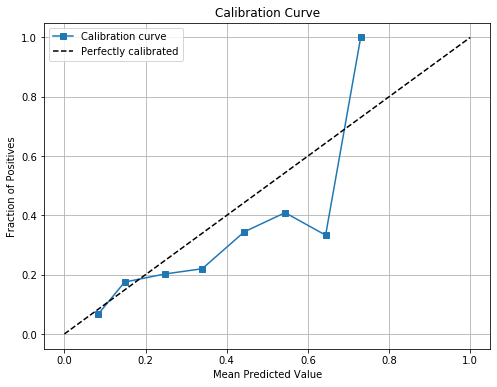

In [18]:
# Calculate probabilities for calibration 
calibration_y_prob = best_model.predict(val_data)

# Calculate frequencies for calibration
calibration_y_true = y_val

# Plot calibration curve
plt.figure(figsize=(8, 6))
fraction_of_positives, mean_predicted_value = calibration_curve(calibration_y_true, calibration_y_prob, n_bins=10)
plt.plot(mean_predicted_value, fraction_of_positives, 's-', label='Calibration curve')
plt.plot([0, 1], [0, 1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean Predicted Value')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')
plt.legend()
plt.grid(True)
plt.show()


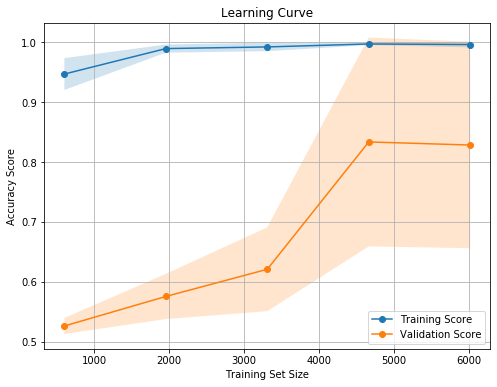

In [19]:
#XGBClassifier with the best hyperparameters
xgb_model = XGBClassifier(**best_params)
xgb_model.fit(X_train, y_train)

# Calculate the learning curve
train_sizes, train_scores, val_scores = learning_curve(xgb_model, X_train, y_train, cv=5, scoring='accuracy')

# Calculate the mean and standard deviation of train and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', label='Training Score')
plt.plot(train_sizes, val_scores_mean, 'o-', label='Validation Score')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2)
plt.fill_between(train_sizes, val_scores_mean - val_scores_std, val_scores_mean + val_scores_std, alpha=0.2)
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy Score')
plt.title('Learning Curve')
plt.legend()
plt.grid(True)
plt.show()


### Optuna optimization sacrificed recall in class 1 for a more accurate overall model. Below we built a precision-recall curve and roc curve to analyze the tradeoff between true positive rate and false positive rate.

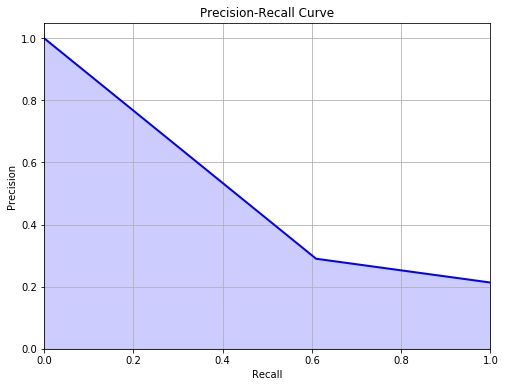

              precision    recall  f1-score   support

           0       0.85      0.60      0.70       472
           1       0.29      0.61      0.39       128

    accuracy                           0.60       600
   macro avg       0.57      0.60      0.55       600
weighted avg       0.73      0.60      0.63       600



In [20]:
# Calculate precision, recall, and thresholds
precisions, recalls, thresholds = precision_recall_curve(y_val, adjusted_y_val_pred)

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recalls, precisions, color='blue', lw=2)
plt.fill_between(recalls, precisions, alpha=0.2, color='blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.grid(True)
plt.show()

# Print classification report
print(classification_report(y_val, adjusted_y_val_pred))


Best Threshold=0.240920, G-Mean=0.609


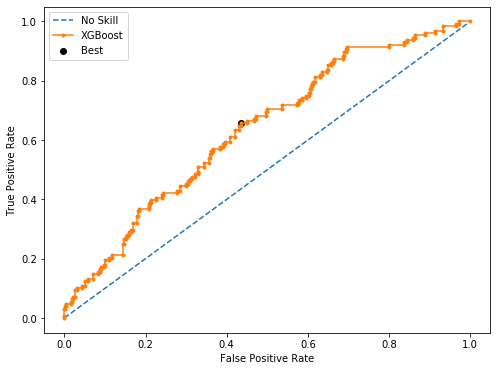

In [21]:
# Compute the ROC curve points
fpr, tpr, thresholds = roc_curve(y_val, val_predictions)

# Calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))

# Locate the index of the largest g-mean
ix = np.argmax(gmeans)

print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

# Plot the roc curve
plt.figure(figsize=(8, 6))
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='XGBoost')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


# Risk Stratification<a name="risk-stratification"></a>

### Okay, performance of our model is not amazing. There is some opportunity for discriptive analysis of feature importance and potentially some predictive benefit of the high recall rate for class 1 in terms of early warning metric. Below is the beginning of work to attempt to stratify risk according to low, medium, and high. 

In [22]:
#new matrices to prevent redundancy
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test)

In [23]:
#build a function for threshold categorization
def categorize_risk(probability, low_risk_threshold, medium_risk_threshold):
    if probability <= low_risk_threshold:
        return 'low'
    elif probability <= medium_risk_threshold:
        return 'medium'
    else:
        return 'high'
low_risk_threshold = 0.33
medium_risk_threshold = 0.6

In [24]:
risk_categories = [categorize_risk(p, low_risk_threshold, medium_risk_threshold) for p in y_val_prob]


In [25]:
y_val_flat = y_val.values.ravel()

# Convert to the correct data types
y_val_numeric = pd.to_numeric(y_val_flat)

df_evaluation = pd.DataFrame({'RiskCategory': risk_categories, 'ActualOutcome': y_val_numeric})

# Now we calculate the mean and sum of ActualOutcome within each RiskCategory
mean_outcomes = df_evaluation.groupby('RiskCategory')['ActualOutcome'].mean()
sum_outcomes = df_evaluation.groupby('RiskCategory')['ActualOutcome'].sum()

print(mean_outcomes)
print(sum_outcomes)

RiskCategory
high      0.500000
low       0.183807
medium    0.302158
Name: ActualOutcome, dtype: float64
RiskCategory
high       2
low       84
medium    42
Name: ActualOutcome, dtype: int64


In [26]:
# Save model
bst.save_model('/dsa/groups/casestudy2023su/team03/model_data/pickeled_models/XGb4optuna.json')
best_model.save_model('/dsa/groups/casestudy2023su/team03/model_data/pickeled_models/XGoptuna.json')

